In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb

from xgboost import XGBClassifier

from datetime import datetime,timedelta

import os
os.chdir('../Python')
from utilities import *
os.chdir('../development')

# Loading data

In [36]:
data = load("../Generated Data/atp_data_f")
features=load("../Generated Data/atp_data_features")
eval_odds=load("../Generated Data/eval_odds")

In [653]:
def get_cals_to_drop(start_date,nb_players,nb_tournaments):
    
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    
    return to_drop_players, to_drop_tournaments
    

In [654]:
def make_split(days_diff,to_drop_players, to_drop_tournaments, start_date):
    
    
    #start_date=datetime(2016,2,1) #first day of testing set
    test_beginning_match=data[data.Date>=start_date].index[0] #id of the first match of the testing set
    span_matches=len(data)-test_beginning_match+1
    #duration_val_matches=700 + 10
    duration_val_matches=300 + days_diff
    duration_train_matches=10400
    #duration_train_matches=12122
    duration_test_matches=500
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)

    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
    
    global train_indices
    global val_indices
    global test_indices
    global xtest

    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    


    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    
    '''
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    # We drop smallest Tournaments and players
    '''
    xtrain=xtrain.drop(to_drop_players+to_drop_tournaments,1)
    xval=xval.drop(to_drop_players+to_drop_tournaments,1)
    xtest=xtest.drop(to_drop_players+to_drop_tournaments,1)
    
    
    
    
    
    
    return xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices
    
    #return xtrain, ytrain, xval, yval, xtest


In [14]:
len(train_indices)

24244

In [7]:
xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(5)

In [39]:

## XGB parameters
#learning_rate=[0.295] 
learning_rate=[0.3] 
max_depth=[19]
#max_depth=[10]
min_child_weight=[1]
gamma=[0.8]
csbt=[0.5]
lambd=[0]
alpha=[2]
#alpha=[1]
num_rounds=[300]
early_stop=[10]
params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
#xgb_params=params[0]
p=params[0]


def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
    else:
        return 'function_error', 0

    
    #print(preds.shape)
    
    #return 'neg_gain_error', 0

    return 'neg_gain_error', -gain.sum()




dtrain=xgb.DMatrix(xtrain,label=ytrain)

#the_metric = "logloss"
#the_metric = "error"
#the_metric = "auc"
#the_metric = ["error","auc"]
the_metric = 'evalerror'

dval=xgb.DMatrix(xval,label=yval)
eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
#eval_set = [(dval, 'eval')]
#params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
#        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
#        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4]}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

params={"objective":"binary:logistic",'subsample':0.8,
        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror)
#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

#model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))


[0]	train_loss-neg_gain_error:-110.61	eval-neg_gain_error:15.8456
Multiple eval metrics have been passed: 'eval-neg_gain_error' will be used for early stopping.

Will train until eval-neg_gain_error hasn't improved in 10 rounds.
[1]	train_loss-neg_gain_error:-570.352	eval-neg_gain_error:12.8859
[2]	train_loss-neg_gain_error:-970.036	eval-neg_gain_error:13.3708
[3]	train_loss-neg_gain_error:-1366.11	eval-neg_gain_error:11.8475
[4]	train_loss-neg_gain_error:-1761.72	eval-neg_gain_error:12.0528
[5]	train_loss-neg_gain_error:-2126.39	eval-neg_gain_error:10.9817
[6]	train_loss-neg_gain_error:-2429.23	eval-neg_gain_error:12.5219
[7]	train_loss-neg_gain_error:-2700.23	eval-neg_gain_error:11.7474
[8]	train_loss-neg_gain_error:-2948.49	eval-neg_gain_error:10.5577
[9]	train_loss-neg_gain_error:-3167.83	eval-neg_gain_error:9.65078
[10]	train_loss-neg_gain_error:-3371.46	eval-neg_gain_error:8.85426
[11]	train_loss-neg_gain_error:-3588.64	eval-neg_gain_error:9.93691
[12]	train_loss-neg_gain_error:-

In [723]:
def get_trained_model(days_diff,to_drop_players, to_drop_tournaments,start_date):
    xtrain, ytrain, xval, yval, xtest, train_indices, val_indices, test_indices = make_split(days_diff,to_drop_players, to_drop_tournaments,start_date)
    
    global p
    
    ## XGB parameters
    learning_rate=[0.295] 
    #learning_rate=[0.2] 
    #max_depth=[19]
    #max_depth=[10]
    max_depth=[25]
    min_child_weight=[1]
    gamma=[0.8]
    csbt=[0.5]
    lambd=[0]
    alpha=[2]
    #alpha=[1]
    num_rounds=[300]
    early_stop=[5]
    params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
    #xgb_params=params[0]
    p=params[0]


    def evalerror_inner(preds_in, dtrain):
        thr = 0.6
        #labels = dtrain.get_label()
        global eval_odds
        global train_indices
        global val_indices
        global test_indices
        
        preds_dec = np.zeros(len(preds_in))
        
        for k in range(0,len(preds_in)-1,2):
            if preds_in[k]>preds_in[k+1]:
                preds_dec[k] = preds_in[k]
                preds_dec[k+1] = 0
            else:
                preds_dec[k] = 0
                preds_dec[k+1] = preds_in[k+1]
        
        preds = np.array([1 if p_i>=thr else 0 for p_i in preds_dec])
        
        #print(f'Preds1 {preds_in[0:10]}')
        #print(f'Preds1 {preds_dec[0:10]}')
        #print(f'Preds1 {preds[0:10]}')


        if len(preds) == len(train_indices):
            odds = eval_odds[train_indices]
            gain = odds * preds       
            reachable = odds.sum()+(len(train_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable train loss: {-reachable} Train ROI: {current_roi}% Number of bets: {preds.sum()}')
            return 'train_gain_error', -gain.sum()
        elif len(preds) == len(val_indices):
            odds = eval_odds[val_indices]
            gain = odds * preds 
            reachable = odds.sum()+(len(val_indices)/2)
            current_roi = round(gain.sum()/preds.sum(),3)
            print(f'Max reachable eval  loss: {-reachable}  Eval ROI: {current_roi}% Number of bets: {preds.sum()}')
            print(f'Val Preds {preds[0:10]} Threshold: {thr}')
            return 'val_gain_error', -gain.sum()
        elif len(preds) == len(test_indices):
            odds = eval_odds[test_indices]
            gain = odds * preds 
            return 'test_gain_error', -gain.sum()
        else:
            return 'function_error', 0


        #print(preds.shape)

        #return 'neg_gain_error', 0

        #return 'neg_gain_error', -gain.sum()
        
    #xtrain.drop(['odds', 'odds_opp'], axis = 1, inplace = True)
    #xval.drop(['odds', 'odds_opp'], axis = 1,inplace = True)
    #xtest.drop(['odds', 'odds_opp'], axis = 1,inplace = True)



    dtrain=xgb.DMatrix(xtrain,label=ytrain)

    the_metric = "logloss"
    #the_metric = "error"
    #the_metric = "auc"
    #the_metric = ["error","auc"]
    #the_metric = 'evalerror'
    

    dval=xgb.DMatrix(xval,label=yval)
    eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
    #eval_set = [(dval, 'eval')]
    #params={'eval_metric':the_metric,"objective":"binary:logistic",'subsample':0.8,
    #        'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
    #        'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 0}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    params={"objective":"binary:logistic",'subsample':0.8,
            'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
            'gamma':p[3],'eta':p[0],'colsample_bytree':p[4],  'disable_default_eval_metric' : 1}
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), eval_metric = evalerror)
    model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]), feval = evalerror_inner)
    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))

    #model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))
    
    eval_predict = model.predict(dval)
    evalscore = evalerror_inner(eval_predict,dtrain)

    return model, train_indices, val_indices, test_indices , xtest, evalscore[1]

In [699]:
start_date=datetime(2017,5,1) #first day of testing set

to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,200,200)
    
    


model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, 0.7, vote_thr = (7/9), conf_thr = 0.7)


print(evalerror(y_voting, dtrain))
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))

Preds1 [0.5        0.5        0.57665277 0.5        0.4598593  0.5
 0.5        0.5587277  0.5909254  0.40320414]
Preds1 [0.         0.5        0.57665277 0.         0.         0.5
 0.         0.55872768 0.5909254  0.        ]
Preds1 [0 1 1 0 0 1 0 1 1 0]
Max reachable train loss: -9713.19 Train ROI: 0.161% Number of bets: 10052
Preds1 [0.5628796  0.43335354 0.39928108 0.601807   0.47894102 0.6013785
 0.5732198  0.45795664 0.6021436  0.40320414]
Preds1 [0.56287962 0.         0.         0.601807   0.         0.6013785
 0.57321978 0.         0.60214359 0.        ]
Preds1 [1 0 0 1 0 1 1 0 1 0]
Max reachable eval  loss: -312.36  Eval ROI: -0.03% Number of bets: 282
Val Preds [1 0 0 1 0 1 1 0 1 0] Threshold: 0.5
[0]	train_loss-train_gain_error:-1618.48	eval-val_gain_error:8.53
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Preds1 [0.5        0.5        0.63421375 0.3984463  0.51

KeyboardInterrupt: 

In [724]:
res =[]
for i in range(2013,2013,1):
    for j in range(1,1):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

        to_drop_players, to_drop_tournaments= get_cals_to_drop(start_date,200,200)
        
        
        threshold_test = 0.6
        threshold_test_conf = 0.6
        req_votes = 7/9
        
        threshold_train = 0.6 # !!! Not passed to function, just for saving info!
    


        model1, train_indices, val_indices, test_indices, xtest, evalscore1 = get_trained_model(0,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model2, train_indices, val_indices, test_indices, xtest, evalscore2 = get_trained_model(10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model3, train_indices, val_indices, test_indices, xtest, evalscore3 = get_trained_model(-10,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model4, train_indices, val_indices, test_indices, xtest, evalscore4 = get_trained_model(30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model5, train_indices, val_indices, test_indices, xtest, evalscore5 = get_trained_model(-30,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model6, train_indices, val_indices, test_indices, xtest, evalscore6 = get_trained_model(45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model7, train_indices, val_indices, test_indices, xtest, evalscore7 = get_trained_model(-45,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model8, train_indices, val_indices, test_indices, xtest, evalscore8 = get_trained_model(17,to_drop_players, to_drop_tournaments,start_date)
        print(start_date)
        model9, train_indices, val_indices, test_indices, xtest, evalscore9 = get_trained_model(-17,to_drop_players, to_drop_tournaments,start_date)



        clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
        classif = VotingClassifier(clf_list)
        xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
        #Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
        y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, threshold_test, vote_thr = req_votes, conf_thr = threshold_test_conf)

        result = [start_date, evalerror(y_voting, dtrain), evalerror(y_mean, dtrain),evalerror(y_voting_conf, dtrain), evalerror(y_mean_conf, dtrain), y_voting.sum(), y_mean.sum(), y_voting_conf.sum(),y_mean_conf.sum()]
        
        res.append(result)
        
        print(evalerror(y_voting, dtrain)[0:2])
        print(evalerror(y_mean, dtrain)[0:2])
        print(evalerror(y_mean_conf, dtrain)[0:2])
        print(evalerror(y_voting_conf, dtrain)[0:2])
        
        f1 = np.zeros((len(res),4))
        f2 = np.zeros((len(res),4))
        for r in range(4):
            f1[:,r] = np.array([row[r+1][1] for row in res])
            f2[:,r] = f1[:,r].cumsum()
        
        print(f1)
        print(f2)
post_fix = "_test"        
parameters = [threshold_test, threshold_test_voting, req_votes, threshold_train, p]        
dump(res,"train_test_results")

2013-01-01 00:00:00
Max reachable train loss: -9676.48 Train ROI: 0.18% Number of bets: 3376
Max reachable eval  loss: -282.3  Eval ROI: 0.037% Number of bets: 113
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-606.337	eval-val_gain_error:-4.14
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9676.48 Train ROI: 0.23% Number of bets: 6178
Max reachable eval  loss: -282.3  Eval ROI: 0.021% Number of bets: 185
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1420.4	eval-val_gain_error:-3.86
Max reachable train loss: -9676.48 Train ROI: 0.243% Number of bets: 7231
Max reachable eval  loss: -282.3  Eval ROI: -0.005% Number of bets: 210
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1758.38	eval-val_gain_error:1.13
Max reachable train loss: -9676.48 Train ROI

Max reachable train loss: -9677.05 Train ROI: 0.311% Number of bets: 8589
Max reachable eval  loss: -311.73  Eval ROI: -0.009% Number of bets: 263
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-2667.29	eval-val_gain_error:2.4
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1279.86	eval-val_gain_error:-11.01

Max reachable eval  loss: -311.73  Eval ROI: -0.009% Number of bets: 263
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
2013-01-01 00:00:00
Max reachable train loss: -9665.69 Train ROI: 0.175% Number of bets: 3095
Max reachable eval  loss: -263.09  Eval ROI: 0.007% Number of bets: 90
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-540.096	eval-val_gain_error:-0.62
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9665.69 Train ROI: 0.199% Number of bets: 6314
Max reachab

Max reachable train loss: -9680.42 Train ROI: 0.276% Number of bets: 8209
Max reachable eval  loss: -295.36  Eval ROI: -0.022% Number of bets: 225
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2268.6	eval-val_gain_error:4.84
Max reachable train loss: -9680.42 Train ROI: 0.297% Number of bets: 8434
Max reachable eval  loss: -295.36  Eval ROI: -0.024% Number of bets: 232
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-2504.18	eval-val_gain_error:5.63
Max reachable train loss: -9680.42 Train ROI: 0.319% Number of bets: 8607
Max reachable eval  loss: -295.36  Eval ROI: -0.043% Number of bets: 248
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-2746.39	eval-val_gain_error:10.61
Max reachable train loss: -9680.42 Train ROI: 0.338% Number of bets: 8750
Max reachable eval  loss: -295.36  Eval ROI: -0.04% Number of bets: 248
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_e

Max reachable train loss: -9659.83 Train ROI: 0.127% Number of bets: 3218
Max reachable eval  loss: -251.42000000000002  Eval ROI: -0.052% Number of bets: 124
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-409.946	eval-val_gain_error:6.46
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9659.83 Train ROI: 0.206% Number of bets: 6117
Max reachable eval  loss: -251.42000000000002  Eval ROI: -0.025% Number of bets: 181
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1260.62	eval-val_gain_error:4.45
Max reachable train loss: -9659.83 Train ROI: 0.244% Number of bets: 7287
Max reachable eval  loss: -251.42000000000002  Eval ROI: 0.046% Number of bets: 206
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1778.24	eval-val_gain_error:-9.47
Max reachable train lo

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9664.43 Train ROI: 0.201% Number of bets: 6280
Max reachable eval  loss: -206.82  Eval ROI: 0.029% Number of bets: 161
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1264.26	eval-val_gain_error:-4.74
Max reachable train loss: -9664.43 Train ROI: 0.244% Number of bets: 7261
Max reachable eval  loss: -206.82  Eval ROI: 0.084% Number of bets: 175
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1773.65	eval-val_gain_error:-14.74
Max reachable train loss: -9664.43 Train ROI: 0.267% Number of bets: 7834
Max reachable eval  loss: -206.82  Eval ROI: 0.041% Number of bets: 188
Val Preds [0 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2088.49	eval-val_gain_error:-7.63
Max reachable train loss: -9664.43 Train ROI: 0.29% Numbe

Max reachable train loss: -9661.119999999999 Train ROI: 0.455% Number of bets: 9362
Max reachable eval  loss: -195.13  Eval ROI: -0.015% Number of bets: 209
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-4263.61	eval-val_gain_error:3.18
Stopping. Best iteration:
[8]	train_loss-train_gain_error:-3352.75	eval-val_gain_error:-17.84

Max reachable eval  loss: -195.13  Eval ROI: -0.015% Number of bets: 209
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
2013-02-01 00:00:00
Max reachable train loss: -9659.01 Train ROI: 0.187% Number of bets: 2987
Max reachable eval  loss: -259.24  Eval ROI: -0.067% Number of bets: 111
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-557.606	eval-val_gain_error:7.41
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9659.01 Train ROI: 0.205% Number of bets: 650

Max reachable train loss: -9602.17 Train ROI: 0.181% Number of bets: 3648
Max reachable eval  loss: -302.0  Eval ROI: -0.075% Number of bets: 112
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-658.941	eval-val_gain_error:8.39
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9602.17 Train ROI: 0.224% Number of bets: 6356
Max reachable eval  loss: -302.0  Eval ROI: -0.05% Number of bets: 179
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1421.3	eval-val_gain_error:8.89
Max reachable train loss: -9602.17 Train ROI: 0.263% Number of bets: 7313
Max reachable eval  loss: -302.0  Eval ROI: -0.076% Number of bets: 191
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1923.93	eval-val_gain_error:14.54
Max reachable train loss: -9602.17 Train ROI: 0.288% Number of

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9601.58 Train ROI: 0.235% Number of bets: 6188
Max reachable eval  loss: -332.59  Eval ROI: -0.042% Number of bets: 161
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1457.19	eval-val_gain_error:6.72
Max reachable train loss: -9601.58 Train ROI: 0.254% Number of bets: 7323
Max reachable eval  loss: -332.59  Eval ROI: -0.046% Number of bets: 210
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1856.85	eval-val_gain_error:9.71
Max reachable train loss: -9601.58 Train ROI: 0.273% Number of bets: 7814
Max reachable eval  loss: -332.59  Eval ROI: -0.046% Number of bets: 218
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2131.95	eval-val_gain_error:10.04
Max reachable train loss: -9601.58 Train ROI: 0.304% Numb

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1346.92	eval-val_gain_error:2.4

Max reachable eval  loss: -263.6  Eval ROI: -0.05% Number of bets: 195
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
2013-03-01 00:00:00
Max reachable train loss: -9598.77 Train ROI: 0.17% Number of bets: 2873
Max reachable eval  loss: -322.40000000000003  Eval ROI: -0.031% Number of bets: 86
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-487.558	eval-val_gain_error:2.69
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9598.77 Train ROI: 0.217% Number of bets: 6017
Max reachable eval  loss: -322.40000000000003  Eval ROI: -0.001% Number of bets: 174
Val Preds [0 0 0 1 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1303.54	eval-val_gain_error:0.26
Max reachable train loss: -9598.77 Train ROI: 0.25% Number of bets

Max reachable train loss: -9622.56 Train ROI: 0.327% Number of bets: 8080
Max reachable eval  loss: -276.93  Eval ROI: -0.008% Number of bets: 216
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2640.49	eval-val_gain_error:1.78
Max reachable train loss: -9622.56 Train ROI: 0.348% Number of bets: 8423
Max reachable eval  loss: -276.93  Eval ROI: -0.001% Number of bets: 221
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-2932.69	eval-val_gain_error:0.29
Max reachable train loss: -9622.56 Train ROI: 0.366% Number of bets: 8644
Max reachable eval  loss: -276.93  Eval ROI: -0.001% Number of bets: 225
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3164.62	eval-val_gain_error:0.25
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1295.24	eval-val_gain_error:-2.18

Max reachable eval  loss: -276.93  Eval ROI: -0.001% Number of bets: 225
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
2013-0

Max reachable train loss: -9621.82 Train ROI: 0.259% Number of bets: 7282
Max reachable eval  loss: -312.67  Eval ROI: 0.023% Number of bets: 214
Val Preds [0 1 0 1 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1886.23	eval-val_gain_error:-4.94
Max reachable train loss: -9621.82 Train ROI: 0.288% Number of bets: 7806
Max reachable eval  loss: -312.67  Eval ROI: -0.006% Number of bets: 240
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2246.43	eval-val_gain_error:1.45
Max reachable train loss: -9621.82 Train ROI: 0.321% Number of bets: 8125
Max reachable eval  loss: -312.67  Eval ROI: -0.017% Number of bets: 243
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2605.92	eval-val_gain_error:4.07
Max reachable train loss: -9621.82 Train ROI: 0.348% Number of bets: 8439
Max reachable eval  loss: -312.67  Eval ROI: -0.014% Number of bets: 257
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_

Max reachable eval  loss: -292.12  Eval ROI: -0.02% Number of bets: 238
Val Preds [1 0 0 1 0 1 0 0 0 0] Threshold: 0.6
2013-04-01 00:00:00
Max reachable train loss: -9620.19 Train ROI: 0.104% Number of bets: 3734
Max reachable eval  loss: -252.29999999999998  Eval ROI: -0.017% Number of bets: 104
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-387.994	eval-val_gain_error:1.76
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9620.19 Train ROI: 0.212% Number of bets: 5890
Max reachable eval  loss: -252.29999999999998  Eval ROI: 0.015% Number of bets: 154
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1249.35	eval-val_gain_error:-2.33
Max reachable train loss: -9620.19 Train ROI: 0.258% Number of bets: 7123
Max reachable eval  loss: -252.29999999999998  Eval ROI: 0.029% Number of bets: 1

Max reachable train loss: -9582.73 Train ROI: 0.391% Number of bets: 8772
Max reachable eval  loss: -304.91  Eval ROI: -0.015% Number of bets: 220
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-3429.59	eval-val_gain_error:3.22
Max reachable train loss: -9582.73 Train ROI: 0.413% Number of bets: 8927
Max reachable eval  loss: -304.91  Eval ROI: -0.02% Number of bets: 227
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-3688.68	eval-val_gain_error:4.45
Max reachable train loss: -9582.73 Train ROI: 0.432% Number of bets: 9028
Max reachable eval  loss: -304.91  Eval ROI: -0.0% Number of bets: 222
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-3896.21	eval-val_gain_error:0.06
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-2722.87	eval-val_gain_error:-2.1

Max reachable eval  loss: -304.91  Eval ROI: -0.0% Number of bets: 222
Val Preds [1 0 1 0 1 0 0 0 0 1] Threshold: 0.6
2013-05-01 0

Max reachable train loss: -9596.86 Train ROI: 0.328% Number of bets: 8097
Max reachable eval  loss: -250.78  Eval ROI: -0.094% Number of bets: 181
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2659.79	eval-val_gain_error:17.09
Max reachable train loss: -9596.86 Train ROI: 0.36% Number of bets: 8422
Max reachable eval  loss: -250.78  Eval ROI: -0.053% Number of bets: 187
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3032.42	eval-val_gain_error:9.89
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-481.632	eval-val_gain_error:4.02

Max reachable eval  loss: -250.78  Eval ROI: -0.053% Number of bets: 187
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
2013-05-01 00:00:00
Max reachable train loss: -9597.58 Train ROI: 0.135% Number of bets: 3035
Max reachable eval  loss: -325.06  Eval ROI: -0.025% Number of bets: 100
Val Preds [0 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-410.277	eval-val_gai

Max reachable train loss: -9595.369999999999 Train ROI: 0.486% Number of bets: 9307
Max reachable eval  loss: -237.26999999999998  Eval ROI: 0.127% Number of bets: 185
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-4524.72	eval-val_gain_error:-23.42
Max reachable train loss: -9595.369999999999 Train ROI: 0.503% Number of bets: 9398
Max reachable eval  loss: -237.26999999999998  Eval ROI: 0.051% Number of bets: 194
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-4723.2	eval-val_gain_error:-9.98
Max reachable train loss: -9595.369999999999 Train ROI: 0.518% Number of bets: 9446
Max reachable eval  loss: -237.26999999999998  Eval ROI: 0.006% Number of bets: 193
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-4892.05	eval-val_gain_error:-1.12
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-4000.72	eval-val_gain_error:-25.61

Max reachable eval  loss: -237.26999999999998  Eval ROI:

Max reachable train loss: -9576.71 Train ROI: 0.12% Number of bets: 4027
Max reachable eval  loss: -269.39  Eval ROI: -0.02% Number of bets: 137
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-484.967	eval-val_gain_error:2.74
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9576.71 Train ROI: 0.233% Number of bets: 5990
Max reachable eval  loss: -269.39  Eval ROI: -0.097% Number of bets: 185
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1396.92	eval-val_gain_error:17.95
Max reachable train loss: -9576.71 Train ROI: 0.278% Number of bets: 7225
Max reachable eval  loss: -269.39  Eval ROI: -0.052% Number of bets: 202
Val Preds [0 0 0 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2006.43	eval-val_gain_error:10.58
Max reachable train loss: -9576.71 Train ROI: 0.305% Numbe

Max reachable train loss: -9571.64 Train ROI: 0.25% Number of bets: 5951
Max reachable eval  loss: -244.46  Eval ROI: -0.086% Number of bets: 147
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1487.32	eval-val_gain_error:12.58
Max reachable train loss: -9571.64 Train ROI: 0.291% Number of bets: 7265
Max reachable eval  loss: -244.46  Eval ROI: -0.069% Number of bets: 182
Val Preds [0 1 0 0 0 0 0 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2114.62	eval-val_gain_error:12.54
Max reachable train loss: -9571.64 Train ROI: 0.318% Number of bets: 7811
Max reachable eval  loss: -244.46  Eval ROI: -0.093% Number of bets: 196
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2482.25	eval-val_gain_error:18.18
Max reachable train loss: -9571.64 Train ROI: 0.346% Number of bets: 8159
Max reachable eval  loss: -244.46  Eval ROI: -0.081% Number of bets: 202
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.6
[4]	train_loss-train_gai

Max reachable train loss: -9574.8 Train ROI: 0.308% Number of bets: 7824
Max reachable eval  loss: -254.3  Eval ROI: -0.042% Number of bets: 202
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2410.29	eval-val_gain_error:8.46
Max reachable train loss: -9574.8 Train ROI: 0.351% Number of bets: 8165
Max reachable eval  loss: -254.3  Eval ROI: -0.109% Number of bets: 212
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2862.2	eval-val_gain_error:23.18
Max reachable train loss: -9574.8 Train ROI: 0.371% Number of bets: 8464
Max reachable eval  loss: -254.3  Eval ROI: -0.105% Number of bets: 216
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3139.51	eval-val_gain_error:22.64
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-585.111	eval-val_gain_error:3.71

Max reachable eval  loss: -254.3  Eval ROI: -0.105% Number of bets: 216
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[0. 0. 0. 0. 

Max reachable train loss: -9551.07 Train ROI: 0.115% Number of bets: 3514
Max reachable eval  loss: -318.86  Eval ROI: -0.013% Number of bets: 118
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-403.758	eval-val_gain_error:1.55
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9551.07 Train ROI: 0.225% Number of bets: 5836
Max reachable eval  loss: -318.86  Eval ROI: -0.061% Number of bets: 166
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1314.59	eval-val_gain_error:10.15
Max reachable train loss: -9551.07 Train ROI: 0.278% Number of bets: 7166
Max reachable eval  loss: -318.86  Eval ROI: -0.023% Number of bets: 188
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-1992.36	eval-val_gain_error:4.33
Max reachable train loss: -9551.07 Train ROI: 0.311% Numb

Max reachable train loss: -9543.26 Train ROI: 0.52% Number of bets: 9279
Max reachable eval  loss: -306.66999999999996  Eval ROI: -0.005% Number of bets: 209
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-4822.59	eval-val_gain_error:1.08
Max reachable train loss: -9543.26 Train ROI: 0.538% Number of bets: 9377
Max reachable eval  loss: -306.66999999999996  Eval ROI: 0.005% Number of bets: 211
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5047.55	eval-val_gain_error:-1.05
Max reachable train loss: -9543.26 Train ROI: 0.554% Number of bets: 9464
Max reachable eval  loss: -306.66999999999996  Eval ROI: 0.032% Number of bets: 212
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5247.24	eval-val_gain_error:-6.85
Stopping. Best iteration:
[8]	train_loss-train_gain_error:-4100.58	eval-val_gain_error:-7.66

Max reachable eval  loss: -306.66999999999996  Eval ROI: 0.032% Number of bets: 212
Val 

Stopping. Best iteration:
[7]	train_loss-train_gain_error:-3812.38	eval-val_gain_error:-4.3

Max reachable eval  loss: -297.94  Eval ROI: 0.005% Number of bets: 197
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
2013-07-01 00:00:00
Max reachable train loss: -9569.97 Train ROI: 0.133% Number of bets: 3025
Max reachable eval  loss: -326.96000000000004  Eval ROI: -0.017% Number of bets: 117
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-403.081	eval-val_gain_error:1.94
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9569.97 Train ROI: 0.231% Number of bets: 5823
Max reachable eval  loss: -326.96000000000004  Eval ROI: -0.022% Number of bets: 175
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1344.84	eval-val_gain_error:3.88
Max reachable train loss: -9569.97 Train ROI: 0.273% Number of

Max reachable train loss: -9577.55 Train ROI: 0.172% Number of bets: 4114
Max reachable eval  loss: -270.79  Eval ROI: -0.026% Number of bets: 119
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-707.166	eval-val_gain_error:3.15
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9577.55 Train ROI: 0.233% Number of bets: 6353
Max reachable eval  loss: -270.79  Eval ROI: 0.029% Number of bets: 168
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1481.62	eval-val_gain_error:-4.81
Max reachable train loss: -9577.55 Train ROI: 0.286% Number of bets: 7337
Max reachable eval  loss: -270.79  Eval ROI: 0.08% Number of bets: 189
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2101.53	eval-val_gain_error:-15.03
Max reachable train loss: -9577.55 Train ROI: 0.321% Numbe

Max reachable train loss: -9571.22 Train ROI: 0.509% Number of bets: 9214
Max reachable eval  loss: -267.12  Eval ROI: 0.071% Number of bets: 217
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-4687.98	eval-val_gain_error:-15.36
Max reachable train loss: -9571.22 Train ROI: 0.517% Number of bets: 9265
Max reachable eval  loss: -267.12  Eval ROI: 0.033% Number of bets: 215
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-4785.8	eval-val_gain_error:-7.2
Max reachable train loss: -9571.22 Train ROI: 0.533% Number of bets: 9333
Max reachable eval  loss: -267.12  Eval ROI: 0.047% Number of bets: 217
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-4973.09	eval-val_gain_error:-10.11
Max reachable train loss: -9571.22 Train ROI: 0.544% Number of bets: 9398
Max reachable eval  loss: -267.12  Eval ROI: 0.046% Number of bets: 214
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[13]	train_loss-train_ga

Max reachable train loss: -9528.63 Train ROI: 0.344% Number of bets: 8176
Max reachable eval  loss: -364.71  Eval ROI: -0.003% Number of bets: 240
Val Preds [1 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-2811.2	eval-val_gain_error:0.74
Max reachable train loss: -9528.63 Train ROI: 0.374% Number of bets: 8452
Max reachable eval  loss: -364.71  Eval ROI: -0.015% Number of bets: 245
Val Preds [1 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3161.57	eval-val_gain_error:3.71
Max reachable train loss: -9528.63 Train ROI: 0.397% Number of bets: 8673
Max reachable eval  loss: -364.71  Eval ROI: -0.026% Number of bets: 256
Val Preds [1 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3442.5	eval-val_gain_error:6.67
Max reachable train loss: -9528.63 Train ROI: 0.428% Number of bets: 8834
Max reachable eval  loss: -364.71  Eval ROI: -0.015% Number of bets: 248
Val Preds [1 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[7]	train_loss-train_gain_er

Max reachable train loss: -9571.03 Train ROI: 0.329% Number of bets: 7879
Max reachable eval  loss: -260.31  Eval ROI: 0.082% Number of bets: 192
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2595.43	eval-val_gain_error:-15.75
Max reachable train loss: -9571.03 Train ROI: 0.355% Number of bets: 8277
Max reachable eval  loss: -260.31  Eval ROI: 0.05% Number of bets: 203
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-2936.42	eval-val_gain_error:-10.12
Max reachable train loss: -9571.03 Train ROI: 0.383% Number of bets: 8542
Max reachable eval  loss: -260.31  Eval ROI: 0.061% Number of bets: 203
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3272.01	eval-val_gain_error:-12.34
Max reachable train loss: -9571.03 Train ROI: 0.405% Number of bets: 8707
Max reachable eval  loss: -260.31  Eval ROI: 0.052% Number of bets: 212
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9548.07 Train ROI: 0.251% Number of bets: 6316
Max reachable eval  loss: -299.45  Eval ROI: -0.025% Number of bets: 158
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1583.47	eval-val_gain_error:3.89
Max reachable train loss: -9548.07 Train ROI: 0.297% Number of bets: 7322
Max reachable eval  loss: -299.45  Eval ROI: -0.04% Number of bets: 180
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2175.75	eval-val_gain_error:7.14
Max reachable train loss: -9548.07 Train ROI: 0.323% Number of bets: 7850
Max reachable eval  loss: -299.45  Eval ROI: -0.024% Number of bets: 198
Val Preds [1 0 0 1 0 0 0 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2532.32	eval-val_gain_error:4.7
Max reachable train loss: -9548.07 Train ROI: 0.362% Number 

Max reachable train loss: -9557.6 Train ROI: 0.489% Number of bets: 9061
Max reachable eval  loss: -344.92  Eval ROI: -0.005% Number of bets: 258
Val Preds [0 0 1 0 1 0 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4428.01	eval-val_gain_error:1.36
Max reachable train loss: -9557.6 Train ROI: 0.505% Number of bets: 9143
Max reachable eval  loss: -344.92  Eval ROI: -0.014% Number of bets: 256
Val Preds [1 0 1 0 1 0 1 0 0 1] Threshold: 0.6
[10]	train_loss-train_gain_error:-4620.94	eval-val_gain_error:3.64
Max reachable train loss: -9557.6 Train ROI: 0.525% Number of bets: 9248
Max reachable eval  loss: -344.92  Eval ROI: -0.02% Number of bets: 265
Val Preds [1 0 1 0 1 0 1 0 0 1] Threshold: 0.6
[11]	train_loss-train_gain_error:-4857.73	eval-val_gain_error:5.21
Stopping. Best iteration:
[6]	train_loss-train_gain_error:-3558.1	eval-val_gain_error:-3.46

Max reachable eval  loss: -344.92  Eval ROI: -0.02% Number of bets: 265
Val Preds [1 0 1 0 1 0 1 0 0 1] Threshold: 0.6
2013-09-01

Max reachable train loss: -9549.4 Train ROI: 0.115% Number of bets: 2979
Max reachable eval  loss: -311.7  Eval ROI: -0.116% Number of bets: 83
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-343.64	eval-val_gain_error:9.6
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9549.4 Train ROI: 0.247% Number of bets: 6173
Max reachable eval  loss: -311.7  Eval ROI: -0.074% Number of bets: 170
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1523.06	eval-val_gain_error:12.55
Max reachable train loss: -9549.4 Train ROI: 0.306% Number of bets: 7338
Max reachable eval  loss: -311.7  Eval ROI: -0.074% Number of bets: 200
Val Preds [1 0 1 0 1 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2242.97	eval-val_gain_error:14.85
Max reachable train loss: -9549.4 Train ROI: 0.324% Number of bet

Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2167.52	eval-val_gain_error:-5.39

Max reachable eval  loss: -334.93  Eval ROI: -0.029% Number of bets: 259
Val Preds [0 1 1 0 1 0 1 0 0 0] Threshold: 0.6
2013-10-01 00:00:00
Max reachable train loss: -9549.99 Train ROI: 0.161% Number of bets: 3588
Max reachable eval  loss: -281.11  Eval ROI: -0.083% Number of bets: 92
Val Preds [0 1 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-576.463	eval-val_gain_error:7.67
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9549.99 Train ROI: 0.234% Number of bets: 6431
Max reachable eval  loss: -281.11  Eval ROI: -0.1% Number of bets: 159
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1507.12	eval-val_gain_error:15.92
Max reachable train loss: -9549.99 Train ROI: 0.294% Number of bets: 7331
Max reachabl

Max reachable train loss: -9555.99 Train ROI: 0.323% Number of bets: 7839
Max reachable eval  loss: -322.11  Eval ROI: -0.051% Number of bets: 216
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2529.77	eval-val_gain_error:10.96
Max reachable train loss: -9555.99 Train ROI: 0.355% Number of bets: 8175
Max reachable eval  loss: -322.11  Eval ROI: -0.037% Number of bets: 223
Val Preds [1 0 0 1 0 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2899.48	eval-val_gain_error:8.15
Max reachable train loss: -9555.99 Train ROI: 0.387% Number of bets: 8463
Max reachable eval  loss: -322.11  Eval ROI: -0.028% Number of bets: 226
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3271.91	eval-val_gain_error:6.35
Max reachable train loss: -9555.99 Train ROI: 0.416% Number of bets: 8684
Max reachable eval  loss: -322.11  Eval ROI: -0.034% Number of bets: 232
Val Preds [0 0 0 1 0 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9566.88 Train ROI: 0.237% Number of bets: 6329
Max reachable eval  loss: -287.75  Eval ROI: 0.0% Number of bets: 156
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1497.73	eval-val_gain_error:-0.02
Max reachable train loss: -9566.88 Train ROI: 0.286% Number of bets: 7430
Max reachable eval  loss: -287.75  Eval ROI: 0.016% Number of bets: 210
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2128.09	eval-val_gain_error:-3.43
Max reachable train loss: -9566.88 Train ROI: 0.329% Number of bets: 7888
Max reachable eval  loss: -287.75  Eval ROI: 0.012% Number of bets: 224
Val Preds [0 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2599.07	eval-val_gain_error:-2.59
Max reachable train loss: -9566.88 Train ROI: 0.365% Number of bets: 8227
Max reachable eval  loss: -287.75  Eval ROI: 0.043% Number of bets: 233
Val Preds 

Max reachable train loss: -9564.69 Train ROI: 0.498% Number of bets: 9073
Max reachable eval  loss: -309.94  Eval ROI: 0.059% Number of bets: 243
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4521.7	eval-val_gain_error:-14.39
Max reachable train loss: -9564.69 Train ROI: 0.523% Number of bets: 9144
Max reachable eval  loss: -309.94  Eval ROI: 0.062% Number of bets: 244
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[10]	train_loss-train_gain_error:-4785.71	eval-val_gain_error:-15.02
Max reachable train loss: -9564.69 Train ROI: 0.545% Number of bets: 9265
Max reachable eval  loss: -309.94  Eval ROI: 0.047% Number of bets: 243
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[11]	train_loss-train_gain_error:-5051.6	eval-val_gain_error:-11.37
Max reachable train loss: -9564.69 Train ROI: 0.568% Number of bets: 9344
Max reachable eval  loss: -309.94  Eval ROI: 0.046% Number of bets: 244
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[12]	train_loss-train_ga

Max reachable train loss: -9557.99 Train ROI: 0.405% Number of bets: 8540
Max reachable eval  loss: -241.64000000000001  Eval ROI: -0.049% Number of bets: 189
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3460.72	eval-val_gain_error:9.29
Max reachable train loss: -9557.99 Train ROI: 0.431% Number of bets: 8721
Max reachable eval  loss: -241.64000000000001  Eval ROI: -0.04% Number of bets: 189
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3755.07	eval-val_gain_error:7.6
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1631.1	eval-val_gain_error:-2.57

Max reachable eval  loss: -241.64000000000001  Eval ROI: -0.04% Number of bets: 189
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
2013-11-01 00:00:00
Max reachable train loss: -9566.09 Train ROI: 0.132% Number of bets: 3615
Max reachable eval  loss: -295.54  Eval ROI: -0.1% Number of bets: 91
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_ga

Max reachable train loss: -9566.93 Train ROI: 0.326% Number of bets: 7862
Max reachable eval  loss: -271.15999999999997  Eval ROI: 0.009% Number of bets: 205
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2563.25	eval-val_gain_error:-1.81
Max reachable train loss: -9566.93 Train ROI: 0.366% Number of bets: 8230
Max reachable eval  loss: -271.15999999999997  Eval ROI: 0.051% Number of bets: 207
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3015.9	eval-val_gain_error:-10.61
Max reachable train loss: -9566.93 Train ROI: 0.404% Number of bets: 8450
Max reachable eval  loss: -271.15999999999997  Eval ROI: 0.03% Number of bets: 212
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3412.69	eval-val_gain_error:-6.4
Max reachable train loss: -9566.93 Train ROI: 0.432% Number of bets: 8633
Max reachable eval  loss: -271.15999999999997  Eval ROI: 0.026% Number of bets: 228
Val Preds [0 0 1 0 1 0 0 0 1

Max reachable train loss: -9562.61 Train ROI: 0.377% Number of bets: 8220
Max reachable eval  loss: -265.48  Eval ROI: 0.012% Number of bets: 202
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3102.18	eval-val_gain_error:-2.34
Max reachable train loss: -9562.61 Train ROI: 0.417% Number of bets: 8484
Max reachable eval  loss: -265.48  Eval ROI: -0.012% Number of bets: 205
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3538.51	eval-val_gain_error:2.46
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-712.04	eval-val_gain_error:-7.02

Max reachable eval  loss: -265.48  Eval ROI: -0.012% Number of bets: 205
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.6
2013-12-01 00:00:00
Max reachable train loss: -9565.43 Train ROI: 0.141% Number of bets: 3697
Max reachable eval  loss: -302.65999999999997  Eval ROI: 0.062% Number of bets: 83
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-522.706	ev

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9566.369999999999 Train ROI: 0.263% Number of bets: 6184
Max reachable eval  loss: -316.72  Eval ROI: 0.016% Number of bets: 177
Val Preds [0 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1623.99	eval-val_gain_error:-2.87
Max reachable train loss: -9566.369999999999 Train ROI: 0.297% Number of bets: 7437
Max reachable eval  loss: -316.72  Eval ROI: -0.004% Number of bets: 216
Val Preds [1 0 0 0 0 0 0 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2206.51	eval-val_gain_error:0.83
Max reachable train loss: -9566.369999999999 Train ROI: 0.336% Number of bets: 7891
Max reachable eval  loss: -316.72  Eval ROI: -0.05% Number of bets: 237
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2651.71	eval-val_gain_error:11.78
Max reachable train loss: -9

Max reachable train loss: -9561.34 Train ROI: 0.434% Number of bets: 8646
Max reachable eval  loss: -259.75  Eval ROI: -0.029% Number of bets: 203
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3754.06	eval-val_gain_error:5.98
Max reachable train loss: -9561.34 Train ROI: 0.462% Number of bets: 8797
Max reachable eval  loss: -259.75  Eval ROI: -0.07% Number of bets: 210
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4062.72	eval-val_gain_error:14.63
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2236.77	eval-val_gain_error:-3.18

Max reachable eval  loss: -259.75  Eval ROI: -0.07% Number of bets: 210
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
('test_o_gain_error', 9.06)
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
('test_o_gain_error', 8.34)
[0, 0, 1, 0, 0, 0, 0, 

Max reachable train loss: -9553.69 Train ROI: 0.594% Number of bets: 9421
Max reachable eval  loss: -289.35  Eval ROI: 0.054% Number of bets: 239
Val Preds [0 1 0 1 1 0 1 0 0 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5599.5	eval-val_gain_error:-12.99
Max reachable train loss: -9553.69 Train ROI: 0.608% Number of bets: 9465
Max reachable eval  loss: -289.35  Eval ROI: 0.021% Number of bets: 238
Val Preds [0 1 0 1 1 0 1 0 0 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5755.47	eval-val_gain_error:-5.07
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-4610.32	eval-val_gain_error:-17.28

Max reachable eval  loss: -289.35  Eval ROI: 0.021% Number of bets: 238
Val Preds [0 1 0 1 1 0 1 0 0 0] Threshold: 0.6
2014-01-01 00:00:00
Max reachable train loss: -9565.04 Train ROI: 0.133% Number of bets: 4558
Max reachable eval  loss: -258.0  Eval ROI: -0.0% Number of bets: 111
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-605.763	eval-val_gai

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9564.83 Train ROI: 0.257% Number of bets: 6166
Max reachable eval  loss: -313.21  Eval ROI: 0.047% Number of bets: 174
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1584.87	eval-val_gain_error:-8.25
Max reachable train loss: -9564.83 Train ROI: 0.304% Number of bets: 7412
Max reachable eval  loss: -313.21  Eval ROI: 0.006% Number of bets: 225
Val Preds [0 0 0 0 1 0 0 1 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2255.65	eval-val_gain_error:-1.36
Max reachable train loss: -9564.83 Train ROI: 0.336% Number of bets: 7847
Max reachable eval  loss: -313.21  Eval ROI: -0.034% Number of bets: 243
Val Preds [0 0 0 1 1 0 0 1 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2633.75	eval-val_gain_error:8.37
Max reachable train loss: -9564.83 Train ROI: 0.378% Number of bets: 8255
Max reachable eval  loss: -313.21  Eval ROI: -0.012% Number of bets: 239
Val Pre

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9562.35 Train ROI: 0.25% Number of bets: 6519
Max reachable eval  loss: -253.69  Eval ROI: -0.01% Number of bets: 154
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1631.03	eval-val_gain_error:1.49
Max reachable train loss: -9562.35 Train ROI: 0.307% Number of bets: 7524
Max reachable eval  loss: -253.69  Eval ROI: -0.057% Number of bets: 181
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2312.21	eval-val_gain_error:10.32
Max reachable train loss: -9562.35 Train ROI: 0.337% Number of bets: 7909
Max reachable eval  loss: -253.69  Eval ROI: -0.06% Number of bets: 191
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2662.95	eval-val_gain_error:11.52
Max reachable train loss: -9562.35 Train ROI: 0.382% Number

Max reachable train loss: -9583.732 Train ROI: 0.339% Number of bets: 7867
Max reachable eval  loss: -273.59000000000003  Eval ROI: -0.082% Number of bets: 209
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2664.28	eval-val_gain_error:17.14
Max reachable train loss: -9583.732 Train ROI: 0.362% Number of bets: 8244
Max reachable eval  loss: -273.59000000000003  Eval ROI: -0.054% Number of bets: 218
Val Preds [0 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2980.44	eval-val_gain_error:11.81
Max reachable train loss: -9583.732 Train ROI: 0.403% Number of bets: 8472
Max reachable eval  loss: -273.59000000000003  Eval ROI: -0.064% Number of bets: 224
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3412.87	eval-val_gain_error:14.37
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-490.043	eval-val_gain_error:3.67

Max reachable eval  loss: -273.59000000000003  Eval ROI: -0.064% Number of bets: 224


Max reachable train loss: -9576.065 Train ROI: 0.338% Number of bets: 7882
Max reachable eval  loss: -247.87  Eval ROI: -0.072% Number of bets: 177
Val Preds [0 0 1 0 1 0 0 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2662.35	eval-val_gain_error:12.75
Max reachable train loss: -9576.065 Train ROI: 0.376% Number of bets: 8226
Max reachable eval  loss: -247.87  Eval ROI: -0.073% Number of bets: 181
Val Preds [0 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3094.42	eval-val_gain_error:13.26
Max reachable train loss: -9576.065 Train ROI: 0.411% Number of bets: 8497
Max reachable eval  loss: -247.87  Eval ROI: -0.025% Number of bets: 186
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3492.01	eval-val_gain_error:4.57
Max reachable train loss: -9576.065 Train ROI: 0.434% Number of bets: 8679
Max reachable eval  loss: -247.87  Eval ROI: -0.073% Number of bets: 195
Val Preds [0 1 1 0 0 0 0 0 0 1] Threshold: 0.6
[6]	train_loss-train

Max reachable train loss: -9609.251 Train ROI: 0.419% Number of bets: 8478
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.056% Number of bets: 214
Val Preds [1 0 1 0 0 1 1 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3550.71	eval-val_gain_error:-12.01
Max reachable train loss: -9609.251 Train ROI: 0.441% Number of bets: 8677
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.082% Number of bets: 217
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3822.86	eval-val_gain_error:-17.79
Max reachable train loss: -9609.251 Train ROI: 0.47% Number of bets: 8841
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.064% Number of bets: 213
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4159.24	eval-val_gain_error:-13.63
Max reachable train loss: -9609.251 Train ROI: 0.495% Number of bets: 8956
Max reachable eval  loss: -252.14999999999998  Eval ROI: 0.041% Number of bets: 215
Val Preds [1 0 0 1 1

Max reachable train loss: -9608.451 Train ROI: 0.376% Number of bets: 8249
Max reachable eval  loss: -282.03  Eval ROI: -0.056% Number of bets: 227
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3105.7	eval-val_gain_error:12.63
Max reachable train loss: -9608.451 Train ROI: 0.406% Number of bets: 8536
Max reachable eval  loss: -282.03  Eval ROI: -0.037% Number of bets: 234
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3465.99	eval-val_gain_error:8.74
Max reachable train loss: -9608.451 Train ROI: 0.432% Number of bets: 8707
Max reachable eval  loss: -282.03  Eval ROI: -0.058% Number of bets: 243
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3760.49	eval-val_gain_error:14.2
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1620.47	eval-val_gain_error:-1.15

Max reachable eval  loss: -282.03  Eval ROI: -0.058% Number of bets: 243
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
201

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9611.567 Train ROI: 0.253% Number of bets: 6275
Max reachable eval  loss: -268.98  Eval ROI: -0.002% Number of bets: 164
Val Preds [1 0 0 0 1 0 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1589.57	eval-val_gain_error:0.4
Max reachable train loss: -9611.567 Train ROI: 0.311% Number of bets: 7336
Max reachable eval  loss: -268.98  Eval ROI: -0.023% Number of bets: 202
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2278.78	eval-val_gain_error:4.64
Max reachable train loss: -9611.567 Train ROI: 0.343% Number of bets: 7845
Max reachable eval  loss: -268.98  Eval ROI: -0.037% Number of bets: 214
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2690.72	eval-val_gain_error:7.87
Max reachable train loss: -9611.567 Train ROI: 0.385% Number of bets: 8230
Max reachable eval  loss: -268.98  Eval ROI: -0.044% Number of bets: 221
Val 

Max reachable train loss: -9605.283 Train ROI: 0.593% Number of bets: 9348
Max reachable eval  loss: -260.86  Eval ROI: 0.016% Number of bets: 229
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5541.54	eval-val_gain_error:-3.69
Stopping. Best iteration:
[7]	train_loss-train_gain_error:-4179.22	eval-val_gain_error:-6.76

Max reachable eval  loss: -260.86  Eval ROI: 0.016% Number of bets: 229
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.6
2014-04-01 00:00:00
Max reachable train loss: -9600.846 Train ROI: 0.177% Number of bets: 3241
Max reachable eval  loss: -271.23  Eval ROI: 0.006% Number of bets: 101
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-574.908	eval-val_gain_error:-0.61
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9600.846 Train ROI: 0.252% Number of bets: 6309
Max rea

Max reachable train loss: -9594.487 Train ROI: 0.46% Number of bets: 8812
Max reachable eval  loss: -234.71  Eval ROI: 0.0% Number of bets: 208
Val Preds [0 0 1 0 1 0 0 1 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4055.25	eval-val_gain_error:-0.09
Max reachable train loss: -9594.487 Train ROI: 0.49% Number of bets: 8937
Max reachable eval  loss: -234.71  Eval ROI: -0.018% Number of bets: 207
Val Preds [0 0 1 0 1 0 0 1 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4379.54	eval-val_gain_error:3.63
Max reachable train loss: -9594.487 Train ROI: 0.517% Number of bets: 9090
Max reachable eval  loss: -234.71  Eval ROI: -0.003% Number of bets: 211
Val Preds [0 1 1 0 1 0 0 1 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4697.97	eval-val_gain_error:0.59
Max reachable train loss: -9594.487 Train ROI: 0.544% Number of bets: 9191
Max reachable eval  loss: -234.71  Eval ROI: -0.002% Number of bets: 210
Val Preds [0 1 1 0 1 0 0 1 0 1] Threshold: 0.6
[10]	train_loss-train_gain

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9599.957 Train ROI: 0.25% Number of bets: 6325
Max reachable eval  loss: -279.67  Eval ROI: 0.003% Number of bets: 189
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1580.13	eval-val_gain_error:-0.5
Max reachable train loss: -9599.957 Train ROI: 0.292% Number of bets: 7431
Max reachable eval  loss: -279.67  Eval ROI: 0.034% Number of bets: 215
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2167.26	eval-val_gain_error:-7.27
Max reachable train loss: -9599.957 Train ROI: 0.334% Number of bets: 7841
Max reachable eval  loss: -279.67  Eval ROI: 0.005% Number of bets: 222
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2618.8	eval-val_gain_error:-1.12
Max reachable train loss: -9599.957 Train ROI: 0.366% Numb

Max reachable train loss: -9581.291 Train ROI: 0.373% Number of bets: 8252
Max reachable eval  loss: -285.5  Eval ROI: -0.065% Number of bets: 217
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3075.81	eval-val_gain_error:14.02
Max reachable train loss: -9581.291 Train ROI: 0.409% Number of bets: 8493
Max reachable eval  loss: -285.5  Eval ROI: -0.062% Number of bets: 219
Val Preds [0 0 1 0 0 0 0 1 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3473.22	eval-val_gain_error:13.62
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-517.54	eval-val_gain_error:7.14

Max reachable eval  loss: -285.5  Eval ROI: -0.062% Number of bets: 219
Val Preds [0 0 1 0 0 0 0 1 0 1] Threshold: 0.6
2014-05-01 00:00:00
Max reachable train loss: -9580.649 Train ROI: 0.156% Number of bets: 3907
Max reachable eval  loss: -293.05  Eval ROI: -0.003% Number of bets: 103
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-609.539	eval-val_ga

Max reachable train loss: -9582.0 Train ROI: 0.437% Number of bets: 8726
Max reachable eval  loss: -259.21  Eval ROI: -0.016% Number of bets: 209
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3809.02	eval-val_gain_error:3.3
Max reachable train loss: -9582.0 Train ROI: 0.471% Number of bets: 8874
Max reachable eval  loss: -259.21  Eval ROI: 0.022% Number of bets: 211
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4176.43	eval-val_gain_error:-4.58
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2203.2	eval-val_gain_error:-6.44

Max reachable eval  loss: -259.21  Eval ROI: 0.022% Number of bets: 211
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
2014-05-01 00:00:00
Max reachable train loss: -9579.096 Train ROI: 0.165% Number of bets: 3519
Max reachable eval  loss: -326.19  Eval ROI: 0.02% Number of bets: 107
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-579.256	eval-val_gain_err

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1525.64	eval-val_gain_error:-6.87

Max reachable eval  loss: -296.72999999999996  Eval ROI: -0.027% Number of bets: 233
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
2014-05-01 00:00:00
Max reachable train loss: -9576.359 Train ROI: 0.21% Number of bets: 3524
Max reachable eval  loss: -271.8  Eval ROI: 0.045% Number of bets: 103
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-739.875	eval-val_gain_error:-4.66
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9576.359 Train ROI: 0.265% Number of bets: 6248
Max reachable eval  loss: -271.8  Eval ROI: 0.043% Number of bets: 181
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1655.91	eval-val_gain_error:-7.74
Max reachable train loss: -9576.359 Train ROI: 0.305% Number of bets: 729

Max reachable train loss: -9588.67 Train ROI: 0.404% Number of bets: 8530
Max reachable eval  loss: -270.63  Eval ROI: -0.009% Number of bets: 227
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3450.27	eval-val_gain_error:2.14
Max reachable train loss: -9588.67 Train ROI: 0.427% Number of bets: 8680
Max reachable eval  loss: -270.63  Eval ROI: -0.023% Number of bets: 235
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3704.35	eval-val_gain_error:5.51
Max reachable train loss: -9588.67 Train ROI: 0.455% Number of bets: 8808
Max reachable eval  loss: -270.63  Eval ROI: -0.004% Number of bets: 242
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4005.09	eval-val_gain_error:0.99
Max reachable train loss: -9588.67 Train ROI: 0.485% Number of bets: 8934
Max reachable eval  loss: -270.63  Eval ROI: -0.01% Number of bets: 235
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[8]	train_loss-train_gain_e

Max reachable train loss: -9589.31 Train ROI: 0.413% Number of bets: 8517
Max reachable eval  loss: -284.99  Eval ROI: -0.05% Number of bets: 251
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3516.55	eval-val_gain_error:12.55
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-627.07	eval-val_gain_error:-1.37

Max reachable eval  loss: -284.99  Eval ROI: -0.05% Number of bets: 251
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
2014-06-01 00:00:00
Max reachable train loss: -9587.39 Train ROI: 0.143% Number of bets: 4083
Max reachable eval  loss: -231.48  Eval ROI: -0.034% Number of bets: 121
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-585.88	eval-val_gain_error:4.12
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9587.39 Train ROI: 0.261% Number of bets: 6325
Max reachable

Max reachable train loss: -9580.377 Train ROI: 0.632% Number of bets: 9547
Max reachable eval  loss: -303.67  Eval ROI: -0.007% Number of bets: 282
Val Preds [0 1 0 0 0 1 0 0 0 0] Threshold: 0.6
[15]	train_loss-train_gain_error:-6030.01	eval-val_gain_error:2.05
Stopping. Best iteration:
[10]	train_loss-train_gain_error:-4941.77	eval-val_gain_error:1.52

Max reachable eval  loss: -303.67  Eval ROI: -0.007% Number of bets: 282
Val Preds [0 1 0 0 0 1 0 0 0 0] Threshold: 0.6
2014-06-01 00:00:00
Max reachable train loss: -9596.1 Train ROI: 0.164% Number of bets: 5040
Max reachable eval  loss: -213.92000000000002  Eval ROI: -0.028% Number of bets: 147
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-824.9	eval-val_gain_error:4.15
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9596.1 Train ROI: 0.275% Number of bets: 6330


Max reachable train loss: -9580.46 Train ROI: 0.461% Number of bets: 8829
Max reachable eval  loss: -248.36  Eval ROI: 0.004% Number of bets: 219
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4070.93	eval-val_gain_error:-0.78
Max reachable train loss: -9580.46 Train ROI: 0.489% Number of bets: 8960
Max reachable eval  loss: -248.36  Eval ROI: -0.019% Number of bets: 220
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4382.18	eval-val_gain_error:4.24
Max reachable train loss: -9580.46 Train ROI: 0.51% Number of bets: 9037
Max reachable eval  loss: -248.36  Eval ROI: -0.021% Number of bets: 222
Val Preds [0 0 1 0 0 1 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4604.71	eval-val_gain_error:4.77
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-3116.19	eval-val_gain_error:-4.21

Max reachable eval  loss: -248.36  Eval ROI: -0.021% Number of bets: 222
Val Preds [0 0 1 0 0 1 1 0 0 1] Threshold: 0.6
[1. 0. 

Max reachable train loss: -9538.869999999999 Train ROI: 0.314% Number of bets: 7187
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.059% Number of bets: 192
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2258	eval-val_gain_error:-11.39
Max reachable train loss: -9538.869999999999 Train ROI: 0.348% Number of bets: 7792
Max reachable eval  loss: -240.48000000000002  Eval ROI: -0.006% Number of bets: 206
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2714.68	eval-val_gain_error:1.28
Max reachable train loss: -9538.869999999999 Train ROI: 0.395% Number of bets: 8072
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.017% Number of bets: 214
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3190.53	eval-val_gain_error:-3.65
Max reachable train loss: -9538.869999999999 Train ROI: 0.422% Number of bets: 8390
Max reachable eval  loss: -240.48000000000002  Eval ROI: 0.015% Number o

Max reachable train loss: -9537.52 Train ROI: 0.613% Number of bets: 9421
Max reachable eval  loss: -227.31  Eval ROI: -0.019% Number of bets: 217
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5770.59	eval-val_gain_error:4.16
Max reachable train loss: -9537.52 Train ROI: 0.627% Number of bets: 9478
Max reachable eval  loss: -227.31  Eval ROI: 0.004% Number of bets: 216
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5944.15	eval-val_gain_error:-0.8
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-4748.66	eval-val_gain_error:-4.12

Max reachable eval  loss: -227.31  Eval ROI: 0.004% Number of bets: 216
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
2014-07-01 00:00:00
Max reachable train loss: -9552.05 Train ROI: 0.186% Number of bets: 3093
Max reachable eval  loss: -291.61  Eval ROI: -0.036% Number of bets: 127
Val Preds [1 0 0 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-576.03	eval-val_gai

Max reachable train loss: -9556.84 Train ROI: 0.321% Number of bets: 7122
Max reachable eval  loss: -251.71  Eval ROI: -0.032% Number of bets: 205
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2283.75	eval-val_gain_error:6.56
Max reachable train loss: -9556.84 Train ROI: 0.359% Number of bets: 7658
Max reachable eval  loss: -251.71  Eval ROI: -0.027% Number of bets: 216
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2751.07	eval-val_gain_error:5.8
Max reachable train loss: -9556.84 Train ROI: 0.402% Number of bets: 8024
Max reachable eval  loss: -251.71  Eval ROI: -0.021% Number of bets: 230
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3228.07	eval-val_gain_error:4.9
Max reachable train loss: -9556.84 Train ROI: 0.436% Number of bets: 8382
Max reachable eval  loss: -251.71  Eval ROI: -0.005% Number of bets: 235
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_er

Max reachable train loss: -9518.71 Train ROI: 0.387% Number of bets: 8132
Max reachable eval  loss: -296.04  Eval ROI: -0.031% Number of bets: 186
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3148.14	eval-val_gain_error:5.68
Max reachable train loss: -9518.71 Train ROI: 0.414% Number of bets: 8435
Max reachable eval  loss: -296.04  Eval ROI: -0.01% Number of bets: 193
Val Preds [1 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3492.93	eval-val_gain_error:1.87
Max reachable train loss: -9518.71 Train ROI: 0.435% Number of bets: 8646
Max reachable eval  loss: -296.04  Eval ROI: -0.023% Number of bets: 199
Val Preds [1 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3764.61	eval-val_gain_error:4.52
Max reachable train loss: -9518.71 Train ROI: 0.469% Number of bets: 8794
Max reachable eval  loss: -296.04  Eval ROI: -0.044% Number of bets: 206
Val Preds [1 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_e

Max reachable train loss: -9522.19 Train ROI: 0.355% Number of bets: 7723
Max reachable eval  loss: -319.79  Eval ROI: -0.017% Number of bets: 219
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2744.39	eval-val_gain_error:3.68
Max reachable train loss: -9522.19 Train ROI: 0.399% Number of bets: 8099
Max reachable eval  loss: -319.79  Eval ROI: -0.011% Number of bets: 219
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3228.5	eval-val_gain_error:2.44
Max reachable train loss: -9522.19 Train ROI: 0.426% Number of bets: 8451
Max reachable eval  loss: -319.79  Eval ROI: -0.032% Number of bets: 221
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3602.17	eval-val_gain_error:7.1
Max reachable train loss: -9522.19 Train ROI: 0.443% Number of bets: 8654
Max reachable eval  loss: -319.79  Eval ROI: -0.058% Number of bets: 221
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_er

Max reachable train loss: -9521.55 Train ROI: 0.4% Number of bets: 8074
Max reachable eval  loss: -257.2  Eval ROI: 0.042% Number of bets: 166
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3230.89	eval-val_gain_error:-6.95
Max reachable train loss: -9521.55 Train ROI: 0.431% Number of bets: 8389
Max reachable eval  loss: -257.2  Eval ROI: 0.023% Number of bets: 175
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3617.44	eval-val_gain_error:-3.96
Max reachable train loss: -9521.55 Train ROI: 0.447% Number of bets: 8626
Max reachable eval  loss: -257.2  Eval ROI: 0.038% Number of bets: 181
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3859.69	eval-val_gain_error:-6.8
Max reachable train loss: -9521.55 Train ROI: 0.478% Number of bets: 8783
Max reachable eval  loss: -257.2  Eval ROI: 0.046% Number of bets: 185
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4

Max reachable train loss: -9551.369999999999 Train ROI: 0.148% Number of bets: 4001
Max reachable eval  loss: -261.73  Eval ROI: 0.019% Number of bets: 107
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-593.84	eval-val_gain_error:-2.06
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9551.369999999999 Train ROI: 0.265% Number of bets: 5930
Max reachable eval  loss: -261.73  Eval ROI: -0.0% Number of bets: 151
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1568.58	eval-val_gain_error:0.02
Max reachable train loss: -9551.369999999999 Train ROI: 0.305% Number of bets: 7181
Max reachable eval  loss: -261.73  Eval ROI: 0.02% Number of bets: 183
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2191.87	eval-val_gain_error:-3.57
Max reachable train loss: -9551.

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9546.66 Train ROI: 0.266% Number of bets: 6028
Max reachable eval  loss: -292.31  Eval ROI: 0.01% Number of bets: 187
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1604.01	eval-val_gain_error:-1.9
Max reachable train loss: -9546.66 Train ROI: 0.324% Number of bets: 7331
Max reachable eval  loss: -292.31  Eval ROI: -0.013% Number of bets: 215
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2378.03	eval-val_gain_error:2.71
Max reachable train loss: -9546.66 Train ROI: 0.362% Number of bets: 7830
Max reachable eval  loss: -292.31  Eval ROI: -0.036% Number of bets: 227
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2830.7	eval-val_gain_error:8.16
Max reachable train loss: -9546.66 Train ROI: 0.403% Number o

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9550.96 Train ROI: 0.294% Number of bets: 5930
Max reachable eval  loss: -219.2  Eval ROI: -0.013% Number of bets: 143
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1740.91	eval-val_gain_error:1.83
Max reachable train loss: -9550.96 Train ROI: 0.338% Number of bets: 7236
Max reachable eval  loss: -219.2  Eval ROI: -0.017% Number of bets: 173
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2445.62	eval-val_gain_error:2.9
Max reachable train loss: -9550.96 Train ROI: 0.365% Number of bets: 7814
Max reachable eval  loss: -219.2  Eval ROI: -0.016% Number of bets: 189
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2851.35	eval-val_gain_error:3.06
Max reachable train loss: -9550.96 Train ROI: 0.397% Number of

Max reachable train loss: -9552.76 Train ROI: 0.399% Number of bets: 8166
Max reachable eval  loss: -247.47  Eval ROI: 0.045% Number of bets: 198
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3257.18	eval-val_gain_error:-8.93
Max reachable train loss: -9552.76 Train ROI: 0.426% Number of bets: 8468
Max reachable eval  loss: -247.47  Eval ROI: 0.006% Number of bets: 212
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3603.2	eval-val_gain_error:-1.25
Max reachable train loss: -9552.76 Train ROI: 0.448% Number of bets: 8673
Max reachable eval  loss: -247.47  Eval ROI: -0.017% Number of bets: 217
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3886.88	eval-val_gain_error:3.68
Max reachable train loss: -9552.76 Train ROI: 0.482% Number of bets: 8810
Max reachable eval  loss: -247.47  Eval ROI: -0.031% Number of bets: 213
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_e

Max reachable train loss: -9561.84 Train ROI: 0.327% Number of bets: 7196
Max reachable eval  loss: -256.48  Eval ROI: 0.041% Number of bets: 180
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2350.93	eval-val_gain_error:-7.43
Max reachable train loss: -9561.84 Train ROI: 0.359% Number of bets: 7738
Max reachable eval  loss: -256.48  Eval ROI: 0.035% Number of bets: 204
Val Preds [1 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2781	eval-val_gain_error:-7.21
Max reachable train loss: -9561.84 Train ROI: 0.397% Number of bets: 8128
Max reachable eval  loss: -256.48  Eval ROI: 0.033% Number of bets: 201
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3224.54	eval-val_gain_error:-6.64
Max reachable train loss: -9561.84 Train ROI: 0.429% Number of bets: 8474
Max reachable eval  loss: -256.48  Eval ROI: -0.012% Number of bets: 215
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_err

Max reachable train loss: -9558.04 Train ROI: 0.436% Number of bets: 8391
Max reachable eval  loss: -309.81  Eval ROI: 0.002% Number of bets: 254
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3657.38	eval-val_gain_error:-0.54
Max reachable train loss: -9558.04 Train ROI: 0.449% Number of bets: 8634
Max reachable eval  loss: -309.81  Eval ROI: -0.004% Number of bets: 257
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3874	eval-val_gain_error:1.02
Max reachable train loss: -9558.04 Train ROI: 0.48% Number of bets: 8834
Max reachable eval  loss: -309.81  Eval ROI: 0.021% Number of bets: 262
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4243.13	eval-val_gain_error:-5.63
Max reachable train loss: -9558.04 Train ROI: 0.51% Number of bets: 8966
Max reachable eval  loss: -309.81  Eval ROI: 0.029% Number of bets: 263
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[8]	train_loss-train_gain_error:

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9561.4 Train ROI: 0.276% Number of bets: 5840
Max reachable eval  loss: -251.57  Eval ROI: -0.078% Number of bets: 163
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1613.23	eval-val_gain_error:12.66
Max reachable train loss: -9561.4 Train ROI: 0.316% Number of bets: 7258
Max reachable eval  loss: -251.57  Eval ROI: -0.047% Number of bets: 191
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2290.75	eval-val_gain_error:8.91
Max reachable train loss: -9561.4 Train ROI: 0.355% Number of bets: 7825
Max reachable eval  loss: -251.57  Eval ROI: -0.035% Number of bets: 203
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2775.57	eval-val_gain_error:7.02
Max reachable train loss: -9561.4 Train ROI: 0.385% Number o

Max reachable train loss: -9504.16 Train ROI: 0.568% Number of bets: 9255
Max reachable eval  loss: -279.07  Eval ROI: 0.002% Number of bets: 235
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5253.12	eval-val_gain_error:-0.46
Max reachable train loss: -9504.16 Train ROI: 0.591% Number of bets: 9373
Max reachable eval  loss: -279.07  Eval ROI: 0.002% Number of bets: 238
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5542.72	eval-val_gain_error:-0.38
Stopping. Best iteration:
[7]	train_loss-train_gain_error:-4162.13	eval-val_gain_error:-6.83

Max reachable eval  loss: -279.07  Eval ROI: 0.002% Number of bets: 238
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.6
2014-11-01 00:00:00
Max reachable train loss: -9502.7 Train ROI: 0.176% Number of bets: 3663
Max reachable eval  loss: -263.96999999999997  Eval ROI: -0.013% Number of bets: 78
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-643.18	e

Max reachable train loss: -9518.65 Train ROI: 0.491% Number of bets: 8731
Max reachable eval  loss: -233.94  Eval ROI: 0.032% Number of bets: 208
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4288.49	eval-val_gain_error:-6.7
Max reachable train loss: -9518.65 Train ROI: 0.513% Number of bets: 8912
Max reachable eval  loss: -233.94  Eval ROI: 0.043% Number of bets: 210
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4575.18	eval-val_gain_error:-9.02
Max reachable train loss: -9518.65 Train ROI: 0.533% Number of bets: 9034
Max reachable eval  loss: -233.94  Eval ROI: 0.031% Number of bets: 211
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4819.43	eval-val_gain_error:-6.56
Max reachable train loss: -9518.65 Train ROI: 0.56% Number of bets: 9168
Max reachable eval  loss: -233.94  Eval ROI: 0.04% Number of bets: 207
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_err

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1659.87	eval-val_gain_error:-10.48

Max reachable eval  loss: -285.53  Eval ROI: -0.001% Number of bets: 238
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.6
2014-11-01 00:00:00
Max reachable train loss: -9518.29 Train ROI: 0.207% Number of bets: 3610
Max reachable eval  loss: -241.09  Eval ROI: 0.019% Number of bets: 104
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-746.51	eval-val_gain_error:-2
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9518.29 Train ROI: 0.27% Number of bets: 5954
Max reachable eval  loss: -241.09  Eval ROI: 0.047% Number of bets: 153
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1608.39	eval-val_gain_error:-7.18
Max reachable train loss: -9518.29 Train ROI: 0.31% Number of bets: 7296
Max reachable e

Max reachable train loss: -9504.4 Train ROI: 0.476% Number of bets: 8785
Max reachable eval  loss: -274.57  Eval ROI: 0.016% Number of bets: 239
Val Preds [1 0 0 0 0 1 0 1 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4177.55	eval-val_gain_error:-3.91
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2269.18	eval-val_gain_error:-9.77

Max reachable eval  loss: -274.57  Eval ROI: 0.016% Number of bets: 239
Val Preds [1 0 0 0 0 1 0 1 0 1] Threshold: 0.6
2014-12-01 00:00:00
Max reachable train loss: -9518.34 Train ROI: 0.208% Number of bets: 3758
Max reachable eval  loss: -244.51999999999998  Eval ROI: -0.024% Number of bets: 89
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-783.01	eval-val_gain_error:2.13
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9518.34 Train ROI: 0.291% Number of bets: 6005
Ma

Stopping. Best iteration:
[6]	train_loss-train_gain_error:-3841.14	eval-val_gain_error:-11.38

Max reachable eval  loss: -291.75  Eval ROI: 0.043% Number of bets: 254
Val Preds [0 1 1 0 0 0 0 0 1 0] Threshold: 0.6
2014-12-01 00:00:00
Max reachable train loss: -9521.1 Train ROI: 0.219% Number of bets: 2960
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.008% Number of bets: 74
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-648.1	eval-val_gain_error:-0.6
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9521.1 Train ROI: 0.287% Number of bets: 5886
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.062% Number of bets: 146
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1688.83	eval-val_gain_error:-8.98
Max reachable train loss: -9521.1 Train ROI: 0.319% Number of bets

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9505.68 Train ROI: 0.27% Number of bets: 6054
Max reachable eval  loss: -278.08  Eval ROI: 0.008% Number of bets: 165
Val Preds [0 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1633.85	eval-val_gain_error:-1.28
Max reachable train loss: -9505.68 Train ROI: 0.323% Number of bets: 7220
Max reachable eval  loss: -278.08  Eval ROI: -0.006% Number of bets: 191
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2334.12	eval-val_gain_error:1.24
Max reachable train loss: -9505.68 Train ROI: 0.353% Number of bets: 7803
Max reachable eval  loss: -278.08  Eval ROI: 0.001% Number of bets: 206
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2751.86	eval-val_gain_error:-0.15
Max reachable train loss: -9505.68 Train ROI: 0.399% Number

Max reachable train loss: -9516.869999999999 Train ROI: 0.623% Number of bets: 9471
Max reachable eval  loss: -241.19  Eval ROI: 0.019% Number of bets: 219
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5900.05	eval-val_gain_error:-4.16
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-4630.1	eval-val_gain_error:-9.66

Max reachable eval  loss: -241.19  Eval ROI: 0.019% Number of bets: 219
Val Preds [0 1 1 0 1 0 1 0 1 0] Threshold: 0.6
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
('test_o_gain_error', -8.15)
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
('test_o_gain_error', -11.489999999999998)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', -1.8900000000000003)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', -1.8100000000000007)
[[  0.51  -0.21   2.     1.83]
 [ -1.78   3.77   3.11   2.43]
 [ -4.05  -6.21  -0.61  -0.43]
 [  6.27   3.6

Max reachable train loss: -9518.34 Train ROI: 0.403% Number of bets: 8174
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.016% Number of bets: 207
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3290.27	eval-val_gain_error:-3.36
Max reachable train loss: -9518.34 Train ROI: 0.439% Number of bets: 8460
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.019% Number of bets: 209
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3716.37	eval-val_gain_error:-3.89
Max reachable train loss: -9518.34 Train ROI: 0.454% Number of bets: 8696
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.027% Number of bets: 214
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3949.62	eval-val_gain_error:-5.87
Max reachable train loss: -9518.34 Train ROI: 0.48% Number of bets: 8832
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.017% Number of bets: 213
Val Preds [1 0 1 0 0 0 0 0 

Max reachable train loss: -9521.1 Train ROI: 0.424% Number of bets: 8481
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.041% Number of bets: 205
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3593.99	eval-val_gain_error:-8.44
Max reachable train loss: -9521.1 Train ROI: 0.444% Number of bets: 8636
Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.032% Number of bets: 208
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3835.82	eval-val_gain_error:-6.58
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1688.83	eval-val_gain_error:-8.98

Max reachable eval  loss: -225.51999999999998  Eval ROI: 0.032% Number of bets: 208
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
2015-01-01 00:00:00
Max reachable train loss: -9506.78 Train ROI: 0.19% Number of bets: 3265
Max reachable eval  loss: -303.26  Eval ROI: -0.086% Number of bets: 97
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[0]	train_loss-train_

Max reachable train loss: -9505.68 Train ROI: 0.484% Number of bets: 8806
Max reachable eval  loss: -278.08  Eval ROI: 0.051% Number of bets: 229
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4259.89	eval-val_gain_error:-11.62
Max reachable train loss: -9505.68 Train ROI: 0.508% Number of bets: 8926
Max reachable eval  loss: -278.08  Eval ROI: 0.037% Number of bets: 238
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4531.91	eval-val_gain_error:-8.71
Max reachable train loss: -9505.68 Train ROI: 0.529% Number of bets: 9072
Max reachable eval  loss: -278.08  Eval ROI: 0.052% Number of bets: 233
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4803.29	eval-val_gain_error:-12.23
Max reachable train loss: -9505.68 Train ROI: 0.553% Number of bets: 9184
Max reachable eval  loss: -278.08  Eval ROI: 0.075% Number of bets: 240
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gai

Max reachable train loss: -9531.97 Train ROI: 0.151% Number of bets: 4572
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.067% Number of bets: 135
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-689.14	eval-val_gain_error:-9.06
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9531.97 Train ROI: 0.259% Number of bets: 6457
Max reachable eval  loss: -257.96999999999997  Eval ROI: 0.05% Number of bets: 174
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1673.9	eval-val_gain_error:-8.66
Max reachable train loss: -9531.97 Train ROI: 0.305% Number of bets: 7392
Max reachable eval  loss: -257.96999999999997  Eval ROI: -0.006% Number of bets: 203
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2256.44	eval-val_gain_error:1.13
Max reachable train loss:

Max reachable train loss: -9528.51 Train ROI: 0.418% Number of bets: 8524
Max reachable eval  loss: -282.03  Eval ROI: -0.021% Number of bets: 240
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3566.11	eval-val_gain_error:5.11
Max reachable train loss: -9528.51 Train ROI: 0.432% Number of bets: 8683
Max reachable eval  loss: -282.03  Eval ROI: -0.024% Number of bets: 245
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3754.36	eval-val_gain_error:5.8
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1718.1	eval-val_gain_error:-5.67

Max reachable eval  loss: -282.03  Eval ROI: -0.024% Number of bets: 245
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
2015-02-01 00:00:00
Max reachable train loss: -9525.1 Train ROI: 0.161% Number of bets: 3905
Max reachable eval  loss: -239.47  Eval ROI: 0.021% Number of bets: 108
Val Preds [1 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-630.57	eval-val_gain_er

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9522.619999999999 Train ROI: 0.242% Number of bets: 6562
Max reachable eval  loss: -228.93  Eval ROI: 0.036% Number of bets: 147
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1585.64	eval-val_gain_error:-5.36
Max reachable train loss: -9522.619999999999 Train ROI: 0.305% Number of bets: 7398
Max reachable eval  loss: -228.93  Eval ROI: 0.025% Number of bets: 161
Val Preds [0 1 0 0 0 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2258.46	eval-val_gain_error:-4.06
Max reachable train loss: -9522.619999999999 Train ROI: 0.337% Number of bets: 7934
Max reachable eval  loss: -228.93  Eval ROI: -0.004% Number of bets: 170
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2672.89	eval-val_gain_error:0.73
Max reachable train loss: -9

Max reachable train loss: -9544.92 Train ROI: 0.154% Number of bets: 4045
Max reachable eval  loss: -279.61  Eval ROI: -0.086% Number of bets: 96
Val Preds [0 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-622.07	eval-val_gain_error:8.26
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9544.92 Train ROI: 0.242% Number of bets: 6445
Max reachable eval  loss: -279.61  Eval ROI: -0.082% Number of bets: 169
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1556.66	eval-val_gain_error:13.9
Max reachable train loss: -9544.92 Train ROI: 0.306% Number of bets: 7492
Max reachable eval  loss: -279.61  Eval ROI: -0.058% Number of bets: 185
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2288.99	eval-val_gain_error:10.72
Max reachable train loss: -9544.92 Train ROI: 0.346% Number

Max reachable train loss: -9546.65 Train ROI: 0.623% Number of bets: 9504
Max reachable eval  loss: -285.22  Eval ROI: 0.011% Number of bets: 229
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5923.8	eval-val_gain_error:-2.52
Max reachable train loss: -9546.65 Train ROI: 0.64% Number of bets: 9575
Max reachable eval  loss: -285.22  Eval ROI: -0.004% Number of bets: 232
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[15]	train_loss-train_gain_error:-6125.5	eval-val_gain_error:0.87
Max reachable train loss: -9546.65 Train ROI: 0.659% Number of bets: 9638
Max reachable eval  loss: -285.22  Eval ROI: 0.01% Number of bets: 228
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[16]	train_loss-train_gain_error:-6356.17	eval-val_gain_error:-2.27
Stopping. Best iteration:
[11]	train_loss-train_gain_error:-5248.28	eval-val_gain_error:-4.83

Max reachable eval  loss: -285.22  Eval ROI: 0.01% Number of bets: 228
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.6
2015-03-

Max reachable train loss: -9550.42 Train ROI: 0.512% Number of bets: 8990
Max reachable eval  loss: -253.16  Eval ROI: -0.021% Number of bets: 201
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4599.4	eval-val_gain_error:4.13
Max reachable train loss: -9550.42 Train ROI: 0.538% Number of bets: 9121
Max reachable eval  loss: -253.16  Eval ROI: 0.006% Number of bets: 203
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4906.9	eval-val_gain_error:-1.17
Max reachable train loss: -9550.42 Train ROI: 0.561% Number of bets: 9231
Max reachable eval  loss: -253.16  Eval ROI: -0.009% Number of bets: 204
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5181.9	eval-val_gain_error:1.84
Max reachable train loss: -9550.42 Train ROI: 0.577% Number of bets: 9292
Max reachable eval  loss: -253.16  Eval ROI: -0.005% Number of bets: 201
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.6
[11]	train_loss-train_gain_e

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9547.27 Train ROI: 0.244% Number of bets: 6501
Max reachable eval  loss: -294.90999999999997  Eval ROI: 0.001% Number of bets: 167
Val Preds [1 0 0 0 1 0 0 1 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1583.39	eval-val_gain_error:-0.14
Max reachable train loss: -9547.27 Train ROI: 0.309% Number of bets: 7393
Max reachable eval  loss: -294.90999999999997  Eval ROI: 0.025% Number of bets: 202
Val Preds [1 0 0 1 1 0 0 1 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2286.88	eval-val_gain_error:-5.04
Max reachable train loss: -9547.27 Train ROI: 0.349% Number of bets: 7893
Max reachable eval  loss: -294.90999999999997  Eval ROI: 0.024% Number of bets: 210
Val Preds [1 0 0 0 1 0 0 1 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2754.21	eval-val_gain_error:-5.11
Max reachable train lo

Max reachable train loss: -9569.51 Train ROI: 0.129% Number of bets: 3687
Max reachable eval  loss: -267.93  Eval ROI: -0.023% Number of bets: 111
Val Preds [0 0 0 0 0 0 0 1 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-476.82	eval-val_gain_error:2.56
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9569.51 Train ROI: 0.229% Number of bets: 6462
Max reachable eval  loss: -267.93  Eval ROI: -0.004% Number of bets: 185
Val Preds [0 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1480.28	eval-val_gain_error:0.73
Max reachable train loss: -9569.51 Train ROI: 0.289% Number of bets: 7362
Max reachable eval  loss: -267.93  Eval ROI: -0.024% Number of bets: 193
Val Preds [0 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2125.53	eval-val_gain_error:4.63
Max reachable train loss: -9569.51 Train ROI: 0.332% Number

Max reachable train loss: -9579.49 Train ROI: 0.308% Number of bets: 7260
Max reachable eval  loss: -252.66  Eval ROI: -0.018% Number of bets: 198
Val Preds [0 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2237.5	eval-val_gain_error:3.59
Max reachable train loss: -9579.49 Train ROI: 0.349% Number of bets: 7763
Max reachable eval  loss: -252.66  Eval ROI: -0.038% Number of bets: 203
Val Preds [0 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2710.82	eval-val_gain_error:7.64
Max reachable train loss: -9579.49 Train ROI: 0.387% Number of bets: 8137
Max reachable eval  loss: -252.66  Eval ROI: -0.007% Number of bets: 206
Val Preds [0 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3151.68	eval-val_gain_error:1.49
Max reachable train loss: -9579.49 Train ROI: 0.423% Number of bets: 8498
Max reachable eval  loss: -252.66  Eval ROI: 0.019% Number of bets: 211
Val Preds [0 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_er

Max reachable train loss: -9570.04 Train ROI: 0.554% Number of bets: 9227
Max reachable eval  loss: -291.11  Eval ROI: 0.053% Number of bets: 258
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5113.81	eval-val_gain_error:-13.56
Max reachable train loss: -9570.04 Train ROI: 0.578% Number of bets: 9295
Max reachable eval  loss: -291.11  Eval ROI: 0.056% Number of bets: 257
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5374.82	eval-val_gain_error:-14.46
Max reachable train loss: -9570.04 Train ROI: 0.597% Number of bets: 9390
Max reachable eval  loss: -291.11  Eval ROI: 0.056% Number of bets: 261
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5606.23	eval-val_gain_error:-14.63
Max reachable train loss: -9570.04 Train ROI: 0.609% Number of bets: 9429
Max reachable eval  loss: -291.11  Eval ROI: 0.057% Number of bets: 259
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[13]	train_loss-train

Max reachable train loss: -9589.21 Train ROI: 0.297% Number of bets: 7185
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.013% Number of bets: 178
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2131.43	eval-val_gain_error:-2.25
Max reachable train loss: -9589.21 Train ROI: 0.35% Number of bets: 7711
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.072% Number of bets: 188
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2695.02	eval-val_gain_error:-13.63
Max reachable train loss: -9589.21 Train ROI: 0.393% Number of bets: 8148
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.031% Number of bets: 193
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3200.85	eval-val_gain_error:-6.04
Max reachable train loss: -9589.21 Train ROI: 0.426% Number of bets: 8471
Max reachable eval  loss: -222.45999999999998  Eval ROI: 0.046% Number of bets: 194
Val Preds [0 0 1 0 1 0 1 0

Max reachable train loss: -9554.64 Train ROI: 0.176% Number of bets: 4676
Max reachable eval  loss: -266.96  Eval ROI: -0.017% Number of bets: 135
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-824.3	eval-val_gain_error:2.27
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9554.64 Train ROI: 0.268% Number of bets: 6336
Max reachable eval  loss: -266.96  Eval ROI: -0.025% Number of bets: 174
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1697.24	eval-val_gain_error:4.4
Max reachable train loss: -9554.64 Train ROI: 0.315% Number of bets: 7358
Max reachable eval  loss: -266.96  Eval ROI: -0.008% Number of bets: 192
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2320.18	eval-val_gain_error:1.54
Max reachable train loss: -9554.64 Train ROI: 0.349% Number o

Max reachable train loss: -9550.69 Train ROI: 0.309% Number of bets: 7457
Max reachable eval  loss: -295.34  Eval ROI: 0.082% Number of bets: 205
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2302.54	eval-val_gain_error:-16.89
Max reachable train loss: -9550.69 Train ROI: 0.342% Number of bets: 7954
Max reachable eval  loss: -295.34  Eval ROI: 0.035% Number of bets: 223
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2722.72	eval-val_gain_error:-7.8
Max reachable train loss: -9550.69 Train ROI: 0.384% Number of bets: 8249
Max reachable eval  loss: -295.34  Eval ROI: 0.035% Number of bets: 223
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3171.49	eval-val_gain_error:-7.88
Max reachable train loss: -9550.69 Train ROI: 0.424% Number of bets: 8493
Max reachable eval  loss: -295.34  Eval ROI: 0.012% Number of bets: 226
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_e

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9557.94 Train ROI: 0.263% Number of bets: 6467
Max reachable eval  loss: -281.22  Eval ROI: 0.022% Number of bets: 172
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1701.04	eval-val_gain_error:-3.79
Max reachable train loss: -9557.94 Train ROI: 0.319% Number of bets: 7415
Max reachable eval  loss: -281.22  Eval ROI: 0.026% Number of bets: 187
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2364.33	eval-val_gain_error:-4.81
Max reachable train loss: -9557.94 Train ROI: 0.361% Number of bets: 7855
Max reachable eval  loss: -281.22  Eval ROI: 0.014% Number of bets: 199
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2833.55	eval-val_gain_error:-2.7
Max reachable train loss: -9557.94 Train ROI: 0.4% Number o

Max reachable train loss: -9529.79 Train ROI: 0.44% Number of bets: 8649
Max reachable eval  loss: -242.13  Eval ROI: 0.018% Number of bets: 230
Val Preds [0 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3805.09	eval-val_gain_error:-4.05
Max reachable train loss: -9529.79 Train ROI: 0.468% Number of bets: 8792
Max reachable eval  loss: -242.13  Eval ROI: -0.021% Number of bets: 227
Val Preds [0 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4118.56	eval-val_gain_error:4.76
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2291.85	eval-val_gain_error:-7.44

Max reachable eval  loss: -242.13  Eval ROI: -0.021% Number of bets: 227
Val Preds [0 0 0 1 1 0 1 0 0 0] Threshold: 0.6
2015-06-01 00:00:00
Max reachable train loss: -9530.36 Train ROI: 0.193% Number of bets: 3507
Max reachable eval  loss: -247.6  Eval ROI: -0.009% Number of bets: 118
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-676.34	eval-val_gain_

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9539.32 Train ROI: 0.258% Number of bets: 6166
Max reachable eval  loss: -263.63  Eval ROI: -0.032% Number of bets: 196
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1588.29	eval-val_gain_error:6.2
Max reachable train loss: -9539.32 Train ROI: 0.321% Number of bets: 7304
Max reachable eval  loss: -263.63  Eval ROI: -0.013% Number of bets: 217
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2341.06	eval-val_gain_error:2.91
Max reachable train loss: -9539.32 Train ROI: 0.344% Number of bets: 7809
Max reachable eval  loss: -263.63  Eval ROI: -0.007% Number of bets: 238
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2689.82	eval-val_gain_error:1.64
Max reachable train loss: -9539.32 Train ROI: 0.384% Number

Max reachable train loss: -9538.6 Train ROI: 0.387% Number of bets: 8112
Max reachable eval  loss: -274.83  Eval ROI: 0.004% Number of bets: 271
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3136.76	eval-val_gain_error:-0.99
Max reachable train loss: -9538.6 Train ROI: 0.416% Number of bets: 8403
Max reachable eval  loss: -274.83  Eval ROI: 0.011% Number of bets: 275
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3497.86	eval-val_gain_error:-2.9
Max reachable train loss: -9538.6 Train ROI: 0.432% Number of bets: 8631
Max reachable eval  loss: -274.83  Eval ROI: 0.014% Number of bets: 279
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3729.08	eval-val_gain_error:-3.95
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1472.54	eval-val_gain_error:-5.19

Max reachable eval  loss: -274.83  Eval ROI: 0.014% Number of bets: 279
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
2015-06-01 

Max reachable train loss: -9532.8 Train ROI: 0.443% Number of bets: 8622
Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.046% Number of bets: 223
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3823.47	eval-val_gain_error:-10.26
Max reachable train loss: -9532.8 Train ROI: 0.477% Number of bets: 8708
Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.043% Number of bets: 218
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4152.4	eval-val_gain_error:-9.39
Max reachable train loss: -9532.8 Train ROI: 0.507% Number of bets: 8877
Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.056% Number of bets: 221
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4498.79	eval-val_gain_error:-12.42
Max reachable train loss: -9532.8 Train ROI: 0.524% Number of bets: 8981
Max reachable eval  loss: -228.42000000000002  Eval ROI: 0.017% Number of bets: 222
Val Preds [1 0 0 0 0 0 0 0 1 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9514.23 Train ROI: 0.272% Number of bets: 6301
Max reachable eval  loss: -267.8  Eval ROI: -0.011% Number of bets: 203
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1716.7	eval-val_gain_error:2.21
Max reachable train loss: -9514.23 Train ROI: 0.314% Number of bets: 7363
Max reachable eval  loss: -267.8  Eval ROI: -0.048% Number of bets: 216
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2315.51	eval-val_gain_error:10.32
Max reachable train loss: -9514.23 Train ROI: 0.345% Number of bets: 7884
Max reachable eval  loss: -267.8  Eval ROI: -0.012% Number of bets: 234
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2722.37	eval-val_gain_error:2.91
Max reachable train loss: -9514.23 Train ROI: 0.379% Number o

Max reachable train loss: -9512.05 Train ROI: 0.148% Number of bets: 3885
Max reachable eval  loss: -279.75  Eval ROI: -0.024% Number of bets: 144
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-576.38	eval-val_gain_error:3.5
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9512.05 Train ROI: 0.268% Number of bets: 6483
Max reachable eval  loss: -279.75  Eval ROI: 0.012% Number of bets: 194
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1739.49	eval-val_gain_error:-2.33
Max reachable train loss: -9512.05 Train ROI: 0.296% Number of bets: 7554
Max reachable eval  loss: -279.75  Eval ROI: 0.011% Number of bets: 218
Val Preds [0 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2239.44	eval-val_gain_error:-2.34
Max reachable train loss: -9512.05 Train ROI: 0.329% Number 

Max reachable train loss: -9520.34 Train ROI: 0.419% Number of bets: 8605
Max reachable eval  loss: -285.35  Eval ROI: -0.027% Number of bets: 261
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3604.65	eval-val_gain_error:7.11
Max reachable train loss: -9520.34 Train ROI: 0.444% Number of bets: 8744
Max reachable eval  loss: -285.35  Eval ROI: -0.007% Number of bets: 262
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3881.31	eval-val_gain_error:1.94
Max reachable train loss: -9520.34 Train ROI: 0.471% Number of bets: 8900
Max reachable eval  loss: -285.35  Eval ROI: -0.011% Number of bets: 269
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4193.29	eval-val_gain_error:2.84
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2332.52	eval-val_gain_error:0.21

Max reachable eval  loss: -285.35  Eval ROI: -0.011% Number of bets: 269
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
2015-07

Max reachable train loss: -9506.66 Train ROI: 0.147% Number of bets: 4355
Max reachable eval  loss: -278.84000000000003  Eval ROI: -0.057% Number of bets: 131
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-639.76	eval-val_gain_error:7.48
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9506.66 Train ROI: 0.288% Number of bets: 6224
Max reachable eval  loss: -278.84000000000003  Eval ROI: -0.055% Number of bets: 152
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1793.39	eval-val_gain_error:8.37
Max reachable train loss: -9506.66 Train ROI: 0.331% Number of bets: 7238
Max reachable eval  loss: -278.84000000000003  Eval ROI: -0.016% Number of bets: 187
Val Preds [1 0 0 0 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2397	eval-val_gain_error:2.94
Max reachable train loss: 

Max reachable train loss: -9517.13 Train ROI: 0.381% Number of bets: 8130
Max reachable eval  loss: -309.74  Eval ROI: -0.056% Number of bets: 240
Val Preds [0 1 0 0 0 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3097.9	eval-val_gain_error:13.54
Max reachable train loss: -9517.13 Train ROI: 0.42% Number of bets: 8442
Max reachable eval  loss: -309.74  Eval ROI: -0.032% Number of bets: 253
Val Preds [0 1 0 0 0 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3543.25	eval-val_gain_error:8.11
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-670.76	eval-val_gain_error:5.57

Max reachable eval  loss: -309.74  Eval ROI: -0.032% Number of bets: 253
Val Preds [0 1 0 0 0 0 0 0 1 0] Threshold: 0.6
2015-08-01 00:00:00
Max reachable train loss: -9496.83 Train ROI: 0.146% Number of bets: 3485
Max reachable eval  loss: -255.66  Eval ROI: -0.052% Number of bets: 92
Val Preds [0 1 1 0 1 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-508.96	eval-val_gain_er

Max reachable train loss: -9509.21 Train ROI: 0.416% Number of bets: 8449
Max reachable eval  loss: -298.48  Eval ROI: -0.078% Number of bets: 234
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3512.39	eval-val_gain_error:18.22
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-605.96	eval-val_gain_error:3.14

Max reachable eval  loss: -298.48  Eval ROI: -0.078% Number of bets: 234
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.6
2015-08-01 00:00:00
Max reachable train loss: -9496.89 Train ROI: 0.135% Number of bets: 3133
Max reachable eval  loss: -270.07  Eval ROI: -0.006% Number of bets: 88
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-422.99	eval-val_gain_error:0.55
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9496.89 Train ROI: 0.279% Number of bets: 5960
Max reachable

Max reachable train loss: -9521.38 Train ROI: 0.146% Number of bets: 4475
Max reachable eval  loss: -304.69  Eval ROI: -0.001% Number of bets: 114
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-655.08	eval-val_gain_error:0.12
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9521.38 Train ROI: 0.271% Number of bets: 6409
Max reachable eval  loss: -304.69  Eval ROI: -0.005% Number of bets: 187
Val Preds [0 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1737.61	eval-val_gain_error:0.95
Max reachable train loss: -9521.38 Train ROI: 0.322% Number of bets: 7341
Max reachable eval  loss: -304.69  Eval ROI: -0.032% Number of bets: 211
Val Preds [0 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2360.44	eval-val_gain_error:6.7
Max reachable train loss: -9521.38 Train ROI: 0.346% Number 

Max reachable train loss: -9516.79 Train ROI: 0.146% Number of bets: 2889
Max reachable eval  loss: -335.24  Eval ROI: -0.081% Number of bets: 82
Val Preds [0 1 1 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-422.52	eval-val_gain_error:6.65
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9516.79 Train ROI: 0.248% Number of bets: 6358
Max reachable eval  loss: -335.24  Eval ROI: -0.05% Number of bets: 168
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1575.47	eval-val_gain_error:8.47
Max reachable train loss: -9516.79 Train ROI: 0.296% Number of bets: 7416
Max reachable eval  loss: -335.24  Eval ROI: -0.06% Number of bets: 202
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2194.83	eval-val_gain_error:12.22
Max reachable train loss: -9516.79 Train ROI: 0.33% Number of

Max reachable train loss: -9531.45 Train ROI: 0.133% Number of bets: 4111
Max reachable eval  loss: -264.74  Eval ROI: -0.047% Number of bets: 126
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-548.32	eval-val_gain_error:5.91
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9531.45 Train ROI: 0.266% Number of bets: 6283
Max reachable eval  loss: -264.74  Eval ROI: -0.053% Number of bets: 189
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1672.21	eval-val_gain_error:9.94
Max reachable train loss: -9531.45 Train ROI: 0.315% Number of bets: 7305
Max reachable eval  loss: -264.74  Eval ROI: -0.032% Number of bets: 210
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2300.37	eval-val_gain_error:6.77
Max reachable train loss: -9531.45 Train ROI: 0.333% Number

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-656.32	eval-val_gain_error:5.14

Max reachable eval  loss: -297.67  Eval ROI: -0.077% Number of bets: 256
Val Preds [0 0 0 1 1 0 1 0 0 0] Threshold: 0.6
2015-10-01 00:00:00
Max reachable train loss: -9532.3 Train ROI: 0.152% Number of bets: 3890
Max reachable eval  loss: -244.57  Eval ROI: -0.045% Number of bets: 110
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-591.26	eval-val_gain_error:4.92
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9532.3 Train ROI: 0.284% Number of bets: 6287
Max reachable eval  loss: -244.57  Eval ROI: -0.034% Number of bets: 160
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1787.45	eval-val_gain_error:5.45
Max reachable train loss: -9532.3 Train ROI: 0.317% Number of bets: 7337
Max reachable ev

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9531.88 Train ROI: 0.261% Number of bets: 6300
Max reachable eval  loss: -250.42000000000002  Eval ROI: 0.018% Number of bets: 176
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1641.51	eval-val_gain_error:-3.11
Max reachable train loss: -9531.88 Train ROI: 0.306% Number of bets: 7328
Max reachable eval  loss: -250.42000000000002  Eval ROI: 0.002% Number of bets: 207
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2242.57	eval-val_gain_error:-0.35
Max reachable train loss: -9531.88 Train ROI: 0.337% Number of bets: 7896
Max reachable eval  loss: -250.42000000000002  Eval ROI: 0.003% Number of bets: 223
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2658.67	eval-val_gain_error:-0.56
Max reachable train lo

Max reachable train loss: -9569.65 Train ROI: 0.616% Number of bets: 9475
Max reachable eval  loss: -270.88  Eval ROI: 0.055% Number of bets: 232
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[13]	train_loss-train_gain_error:-5839.97	eval-val_gain_error:-12.83
Max reachable train loss: -9569.65 Train ROI: 0.627% Number of bets: 9504
Max reachable eval  loss: -270.88  Eval ROI: 0.015% Number of bets: 236
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[14]	train_loss-train_gain_error:-5959.32	eval-val_gain_error:-3.45
Max reachable train loss: -9569.65 Train ROI: 0.641% Number of bets: 9540
Max reachable eval  loss: -270.88  Eval ROI: 0.039% Number of bets: 237
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[15]	train_loss-train_gain_error:-6113.67	eval-val_gain_error:-9.33
Max reachable train loss: -9569.65 Train ROI: 0.659% Number of bets: 9631
Max reachable eval  loss: -270.88  Eval ROI: 0.038% Number of bets: 234
Val Preds [1 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[16]	train_loss-train_g

Max reachable train loss: -9560.94 Train ROI: 0.553% Number of bets: 9175
Max reachable eval  loss: -296.58  Eval ROI: 0.041% Number of bets: 258
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5069.94	eval-val_gain_error:-10.53
Max reachable train loss: -9560.94 Train ROI: 0.566% Number of bets: 9268
Max reachable eval  loss: -296.58  Eval ROI: 0.04% Number of bets: 267
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5249.76	eval-val_gain_error:-10.65
Max reachable train loss: -9560.94 Train ROI: 0.584% Number of bets: 9366
Max reachable eval  loss: -296.58  Eval ROI: 0.065% Number of bets: 262
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5469.53	eval-val_gain_error:-16.98
Stopping. Best iteration:
[7]	train_loss-train_gain_error:-4220.19	eval-val_gain_error:-17.44

Max reachable eval  loss: -296.58  Eval ROI: 0.065% Number of bets: 262
Val Preds [0 0 1 0 0 1 0 0 0 0] Threshold: 0.6
2

Max reachable train loss: -9570.33 Train ROI: 0.552% Number of bets: 9187
Max reachable eval  loss: -226.01  Eval ROI: 0.033% Number of bets: 197
Val Preds [0 1 1 0 0 1 0 0 0 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5072.45	eval-val_gain_error:-6.51
Max reachable train loss: -9570.33 Train ROI: 0.57% Number of bets: 9253
Max reachable eval  loss: -226.01  Eval ROI: 0.022% Number of bets: 196
Val Preds [0 1 1 0 0 1 1 0 0 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5271.51	eval-val_gain_error:-4.26
Max reachable train loss: -9570.33 Train ROI: 0.589% Number of bets: 9366
Max reachable eval  loss: -226.01  Eval ROI: 0.012% Number of bets: 196
Val Preds [0 1 1 0 0 1 0 0 0 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5515.35	eval-val_gain_error:-2.38
Max reachable train loss: -9570.33 Train ROI: 0.606% Number of bets: 9416
Max reachable eval  loss: -226.01  Eval ROI: -0.008% Number of bets: 195
Val Preds [0 1 1 0 0 1 0 0 0 0] Threshold: 0.6
[13]	train_loss-train_ga

Max reachable train loss: -9568.869999999999 Train ROI: 0.146% Number of bets: 3866
Max reachable eval  loss: -253.78  Eval ROI: -0.041% Number of bets: 89
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-562.98	eval-val_gain_error:3.67
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9568.869999999999 Train ROI: 0.279% Number of bets: 5982
Max reachable eval  loss: -253.78  Eval ROI: 0.045% Number of bets: 153
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1669.38	eval-val_gain_error:-6.88
Max reachable train loss: -9568.869999999999 Train ROI: 0.334% Number of bets: 7240
Max reachable eval  loss: -253.78  Eval ROI: 0.066% Number of bets: 196
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2415.1	eval-val_gain_error:-13
Max reachable train loss: -9568.8

Max reachable train loss: -9564.23 Train ROI: 0.329% Number of bets: 7318
Max reachable eval  loss: -293.57  Eval ROI: -0.025% Number of bets: 217
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2405.13	eval-val_gain_error:5.52
Max reachable train loss: -9564.23 Train ROI: 0.366% Number of bets: 7929
Max reachable eval  loss: -293.57  Eval ROI: -0.006% Number of bets: 228
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2899.64	eval-val_gain_error:1.35
Max reachable train loss: -9564.23 Train ROI: 0.406% Number of bets: 8194
Max reachable eval  loss: -293.57  Eval ROI: -0.01% Number of bets: 236
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3323.16	eval-val_gain_error:2.44
Max reachable train loss: -9564.23 Train ROI: 0.43% Number of bets: 8470
Max reachable eval  loss: -293.57  Eval ROI: -0.021% Number of bets: 240
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_er

Max reachable train loss: -9573.67 Train ROI: 0.509% Number of bets: 8953
Max reachable eval  loss: -304.37  Eval ROI: 0.034% Number of bets: 267
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4553.55	eval-val_gain_error:-9.07
Max reachable train loss: -9573.67 Train ROI: 0.524% Number of bets: 9093
Max reachable eval  loss: -304.37  Eval ROI: 0.016% Number of bets: 263
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4766.46	eval-val_gain_error:-4.3
Max reachable train loss: -9573.67 Train ROI: 0.554% Number of bets: 9182
Max reachable eval  loss: -304.37  Eval ROI: 0.013% Number of bets: 268
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5090.33	eval-val_gain_error:-3.58
Max reachable train loss: -9573.67 Train ROI: 0.571% Number of bets: 9270
Max reachable eval  loss: -304.37  Eval ROI: -0.007% Number of bets: 274
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[11]	train_loss-train_gain

Max reachable train loss: -9572.85 Train ROI: 0.403% Number of bets: 8108
Max reachable eval  loss: -240.11  Eval ROI: 0.021% Number of bets: 200
Val Preds [0 1 0 1 0 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3267.03	eval-val_gain_error:-4.29
Max reachable train loss: -9572.85 Train ROI: 0.43% Number of bets: 8438
Max reachable eval  loss: -240.11  Eval ROI: 0.044% Number of bets: 204
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3630.93	eval-val_gain_error:-9.06
Max reachable train loss: -9572.85 Train ROI: 0.448% Number of bets: 8680
Max reachable eval  loss: -240.11  Eval ROI: 0.025% Number of bets: 214
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3891.57	eval-val_gain_error:-5.43
Max reachable train loss: -9572.85 Train ROI: 0.475% Number of bets: 8813
Max reachable eval  loss: -240.11  Eval ROI: 0.028% Number of bets: 211
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_er

Max reachable train loss: -9564.79 Train ROI: 0.39% Number of bets: 8108
Max reachable eval  loss: -263.92  Eval ROI: 0.045% Number of bets: 229
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3164.4	eval-val_gain_error:-10.29
Max reachable train loss: -9564.79 Train ROI: 0.423% Number of bets: 8428
Max reachable eval  loss: -263.92  Eval ROI: 0.008% Number of bets: 236
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3565.19	eval-val_gain_error:-1.86
Max reachable train loss: -9564.79 Train ROI: 0.449% Number of bets: 8615
Max reachable eval  loss: -263.92  Eval ROI: -0.001% Number of bets: 238
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3866.74	eval-val_gain_error:0.23
Max reachable train loss: -9564.79 Train ROI: 0.478% Number of bets: 8815
Max reachable eval  loss: -263.92  Eval ROI: 0.018% Number of bets: 237
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_er

Max reachable train loss: -9575.34 Train ROI: 0.532% Number of bets: 9050
Max reachable eval  loss: -225.55  Eval ROI: 0.04% Number of bets: 208
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4817.15	eval-val_gain_error:-8.25
Max reachable train loss: -9575.34 Train ROI: 0.554% Number of bets: 9174
Max reachable eval  loss: -225.55  Eval ROI: 0.059% Number of bets: 210
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5082.64	eval-val_gain_error:-12.29
Max reachable train loss: -9575.34 Train ROI: 0.568% Number of bets: 9278
Max reachable eval  loss: -225.55  Eval ROI: 0.056% Number of bets: 214
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5271.01	eval-val_gain_error:-12.06
Max reachable train loss: -9575.34 Train ROI: 0.591% Number of bets: 9391
Max reachable eval  loss: -225.55  Eval ROI: 0.021% Number of bets: 216
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[12]	train_loss-train_ga

Max reachable train loss: -9562.539999999999 Train ROI: 0.186% Number of bets: 3020
Max reachable eval  loss: -272.8  Eval ROI: -0.034% Number of bets: 80
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-561.81	eval-val_gain_error:2.71
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9562.539999999999 Train ROI: 0.287% Number of bets: 5871
Max reachable eval  loss: -272.8  Eval ROI: -0.029% Number of bets: 154
Val Preds [0 1 0 0 0 1 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1684.1	eval-val_gain_error:4.45
Max reachable train loss: -9562.539999999999 Train ROI: 0.328% Number of bets: 7174
Max reachable eval  loss: -272.8  Eval ROI: -0.022% Number of bets: 196
Val Preds [0 1 0 0 0 1 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2355.89	eval-val_gain_error:4.29
Max reachable train loss: -9562.53

Max reachable train loss: -9548.64 Train ROI: 0.155% Number of bets: 3819
Max reachable eval  loss: -251.81  Eval ROI: -0.066% Number of bets: 134
Val Preds [0 1 1 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-592.69	eval-val_gain_error:8.8
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9548.64 Train ROI: 0.282% Number of bets: 6003
Max reachable eval  loss: -251.81  Eval ROI: -0.007% Number of bets: 181
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1691.45	eval-val_gain_error:1.28
Max reachable train loss: -9548.64 Train ROI: 0.319% Number of bets: 7130
Max reachable eval  loss: -251.81  Eval ROI: -0.038% Number of bets: 204
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2275.9	eval-val_gain_error:7.72
Max reachable train loss: -9548.64 Train ROI: 0.358% Number o

Max reachable train loss: -9548.61 Train ROI: 0.385% Number of bets: 8133
Max reachable eval  loss: -276.9  Eval ROI: -0.032% Number of bets: 246
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3129.06	eval-val_gain_error:7.91
Max reachable train loss: -9548.61 Train ROI: 0.41% Number of bets: 8439
Max reachable eval  loss: -276.9  Eval ROI: -0.021% Number of bets: 250
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3458.96	eval-val_gain_error:5.25
Max reachable train loss: -9548.61 Train ROI: 0.433% Number of bets: 8671
Max reachable eval  loss: -276.9  Eval ROI: -0.036% Number of bets: 249
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3752.79	eval-val_gain_error:8.99
Max reachable train loss: -9548.61 Train ROI: 0.469% Number of bets: 8832
Max reachable eval  loss: -276.9  Eval ROI: -0.047% Number of bets: 251
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error

Max reachable train loss: -9555.39 Train ROI: 0.467% Number of bets: 8849
Max reachable eval  loss: -216.85000000000002  Eval ROI: 0.047% Number of bets: 206
Val Preds [0 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4129.83	eval-val_gain_error:-9.63
Max reachable train loss: -9555.39 Train ROI: 0.492% Number of bets: 9010
Max reachable eval  loss: -216.85000000000002  Eval ROI: 0.025% Number of bets: 209
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4433.94	eval-val_gain_error:-5.16
Max reachable train loss: -9555.39 Train ROI: 0.509% Number of bets: 9111
Max reachable eval  loss: -216.85000000000002  Eval ROI: 0.068% Number of bets: 208
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4636.55	eval-val_gain_error:-14.14
Max reachable train loss: -9555.39 Train ROI: 0.534% Number of bets: 9217
Max reachable eval  loss: -216.85000000000002  Eval ROI: 0.054% Number of bets: 209
Val Preds [1 0 0 0 0 0 1 

Max reachable train loss: -9572.7 Train ROI: 0.114% Number of bets: 3583
Max reachable eval  loss: -321.28  Eval ROI: -0.049% Number of bets: 81
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-407.8	eval-val_gain_error:4
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9572.7 Train ROI: 0.261% Number of bets: 6083
Max reachable eval  loss: -321.28  Eval ROI: -0.013% Number of bets: 168
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1590.45	eval-val_gain_error:2.12
Max reachable train loss: -9572.7 Train ROI: 0.299% Number of bets: 7312
Max reachable eval  loss: -321.28  Eval ROI: -0.024% Number of bets: 199
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2184.35	eval-val_gain_error:4.69
Max reachable train loss: -9572.7 Train ROI: 0.325% Number of bets:

Max reachable train loss: -9557.15 Train ROI: 0.357% Number of bets: 8141
Max reachable eval  loss: -359.88  Eval ROI: -0.099% Number of bets: 219
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-2906.2	eval-val_gain_error:21.69
Max reachable train loss: -9557.15 Train ROI: 0.389% Number of bets: 8444
Max reachable eval  loss: -359.88  Eval ROI: -0.107% Number of bets: 226
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3287.86	eval-val_gain_error:24.27
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-478.28	eval-val_gain_error:10.3

Max reachable eval  loss: -359.88  Eval ROI: -0.107% Number of bets: 226
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
2016-03-01 00:00:00
Max reachable train loss: -9580.95 Train ROI: 0.157% Number of bets: 3410
Max reachable eval  loss: -293.61  Eval ROI: -0.102% Number of bets: 67
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-536.21	eval-val_gain_

Max reachable train loss: -9565.47 Train ROI: 0.437% Number of bets: 8661
Max reachable eval  loss: -340.42  Eval ROI: -0.06% Number of bets: 239
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3787.69	eval-val_gain_error:14.3
Max reachable train loss: -9565.47 Train ROI: 0.468% Number of bets: 8856
Max reachable eval  loss: -340.42  Eval ROI: -0.044% Number of bets: 232
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4146.1	eval-val_gain_error:10.13
Max reachable train loss: -9565.47 Train ROI: 0.494% Number of bets: 8954
Max reachable eval  loss: -340.42  Eval ROI: -0.042% Number of bets: 235
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4426.16	eval-val_gain_error:9.86
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-2631.72	eval-val_gain_error:6.56

Max reachable eval  loss: -340.42  Eval ROI: -0.042% Number of bets: 235
Val Preds [0 1 0 1 0 0 1 0 0 1] Threshold: 0.6
2016-03-

Max reachable train loss: -9604.33 Train ROI: 0.435% Number of bets: 8722
Max reachable eval  loss: -327.98  Eval ROI: -0.053% Number of bets: 227
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3796.85	eval-val_gain_error:12.07
Max reachable train loss: -9604.33 Train ROI: 0.462% Number of bets: 8863
Max reachable eval  loss: -327.98  Eval ROI: -0.048% Number of bets: 225
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4091.77	eval-val_gain_error:10.8
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2217.17	eval-val_gain_error:6.21

Max reachable eval  loss: -327.98  Eval ROI: -0.048% Number of bets: 225
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
2016-04-01 00:00:00
Max reachable train loss: -9606.11 Train ROI: 0.171% Number of bets: 3556
Max reachable eval  loss: -332.44  Eval ROI: -0.056% Number of bets: 91
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-606.59	eval-val_gain

Max reachable train loss: -9621.71 Train ROI: 0.374% Number of bets: 8234
Max reachable eval  loss: -291.14  Eval ROI: -0.026% Number of bets: 189
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3079.9	eval-val_gain_error:4.95
Max reachable train loss: -9621.71 Train ROI: 0.408% Number of bets: 8500
Max reachable eval  loss: -291.14  Eval ROI: -0.042% Number of bets: 202
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3464.25	eval-val_gain_error:8.46
Max reachable train loss: -9621.71 Train ROI: 0.433% Number of bets: 8701
Max reachable eval  loss: -291.14  Eval ROI: -0.054% Number of bets: 206
Val Preds [0 1 0 0 0 0 0 1 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3768.88	eval-val_gain_error:11.11
Max reachable train loss: -9621.71 Train ROI: 0.459% Number of bets: 8817
Max reachable eval  loss: -291.14  Eval ROI: -0.035% Number of bets: 209
Val Preds [0 1 1 0 0 0 0 1 1 0] Threshold: 0.6
[7]	train_loss-train_gain_

Max reachable train loss: -9630.55 Train ROI: 0.657% Number of bets: 9650
Max reachable eval  loss: -270.62  Eval ROI: 0.004% Number of bets: 192
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.6
[17]	train_loss-train_gain_error:-6344.17	eval-val_gain_error:-0.7
Stopping. Best iteration:
[12]	train_loss-train_gain_error:-5473.57	eval-val_gain_error:-11.55

Max reachable eval  loss: -270.62  Eval ROI: 0.004% Number of bets: 192
Val Preds [1 0 1 0 1 0 0 1 1 0] Threshold: 0.6
2016-04-01 00:00:00
Max reachable train loss: -9598.88 Train ROI: 0.17% Number of bets: 3790
Max reachable eval  loss: -350.54999999999995  Eval ROI: 0.058% Number of bets: 103
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-645.36	eval-val_gain_error:-5.97
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9598.88 Train ROI: 0.269% Number of bets: 6287

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9638.98 Train ROI: 0.248% Number of bets: 6385
Max reachable eval  loss: -266.76  Eval ROI: 0.037% Number of bets: 162
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1580.47	eval-val_gain_error:-6.07
Max reachable train loss: -9638.98 Train ROI: 0.291% Number of bets: 7468
Max reachable eval  loss: -266.76  Eval ROI: 0.085% Number of bets: 189
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2176.43	eval-val_gain_error:-16.08
Max reachable train loss: -9638.98 Train ROI: 0.331% Number of bets: 8012
Max reachable eval  loss: -266.76  Eval ROI: 0.019% Number of bets: 208
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2651.47	eval-val_gain_error:-4.04
Max reachable train loss: -9638.98 Train ROI: 0.367% Numb

Max reachable train loss: -9630.02 Train ROI: 0.251% Number of bets: 6431
Max reachable eval  loss: -312.75  Eval ROI: 0.03% Number of bets: 179
Val Preds [0 0 0 0 0 1 0 1 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1616.81	eval-val_gain_error:-5.35
Max reachable train loss: -9630.02 Train ROI: 0.312% Number of bets: 7376
Max reachable eval  loss: -312.75  Eval ROI: 0.022% Number of bets: 208
Val Preds [1 0 0 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2303.01	eval-val_gain_error:-4.55
Max reachable train loss: -9630.02 Train ROI: 0.34% Number of bets: 7928
Max reachable eval  loss: -312.75  Eval ROI: 0.036% Number of bets: 227
Val Preds [1 0 0 0 0 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2695.03	eval-val_gain_error:-8.22
Max reachable train loss: -9630.02 Train ROI: 0.375% Number of bets: 8291
Max reachable eval  loss: -312.75  Eval ROI: 0.02% Number of bets: 230
Val Preds [1 0 0 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_erro

Max reachable train loss: -9636.869999999999 Train ROI: 0.462% Number of bets: 8830
Max reachable eval  loss: -227.92000000000002  Eval ROI: 0.053% Number of bets: 187
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4075.46	eval-val_gain_error:-9.87
Max reachable train loss: -9636.869999999999 Train ROI: 0.492% Number of bets: 8969
Max reachable eval  loss: -227.92000000000002  Eval ROI: 0.043% Number of bets: 187
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4414.46	eval-val_gain_error:-8.02
Max reachable train loss: -9636.869999999999 Train ROI: 0.518% Number of bets: 9112
Max reachable eval  loss: -227.92000000000002  Eval ROI: 0.044% Number of bets: 187
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4719.84	eval-val_gain_error:-8.3
Max reachable train loss: -9636.869999999999 Train ROI: 0.532% Number of bets: 9179
Max reachable eval  loss: -227.92000000000002  Eval ROI: 0.034% Number 

Max reachable train loss: -9650.97 Train ROI: 0.243% Number of bets: 3301
Max reachable eval  loss: -254.20999999999998  Eval ROI: -0.08% Number of bets: 95
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-801.19	eval-val_gain_error:7.64
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9650.97 Train ROI: 0.254% Number of bets: 6590
Max reachable eval  loss: -254.20999999999998  Eval ROI: -0.006% Number of bets: 197
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1674.99	eval-val_gain_error:1.19
Max reachable train loss: -9650.97 Train ROI: 0.3% Number of bets: 7464
Max reachable eval  loss: -254.20999999999998  Eval ROI: 0.015% Number of bets: 215
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2239.16	eval-val_gain_error:-3.19
Max reachable train loss: -

Max reachable train loss: -9658.33 Train ROI: 0.38% Number of bets: 8222
Max reachable eval  loss: -244.27  Eval ROI: 0.01% Number of bets: 211
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3125.4	eval-val_gain_error:-2.07
Max reachable train loss: -9658.33 Train ROI: 0.415% Number of bets: 8519
Max reachable eval  loss: -244.27  Eval ROI: 0.001% Number of bets: 225
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3537.78	eval-val_gain_error:-0.15
Max reachable train loss: -9658.33 Train ROI: 0.435% Number of bets: 8684
Max reachable eval  loss: -244.27  Eval ROI: -0.014% Number of bets: 230
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3774.63	eval-val_gain_error:3.3
Max reachable train loss: -9658.33 Train ROI: 0.462% Number of bets: 8855
Max reachable eval  loss: -244.27  Eval ROI: -0.022% Number of bets: 234
Val Preds [1 0 1 0 0 1 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_erro

Max reachable train loss: -9637.36 Train ROI: 0.42% Number of bets: 8489
Max reachable eval  loss: -225.63  Eval ROI: 0.016% Number of bets: 214
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3567.87	eval-val_gain_error:-3.33
Max reachable train loss: -9637.36 Train ROI: 0.444% Number of bets: 8648
Max reachable eval  loss: -225.63  Eval ROI: 0.021% Number of bets: 219
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3839.16	eval-val_gain_error:-4.63
Max reachable train loss: -9637.36 Train ROI: 0.47% Number of bets: 8810
Max reachable eval  loss: -225.63  Eval ROI: 0.028% Number of bets: 217
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4138.48	eval-val_gain_error:-5.98
Max reachable train loss: -9637.36 Train ROI: 0.496% Number of bets: 8941
Max reachable eval  loss: -225.63  Eval ROI: -0.002% Number of bets: 214
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_er

Max reachable train loss: -9653.34 Train ROI: 0.311% Number of bets: 7406
Max reachable eval  loss: -262.19  Eval ROI: 0.019% Number of bets: 218
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2300.26	eval-val_gain_error:-4.12
Max reachable train loss: -9653.34 Train ROI: 0.339% Number of bets: 7855
Max reachable eval  loss: -262.19  Eval ROI: 0.043% Number of bets: 231
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2664.23	eval-val_gain_error:-9.83
Max reachable train loss: -9653.34 Train ROI: 0.367% Number of bets: 8246
Max reachable eval  loss: -262.19  Eval ROI: 0.033% Number of bets: 239
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3022.54	eval-val_gain_error:-8
Max reachable train loss: -9653.34 Train ROI: 0.403% Number of bets: 8531
Max reachable eval  loss: -262.19  Eval ROI: 0.046% Number of bets: 246
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_erro

Max reachable train loss: -9652.43 Train ROI: 0.21% Number of bets: 3252
Max reachable eval  loss: -262.87  Eval ROI: -0.04% Number of bets: 100
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-681.89	eval-val_gain_error:4.05
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9652.43 Train ROI: 0.254% Number of bets: 6439
Max reachable eval  loss: -262.87  Eval ROI: -0.062% Number of bets: 191
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1632.37	eval-val_gain_error:11.84
Max reachable train loss: -9652.43 Train ROI: 0.298% Number of bets: 7303
Max reachable eval  loss: -262.87  Eval ROI: -0.052% Number of bets: 214
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2177.98	eval-val_gain_error:11.15
Max reachable train loss: -9652.43 Train ROI: 0.326% Number

Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2244.13	eval-val_gain_error:-8.78

Max reachable eval  loss: -278.03000000000003  Eval ROI: 0.01% Number of bets: 259
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
2016-07-01 00:00:00
Max reachable train loss: -9638.25 Train ROI: 0.182% Number of bets: 3258
Max reachable eval  loss: -245.39000000000001  Eval ROI: -0.052% Number of bets: 104
Val Preds [1 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-593.86	eval-val_gain_error:5.42
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9638.25 Train ROI: 0.234% Number of bets: 6552
Max reachable eval  loss: -245.39000000000001  Eval ROI: -0.082% Number of bets: 167
Val Preds [1 0 1 0 0 1 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1532.69	eval-val_gain_error:13.68
Max reachable train loss: -9638.25 Train ROI: 0.30

Max reachable train loss: -9652.49 Train ROI: 0.441% Number of bets: 8699
Max reachable eval  loss: -273.64  Eval ROI: -0.001% Number of bets: 236
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3838.9	eval-val_gain_error:0.17
Max reachable train loss: -9652.49 Train ROI: 0.474% Number of bets: 8849
Max reachable eval  loss: -273.64  Eval ROI: 0.023% Number of bets: 250
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4192.7	eval-val_gain_error:-5.81
Max reachable train loss: -9652.49 Train ROI: 0.498% Number of bets: 8986
Max reachable eval  loss: -273.64  Eval ROI: 0.03% Number of bets: 245
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4473.32	eval-val_gain_error:-7.47
Max reachable train loss: -9652.49 Train ROI: 0.52% Number of bets: 9090
Max reachable eval  loss: -273.64  Eval ROI: 0.017% Number of bets: 245
Val Preds [0 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error

Max reachable train loss: -9555.2 Train ROI: 0.128% Number of bets: 3544
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.065% Number of bets: 96
Val Preds [0 1 1 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-452.93	eval-val_gain_error:6.27
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9555.2 Train ROI: 0.24% Number of bets: 6243
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.079% Number of bets: 171
Val Preds [0 1 1 0 1 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1495.96	eval-val_gain_error:13.57
Max reachable train loss: -9555.2 Train ROI: 0.291% Number of bets: 7242
Max reachable eval  loss: -351.03999999999996  Eval ROI: -0.115% Number of bets: 204
Val Preds [0 1 1 0 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2106.71	eval-val_gain_error:23.48
Max reachable train loss: 

Max reachable train loss: -9555.119999999999 Train ROI: 0.464% Number of bets: 8787
Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.102% Number of bets: 249
Val Preds [0 1 1 0 0 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4074.13	eval-val_gain_error:25.42
Max reachable train loss: -9555.119999999999 Train ROI: 0.495% Number of bets: 8956
Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.081% Number of bets: 253
Val Preds [0 1 1 0 0 0 1 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4434.56	eval-val_gain_error:20.59
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-2559.88	eval-val_gain_error:7.8

Max reachable eval  loss: -377.46999999999997  Eval ROI: -0.081% Number of bets: 253
Val Preds [0 1 1 0 0 0 1 0 0 1] Threshold: 0.6
2016-08-01 00:00:00
Max reachable train loss: -9579.89 Train ROI: 0.168% Number of bets: 2367
Max reachable eval  loss: -300.90999999999997  Eval ROI: -0.262% Number of bets: 55
Val Preds [0 0 0 0 1 0 0 0 0 0] 

Max reachable train loss: -9562.57 Train ROI: 0.411% Number of bets: 8434
Max reachable eval  loss: -359.08  Eval ROI: -0.08% Number of bets: 240
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3465.31	eval-val_gain_error:19.24
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-530.03	eval-val_gain_error:4.93

Max reachable eval  loss: -359.08  Eval ROI: -0.08% Number of bets: 240
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.6
2016-08-01 00:00:00
Max reachable train loss: -9579.96 Train ROI: 0.162% Number of bets: 2575
Max reachable eval  loss: -309.19  Eval ROI: -0.143% Number of bets: 56
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-416.71	eval-val_gain_error:7.98
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9579.96 Train ROI: 0.228% Number of bets: 6338
Max reachable e

Max reachable train loss: -9623.65 Train ROI: 0.463% Number of bets: 8801
Max reachable eval  loss: -285.93  Eval ROI: -0.048% Number of bets: 221
Val Preds [1 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4071.88	eval-val_gain_error:10.52
Max reachable train loss: -9623.65 Train ROI: 0.489% Number of bets: 8940
Max reachable eval  loss: -285.93  Eval ROI: -0.033% Number of bets: 222
Val Preds [1 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4376.06	eval-val_gain_error:7.27
Max reachable train loss: -9623.65 Train ROI: 0.516% Number of bets: 9067
Max reachable eval  loss: -285.93  Eval ROI: -0.03% Number of bets: 223
Val Preds [1 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4681.96	eval-val_gain_error:6.74
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-2946.91	eval-val_gain_error:3.27

Max reachable eval  loss: -285.93  Eval ROI: -0.03% Number of bets: 223
Val Preds [1 0 0 0 0 0 1 0 0 1] Threshold: 0.6
2016-09-

Max reachable train loss: -9614.1 Train ROI: 0.605% Number of bets: 9425
Max reachable eval  loss: -319.16  Eval ROI: -0.012% Number of bets: 241
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5699.64	eval-val_gain_error:2.85
Max reachable train loss: -9614.1 Train ROI: 0.619% Number of bets: 9482
Max reachable eval  loss: -319.16  Eval ROI: -0.01% Number of bets: 248
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5871.33	eval-val_gain_error:2.39
Stopping. Best iteration:
[9]	train_loss-train_gain_error:-4829.4	eval-val_gain_error:-6.48

Max reachable eval  loss: -319.16  Eval ROI: -0.01% Number of bets: 248
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
2016-09-01 00:00:00
Max reachable train loss: -9622.31 Train ROI: 0.153% Number of bets: 3345
Max reachable eval  loss: -258.92  Eval ROI: -0.008% Number of bets: 84
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-513.36	eval-val_gain_er

Max reachable train loss: -9616.68 Train ROI: 0.337% Number of bets: 7894
Max reachable eval  loss: -308.71  Eval ROI: -0.015% Number of bets: 231
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2661.55	eval-val_gain_error:3.43
Max reachable train loss: -9616.68 Train ROI: 0.376% Number of bets: 8279
Max reachable eval  loss: -308.71  Eval ROI: -0.024% Number of bets: 230
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3113.48	eval-val_gain_error:5.56
Max reachable train loss: -9616.68 Train ROI: 0.418% Number of bets: 8555
Max reachable eval  loss: -308.71  Eval ROI: -0.045% Number of bets: 235
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3572.28	eval-val_gain_error:10.5
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-607.29	eval-val_gain_error:0.37

Max reachable eval  loss: -308.71  Eval ROI: -0.045% Number of bets: 235
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
2016-09-

Max reachable train loss: -9625.4 Train ROI: 0.374% Number of bets: 8268
Max reachable eval  loss: -289.93  Eval ROI: -0.03% Number of bets: 214
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3095.36	eval-val_gain_error:6.34
Max reachable train loss: -9625.4 Train ROI: 0.401% Number of bets: 8544
Max reachable eval  loss: -289.93  Eval ROI: -0.025% Number of bets: 218
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3429.72	eval-val_gain_error:5.49
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-759.58	eval-val_gain_error:5.39

Max reachable eval  loss: -289.93  Eval ROI: -0.025% Number of bets: 218
Val Preds [0 1 0 1 0 1 0 0 1 0] Threshold: 0.6
2016-10-01 00:00:00
Max reachable train loss: -9617.869999999999 Train ROI: 0.15% Number of bets: 4365
Max reachable eval  loss: -301.86  Eval ROI: -0.065% Number of bets: 139
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-656	eval-val_ga

Max reachable train loss: -9617.55 Train ROI: 0.336% Number of bets: 7944
Max reachable eval  loss: -317.31  Eval ROI: -0.024% Number of bets: 242
Val Preds [1 0 0 0 0 1 0 1 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2665.56	eval-val_gain_error:5.82
Max reachable train loss: -9617.55 Train ROI: 0.374% Number of bets: 8305
Max reachable eval  loss: -317.31  Eval ROI: -0.018% Number of bets: 239
Val Preds [1 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3108.42	eval-val_gain_error:4.31
Max reachable train loss: -9617.55 Train ROI: 0.406% Number of bets: 8550
Max reachable eval  loss: -317.31  Eval ROI: 0.022% Number of bets: 242
Val Preds [1 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3475.09	eval-val_gain_error:-5.3
Max reachable train loss: -9617.55 Train ROI: 0.424% Number of bets: 8728
Max reachable eval  loss: -317.31  Eval ROI: 0.02% Number of bets: 242
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[6]	train_loss-train_gain_err

Max reachable train loss: -9617.17 Train ROI: 0.408% Number of bets: 8537
Max reachable eval  loss: -328.74  Eval ROI: -0.045% Number of bets: 252
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3484.38	eval-val_gain_error:11.44
Max reachable train loss: -9617.17 Train ROI: 0.425% Number of bets: 8704
Max reachable eval  loss: -328.74  Eval ROI: -0.067% Number of bets: 260
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3698.78	eval-val_gain_error:17.51
Max reachable train loss: -9617.17 Train ROI: 0.454% Number of bets: 8810
Max reachable eval  loss: -328.74  Eval ROI: -0.069% Number of bets: 259
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-3999.05	eval-val_gain_error:17.81
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2216.62	eval-val_gain_error:7.55

Max reachable eval  loss: -328.74  Eval ROI: -0.069% Number of bets: 259
Val Preds [1 0 1 0 0 1 0 1 0 0] Threshold: 0.6
2016

Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2196.69	eval-val_gain_error:-16.65

Max reachable eval  loss: -266.27  Eval ROI: 0.065% Number of bets: 216
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
('test_o_gain_error', 2.059999999999997)
[0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
('test_o_gain_error', 6.17)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', 1.9999999999999982)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', 2.6699999999999973)
[[ 5.100e-01 -2.100e-01  2.000e+00  1.830e+00]
 [-1.780e+00  3.770e+00  3.110e+00  2.430e+00]
 [-4.050e+00 -6.210e+00 -6.100e-01 -4.300e-01]
 [ 6.270e+00  3.650e+00  2.600e+00  1.550e+00]
 [ 7.200e-01  9.800e-01  1.490e+00 -6.200e-01]
 [ 1.710e+00  2.100e+00 -3.500e-01  1.800e-01]
 [-9.220e+00 -8.450e+00  2.950e+00  3.770e+00]
 [ 3.910e+00  1.040e+00  5.470e+00  4.490e+00]
 [ 8.

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9639.91 Train ROI: 0.255% Number of bets: 5906
Max reachable eval  loss: -303.75  Eval ROI: -0.1% Number of bets: 155
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1508.86	eval-val_gain_error:15.46
Max reachable train loss: -9639.91 Train ROI: 0.319% Number of bets: 7158
Max reachable eval  loss: -303.75  Eval ROI: -0.052% Number of bets: 193
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2284.96	eval-val_gain_error:10.04
Max reachable train loss: -9639.91 Train ROI: 0.357% Number of bets: 7709
Max reachable eval  loss: -303.75  Eval ROI: -0.085% Number of bets: 198
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2751	eval-val_gain_error:16.74
Max reachable train loss: -9639.91 Train ROI: 0.396% Number 

Max reachable train loss: -9644.09 Train ROI: 0.359% Number of bets: 7698
Max reachable eval  loss: -348.53  Eval ROI: -0.063% Number of bets: 227
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2763.11	eval-val_gain_error:14.21
Max reachable train loss: -9644.09 Train ROI: 0.405% Number of bets: 8081
Max reachable eval  loss: -348.53  Eval ROI: -0.107% Number of bets: 233
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3268.82	eval-val_gain_error:25
Max reachable train loss: -9644.09 Train ROI: 0.433% Number of bets: 8408
Max reachable eval  loss: -348.53  Eval ROI: -0.091% Number of bets: 243
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3644.33	eval-val_gain_error:22.15
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-607.6	eval-val_gain_error:-7.64

Max reachable eval  loss: -348.53  Eval ROI: -0.091% Number of bets: 243
Val Preds [1 0 1 0 0 0 1 0 0 0] Threshold: 0.6
2016-11-

Max reachable train loss: -9636.35 Train ROI: 0.128% Number of bets: 3655
Max reachable eval  loss: -307.13  Eval ROI: -0.025% Number of bets: 125
Val Preds [0 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-468.31	eval-val_gain_error:3.09
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9636.35 Train ROI: 0.269% Number of bets: 5891
Max reachable eval  loss: -307.13  Eval ROI: -0.043% Number of bets: 167
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1584.25	eval-val_gain_error:7.1
Max reachable train loss: -9636.35 Train ROI: 0.324% Number of bets: 7065
Max reachable eval  loss: -307.13  Eval ROI: -0.005% Number of bets: 183
Val Preds [0 0 0 0 1 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2286.61	eval-val_gain_error:0.98
Max reachable train loss: -9636.35 Train ROI: 0.36% Number o

Max reachable train loss: -9637.93 Train ROI: 0.427% Number of bets: 8422
Max reachable eval  loss: -326.4  Eval ROI: -0.05% Number of bets: 244
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3600.21	eval-val_gain_error:12.29
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-667.73	eval-val_gain_error:-0.99

Max reachable eval  loss: -326.4  Eval ROI: -0.05% Number of bets: 244
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
2016-12-01 00:00:00
Max reachable train loss: -9649.56 Train ROI: 0.166% Number of bets: 2401
Max reachable eval  loss: -274.8  Eval ROI: -0.062% Number of bets: 58
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-397.89	eval-val_gain_error:3.62
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9649.56 Train ROI: 0.276% Number of bets: 5910
Max reachable eva

Max reachable train loss: -9637.619999999999 Train ROI: 0.407% Number of bets: 8119
Max reachable eval  loss: -316.36  Eval ROI: -0.019% Number of bets: 226
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3308.06	eval-val_gain_error:4.33
Max reachable train loss: -9637.619999999999 Train ROI: 0.429% Number of bets: 8412
Max reachable eval  loss: -316.36  Eval ROI: -0.01% Number of bets: 231
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3605.97	eval-val_gain_error:2.21
Max reachable train loss: -9637.619999999999 Train ROI: 0.446% Number of bets: 8637
Max reachable eval  loss: -316.36  Eval ROI: -0.018% Number of bets: 239
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3853.99	eval-val_gain_error:4.41
Max reachable train loss: -9637.619999999999 Train ROI: 0.472% Number of bets: 8748
Max reachable eval  loss: -316.36  Eval ROI: -0.04% Number of bets: 242
Val Preds [1 0 1 0 0 0 1 0 1 0] Thr

Max reachable train loss: -9636.35 Train ROI: 0.128% Number of bets: 3655
Max reachable eval  loss: -307.13  Eval ROI: -0.025% Number of bets: 125
Val Preds [0 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-468.31	eval-val_gain_error:3.09
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9636.35 Train ROI: 0.269% Number of bets: 5891
Max reachable eval  loss: -307.13  Eval ROI: -0.043% Number of bets: 167
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1584.25	eval-val_gain_error:7.1
Max reachable train loss: -9636.35 Train ROI: 0.324% Number of bets: 7065
Max reachable eval  loss: -307.13  Eval ROI: -0.005% Number of bets: 183
Val Preds [0 0 0 0 1 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2286.61	eval-val_gain_error:0.98
Max reachable train loss: -9636.35 Train ROI: 0.36% Number o

Max reachable train loss: -9637.93 Train ROI: 0.427% Number of bets: 8422
Max reachable eval  loss: -326.4  Eval ROI: -0.05% Number of bets: 244
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3600.21	eval-val_gain_error:12.29
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-667.73	eval-val_gain_error:-0.99

Max reachable eval  loss: -326.4  Eval ROI: -0.05% Number of bets: 244
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
2017-01-01 00:00:00
Max reachable train loss: -9649.56 Train ROI: 0.166% Number of bets: 2401
Max reachable eval  loss: -274.8  Eval ROI: -0.062% Number of bets: 58
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-397.89	eval-val_gain_error:3.62
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9649.56 Train ROI: 0.276% Number of bets: 5910
Max reachable eva

Max reachable train loss: -9637.619999999999 Train ROI: 0.407% Number of bets: 8119
Max reachable eval  loss: -316.36  Eval ROI: -0.019% Number of bets: 226
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3308.06	eval-val_gain_error:4.33
Max reachable train loss: -9637.619999999999 Train ROI: 0.429% Number of bets: 8412
Max reachable eval  loss: -316.36  Eval ROI: -0.01% Number of bets: 231
Val Preds [0 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3605.97	eval-val_gain_error:2.21
Max reachable train loss: -9637.619999999999 Train ROI: 0.446% Number of bets: 8637
Max reachable eval  loss: -316.36  Eval ROI: -0.018% Number of bets: 239
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3853.99	eval-val_gain_error:4.41
Max reachable train loss: -9637.619999999999 Train ROI: 0.472% Number of bets: 8748
Max reachable eval  loss: -316.36  Eval ROI: -0.04% Number of bets: 242
Val Preds [1 0 1 0 0 0 1 0 1 0] Thr

Max reachable train loss: -9656.76 Train ROI: 0.198% Number of bets: 2376
Max reachable eval  loss: -270.11  Eval ROI: -0.112% Number of bets: 75
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-471.31	eval-val_gain_error:8.37
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9656.76 Train ROI: 0.286% Number of bets: 6100
Max reachable eval  loss: -270.11  Eval ROI: 0.047% Number of bets: 176
Val Preds [0 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1744.79	eval-val_gain_error:-8.21
Max reachable train loss: -9656.76 Train ROI: 0.327% Number of bets: 7334
Max reachable eval  loss: -270.11  Eval ROI: 0.088% Number of bets: 202
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2401.1	eval-val_gain_error:-17.87
Max reachable train loss: -9656.76 Train ROI: 0.346% Number 

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9675.68 Train ROI: 0.259% Number of bets: 6204
Max reachable eval  loss: -292.03  Eval ROI: 0.078% Number of bets: 194
Val Preds [0 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1603.95	eval-val_gain_error:-15.06
Max reachable train loss: -9675.68 Train ROI: 0.3% Number of bets: 7257
Max reachable eval  loss: -292.03  Eval ROI: 0.11% Number of bets: 207
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2174.92	eval-val_gain_error:-22.87
Max reachable train loss: -9675.68 Train ROI: 0.335% Number of bets: 7840
Max reachable eval  loss: -292.03  Eval ROI: 0.069% Number of bets: 224
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2626.79	eval-val_gain_error:-15.38
Max reachable train loss: -9675.68 Train ROI: 0.372% Number of bets: 8220
Max reachable eval  loss: -292.03  Eval ROI: 0.057% Number of bets: 233
Val Pred

Max reachable train loss: -9679.44 Train ROI: 0.435% Number of bets: 8676
Max reachable eval  loss: -299.88  Eval ROI: -0.021% Number of bets: 253
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3773.28	eval-val_gain_error:5.37
Max reachable train loss: -9679.44 Train ROI: 0.464% Number of bets: 8825
Max reachable eval  loss: -299.88  Eval ROI: -0.007% Number of bets: 264
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4096.05	eval-val_gain_error:1.73
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2275.68	eval-val_gain_error:-6.76

Max reachable eval  loss: -299.88  Eval ROI: -0.007% Number of bets: 264
Val Preds [1 0 1 0 0 1 1 0 0 0] Threshold: 0.6
2017-02-01 00:00:00
Max reachable train loss: -9655.789999999999 Train ROI: 0.21% Number of bets: 3101
Max reachable eval  loss: -239.57000000000002  Eval ROI: 0.023% Number of bets: 73
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-

Max reachable train loss: -9696.289999999999 Train ROI: 0.175% Number of bets: 2769
Max reachable eval  loss: -270.47  Eval ROI: 0.022% Number of bets: 70
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-484.13	eval-val_gain_error:-1.57
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9696.289999999999 Train ROI: 0.268% Number of bets: 6187
Max reachable eval  loss: -270.47  Eval ROI: -0.036% Number of bets: 151
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1657.67	eval-val_gain_error:5.38
Max reachable train loss: -9696.289999999999 Train ROI: 0.302% Number of bets: 7380
Max reachable eval  loss: -270.47  Eval ROI: -0.048% Number of bets: 185
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2227.11	eval-val_gain_error:8.9
Max reachable train loss: -9696

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9658.64 Train ROI: 0.266% Number of bets: 6205
Max reachable eval  loss: -330.71  Eval ROI: -0.001% Number of bets: 167
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1649.43	eval-val_gain_error:0.24
Max reachable train loss: -9658.64 Train ROI: 0.315% Number of bets: 7349
Max reachable eval  loss: -330.71  Eval ROI: 0.016% Number of bets: 205
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2317.35	eval-val_gain_error:-3.3
Max reachable train loss: -9658.64 Train ROI: 0.347% Number of bets: 7963
Max reachable eval  loss: -330.71  Eval ROI: -0.017% Number of bets: 231
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2760.07	eval-val_gain_error:3.98
Max reachable train loss: -9658.64 Train ROI: 0.381% Number

Max reachable train loss: -9673.3 Train ROI: 0.6% Number of bets: 9403
Max reachable eval  loss: -336.59  Eval ROI: 0.058% Number of bets: 270
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5645.31	eval-val_gain_error:-15.62
Stopping. Best iteration:
[8]	train_loss-train_gain_error:-4406.25	eval-val_gain_error:-23.81

Max reachable eval  loss: -336.59  Eval ROI: 0.058% Number of bets: 270
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
2017-03-01 00:00:00
Max reachable train loss: -9698.75 Train ROI: 0.203% Number of bets: 2591
Max reachable eval  loss: -225.79  Eval ROI: -0.117% Number of bets: 49
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-526.27	eval-val_gain_error:5.73
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9698.75 Train ROI: 0.276% Number of bets: 6300
Max reachable

Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1647.73	eval-val_gain_error:-5.31

Max reachable eval  loss: -255.93  Eval ROI: -0.059% Number of bets: 213
Val Preds [1 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
('test_o_gain_error', 5.219999999999999)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
('test_o_gain_error', 15.309999999999999)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', 7.809999999999998)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', 3.6999999999999984)
[[ 5.100e-01 -2.100e-01  2.000e+00  1.830e+00]
 [-1.780e+00  3.770e+00  3.110e+00  2.430e+00]
 [-4.050e+00 -6.210e+00 -6.100e-01 -4.300e-01]
 [ 6.270e+00  3.650e+00  2.600e+00  1.550e+00]
 [ 7.200e-01  9.800e-01  1.490e+00 -6.200e-01]
 [ 1.710e+00  2.100e+00 -3.500e-01  1.800e-01]
 [-9.220e+00 -8.450e+00  2.950e+00  3.770e+00]
 [ 3.910e+00  1.040e+00  5.470e+00  4.4

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-559.03	eval-val_gain_error:-4.69

Max reachable eval  loss: -317.83  Eval ROI: -0.005% Number of bets: 229
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
2017-04-01 00:00:00
Max reachable train loss: -9659.68 Train ROI: 0.227% Number of bets: 3103
Max reachable eval  loss: -302.63  Eval ROI: -0.115% Number of bets: 84
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-703.94	eval-val_gain_error:9.67
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9659.68 Train ROI: 0.26% Number of bets: 6627
Max reachable eval  loss: -302.63  Eval ROI: -0.028% Number of bets: 189
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1724.01	eval-val_gain_error:5.22
Max reachable train loss: -9659.68 Train ROI: 0.313% Number of bets: 7604
Max reachable 

Max reachable train loss: -9672.83 Train ROI: 0.393% Number of bets: 8277
Max reachable eval  loss: -343.18  Eval ROI: -0.001% Number of bets: 253
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3248.79	eval-val_gain_error:0.14
Max reachable train loss: -9672.83 Train ROI: 0.422% Number of bets: 8537
Max reachable eval  loss: -343.18  Eval ROI: -0.014% Number of bets: 256
Val Preds [0 1 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3604.59	eval-val_gain_error:3.68
Max reachable train loss: -9672.83 Train ROI: 0.444% Number of bets: 8716
Max reachable eval  loss: -343.18  Eval ROI: 0.001% Number of bets: 259
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3866.9	eval-val_gain_error:-0.29
Max reachable train loss: -9672.83 Train ROI: 0.472% Number of bets: 8874
Max reachable eval  loss: -343.18  Eval ROI: -0.007% Number of bets: 259
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_e

Max reachable train loss: -9657.13 Train ROI: 0.495% Number of bets: 8961
Max reachable eval  loss: -298.4  Eval ROI: -0.082% Number of bets: 211
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4437.99	eval-val_gain_error:17.21
Max reachable train loss: -9657.13 Train ROI: 0.518% Number of bets: 9075
Max reachable eval  loss: -298.4  Eval ROI: -0.049% Number of bets: 205
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4697.42	eval-val_gain_error:10.07
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-3131.28	eval-val_gain_error:0.27

Max reachable eval  loss: -298.4  Eval ROI: -0.049% Number of bets: 205
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', 9.77)
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', 13.51)
[0, 0, 0, 0, 0, 0, 0, 

Max reachable train loss: -9715.27 Train ROI: 0.339% Number of bets: 7795
Max reachable eval  loss: -319.28999999999996  Eval ROI: -0.029% Number of bets: 210
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2645.74	eval-val_gain_error:6.04
Max reachable train loss: -9715.27 Train ROI: 0.376% Number of bets: 8205
Max reachable eval  loss: -319.28999999999996  Eval ROI: -0.072% Number of bets: 219
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3082.33	eval-val_gain_error:15.72
Max reachable train loss: -9715.27 Train ROI: 0.408% Number of bets: 8474
Max reachable eval  loss: -319.28999999999996  Eval ROI: -0.121% Number of bets: 224
Val Preds [0 0 1 0 1 0 0 1 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3456.56	eval-val_gain_error:27.14
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-401.55	eval-val_gain_error:-3.51

Max reachable eval  loss: -319.28999999999996  Eval ROI: -0.121% Number of bets: 224
Val 

Max reachable train loss: -9711.2 Train ROI: 0.309% Number of bets: 7342
Max reachable eval  loss: -284.32  Eval ROI: 0.082% Number of bets: 167
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2270.72	eval-val_gain_error:-13.74
Max reachable train loss: -9711.2 Train ROI: 0.346% Number of bets: 7766
Max reachable eval  loss: -284.32  Eval ROI: 0.035% Number of bets: 173
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2688.58	eval-val_gain_error:-5.98
Max reachable train loss: -9711.2 Train ROI: 0.372% Number of bets: 8254
Max reachable eval  loss: -284.32  Eval ROI: 0.009% Number of bets: 184
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3070.96	eval-val_gain_error:-1.64
Max reachable train loss: -9711.2 Train ROI: 0.406% Number of bets: 8504
Max reachable eval  loss: -284.32  Eval ROI: 0.031% Number of bets: 193
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[5]	train_loss-train_gain_erro

Max reachable train loss: -9710.38 Train ROI: 0.34% Number of bets: 7936
Max reachable eval  loss: -327.08  Eval ROI: -0.006% Number of bets: 230
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2699.18	eval-val_gain_error:1.39
Max reachable train loss: -9710.38 Train ROI: 0.377% Number of bets: 8260
Max reachable eval  loss: -327.08  Eval ROI: -0.014% Number of bets: 229
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3111.99	eval-val_gain_error:3.28
Max reachable train loss: -9710.38 Train ROI: 0.419% Number of bets: 8496
Max reachable eval  loss: -327.08  Eval ROI: -0.011% Number of bets: 231
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3556.05	eval-val_gain_error:2.58
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-614.12	eval-val_gain_error:0.81

Max reachable eval  loss: -327.08  Eval ROI: -0.011% Number of bets: 231
Val Preds [1 0 1 0 0 1 0 0 1 0] Threshold: 0.6
2017-05-0

Max reachable train loss: -9732.44 Train ROI: 0.322% Number of bets: 7332
Max reachable eval  loss: -278.6  Eval ROI: -0.05% Number of bets: 204
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2360.38	eval-val_gain_error:10.23
Max reachable train loss: -9732.44 Train ROI: 0.346% Number of bets: 7829
Max reachable eval  loss: -278.6  Eval ROI: -0.019% Number of bets: 220
Val Preds [1 0 1 0 0 0 0 1 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2710.59	eval-val_gain_error:4.19
Max reachable train loss: -9732.44 Train ROI: 0.384% Number of bets: 8233
Max reachable eval  loss: -278.6  Eval ROI: -0.026% Number of bets: 233
Val Preds [1 0 1 0 1 0 0 1 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3161.2	eval-val_gain_error:6.06
Max reachable train loss: -9732.44 Train ROI: 0.411% Number of bets: 8488
Max reachable eval  loss: -278.6  Eval ROI: -0.041% Number of bets: 230
Val Preds [1 0 1 0 1 0 0 1 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error

Max reachable train loss: -9734.119999999999 Train ROI: 0.338% Number of bets: 7759
Max reachable eval  loss: -304.56  Eval ROI: -0.025% Number of bets: 235
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2624.46	eval-val_gain_error:5.87
Max reachable train loss: -9734.119999999999 Train ROI: 0.382% Number of bets: 8203
Max reachable eval  loss: -304.56  Eval ROI: -0.033% Number of bets: 248
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3130.61	eval-val_gain_error:8.19
Max reachable train loss: -9734.119999999999 Train ROI: 0.414% Number of bets: 8488
Max reachable eval  loss: -304.56  Eval ROI: -0.008% Number of bets: 249
Val Preds [1 0 0 0 1 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3514.7	eval-val_gain_error:1.88
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-693.81	eval-val_gain_error:-4.64

Max reachable eval  loss: -304.56  Eval ROI: -0.008% Number of bets: 249
Val Preds [1 0 0 0 1 0 1 

Max reachable train loss: -9726.19 Train ROI: 0.507% Number of bets: 8964
Max reachable eval  loss: -237.51  Eval ROI: -0.01% Number of bets: 205
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4540.87	eval-val_gain_error:2
Max reachable train loss: -9726.19 Train ROI: 0.523% Number of bets: 9065
Max reachable eval  loss: -237.51  Eval ROI: -0.004% Number of bets: 202
Val Preds [1 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4741.61	eval-val_gain_error:0.86
Max reachable train loss: -9726.19 Train ROI: 0.551% Number of bets: 9201
Max reachable eval  loss: -237.51  Eval ROI: -0.036% Number of bets: 204
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[10]	train_loss-train_gain_error:-5072.66	eval-val_gain_error:7.3
Stopping. Best iteration:
[5]	train_loss-train_gain_error:-3592.44	eval-val_gain_error:-10.23

Max reachable eval  loss: -237.51  Eval ROI: -0.036% Number of bets: 204
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
2017-06-0

Max reachable train loss: -9721.369999999999 Train ROI: 0.24% Number of bets: 3407
Max reachable eval  loss: -295.88  Eval ROI: -0.06% Number of bets: 111
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-817.18	eval-val_gain_error:6.71
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9721.369999999999 Train ROI: 0.248% Number of bets: 6804
Max reachable eval  loss: -295.88  Eval ROI: -0.033% Number of bets: 192
Val Preds [1 0 0 1 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1684	eval-val_gain_error:6.29
Max reachable train loss: -9721.369999999999 Train ROI: 0.302% Number of bets: 7522
Max reachable eval  loss: -295.88  Eval ROI: -0.027% Number of bets: 208
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2268.58	eval-val_gain_error:5.54
Max reachable train loss: -9721.36

Max reachable train loss: -9720.59 Train ROI: 0.491% Number of bets: 8966
Max reachable eval  loss: -303.07  Eval ROI: -0.061% Number of bets: 243
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4402.45	eval-val_gain_error:14.74
Max reachable train loss: -9720.59 Train ROI: 0.507% Number of bets: 9056
Max reachable eval  loss: -303.07  Eval ROI: -0.012% Number of bets: 241
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4591.4	eval-val_gain_error:2.91
Max reachable train loss: -9720.59 Train ROI: 0.532% Number of bets: 9109
Max reachable eval  loss: -303.07  Eval ROI: -0.028% Number of bets: 243
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-4850.18	eval-val_gain_error:6.91
Stopping. Best iteration:
[5]	train_loss-train_gain_error:-3498.3	eval-val_gain_error:-0.82

Max reachable eval  loss: -303.07  Eval ROI: -0.028% Number of bets: 243
Val Preds [0 0 1 0 1 0 1 0 1 0] Threshold: 0.6
2017-0

Max reachable train loss: -9714.27 Train ROI: 0.348% Number of bets: 7870
Max reachable eval  loss: -341.37  Eval ROI: -0.048% Number of bets: 247
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2741.83	eval-val_gain_error:11.87
Max reachable train loss: -9714.27 Train ROI: 0.39% Number of bets: 8296
Max reachable eval  loss: -341.37  Eval ROI: -0.043% Number of bets: 253
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3234.78	eval-val_gain_error:10.97
Max reachable train loss: -9714.27 Train ROI: 0.421% Number of bets: 8535
Max reachable eval  loss: -341.37  Eval ROI: -0.028% Number of bets: 269
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3595.71	eval-val_gain_error:7.47
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-524.57	eval-val_gain_error:2.46

Max reachable eval  loss: -341.37  Eval ROI: -0.028% Number of bets: 269
Val Preds [0 0 0 0 0 0 1 0 1 0] Threshold: 0.6
2017-07

Max reachable train loss: -9717.65 Train ROI: 0.342% Number of bets: 7867
Max reachable eval  loss: -283.69  Eval ROI: -0.044% Number of bets: 206
Val Preds [0 0 0 1 1 0 0 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2694.44	eval-val_gain_error:9.13
Max reachable train loss: -9717.65 Train ROI: 0.375% Number of bets: 8331
Max reachable eval  loss: -283.69  Eval ROI: -0.036% Number of bets: 210
Val Preds [0 1 0 1 1 0 0 0 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3127.28	eval-val_gain_error:7.56
Max reachable train loss: -9717.65 Train ROI: 0.412% Number of bets: 8594
Max reachable eval  loss: -283.69  Eval ROI: -0.029% Number of bets: 210
Val Preds [0 1 0 0 1 0 0 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3543.08	eval-val_gain_error:6.02
Max reachable train loss: -9717.65 Train ROI: 0.436% Number of bets: 8792
Max reachable eval  loss: -283.69  Eval ROI: -0.044% Number of bets: 219
Val Preds [0 1 0 0 1 0 0 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_

Max reachable train loss: -9707.18 Train ROI: 0.381% Number of bets: 8293
Max reachable eval  loss: -295.13  Eval ROI: -0.044% Number of bets: 224
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3158.65	eval-val_gain_error:9.95
Max reachable train loss: -9707.18 Train ROI: 0.419% Number of bets: 8467
Max reachable eval  loss: -295.13  Eval ROI: -0.05% Number of bets: 228
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3545.19	eval-val_gain_error:11.35
Max reachable train loss: -9707.18 Train ROI: 0.441% Number of bets: 8624
Max reachable eval  loss: -295.13  Eval ROI: -0.053% Number of bets: 234
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3807.25	eval-val_gain_error:12.43
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1591.31	eval-val_gain_error:7.75

Max reachable eval  loss: -295.13  Eval ROI: -0.053% Number of bets: 234
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
2017-0

Stopping. Best iteration:
[0]	train_loss-train_gain_error:-642.18	eval-val_gain_error:8.95

Max reachable eval  loss: -323.14  Eval ROI: -0.111% Number of bets: 243
Val Preds [0 1 0 1 1 0 0 0 0 0] Threshold: 0.6
2017-08-01 00:00:00
Max reachable train loss: -9701.48 Train ROI: 0.161% Number of bets: 2468
Max reachable eval  loss: -275.48  Eval ROI: -0.072% Number of bets: 69
Val Preds [1 0 0 0 0 1 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-398.55	eval-val_gain_error:5
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9701.48 Train ROI: 0.235% Number of bets: 6386
Max reachable eval  loss: -275.48  Eval ROI: -0.051% Number of bets: 167
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1503	eval-val_gain_error:8.58
Max reachable train loss: -9701.48 Train ROI: 0.289% Number of bets: 7547
Max reachable eval  

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9706.18 Train ROI: 0.24% Number of bets: 6561
Max reachable eval  loss: -284.7  Eval ROI: -0.122% Number of bets: 174
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1575.45	eval-val_gain_error:21.21
Max reachable train loss: -9706.18 Train ROI: 0.289% Number of bets: 7548
Max reachable eval  loss: -284.7  Eval ROI: -0.155% Number of bets: 198
Val Preds [0 1 1 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2181.51	eval-val_gain_error:30.76
Max reachable train loss: -9706.18 Train ROI: 0.318% Number of bets: 8014
Max reachable eval  loss: -284.7  Eval ROI: -0.118% Number of bets: 208
Val Preds [0 1 1 0 1 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2548.33	eval-val_gain_error:24.47
Max reachable train loss: -9706.18 Train ROI: 0.365% Number

Max reachable train loss: -9731.08 Train ROI: 0.297% Number of bets: 7449
Max reachable eval  loss: -303.62  Eval ROI: 0.019% Number of bets: 198
Val Preds [1 0 0 1 0 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2215.39	eval-val_gain_error:-3.69
Max reachable train loss: -9731.08 Train ROI: 0.324% Number of bets: 7943
Max reachable eval  loss: -303.62  Eval ROI: 0.018% Number of bets: 221
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2570.64	eval-val_gain_error:-3.99
Max reachable train loss: -9731.08 Train ROI: 0.374% Number of bets: 8286
Max reachable eval  loss: -303.62  Eval ROI: 0.009% Number of bets: 217
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3102.8	eval-val_gain_error:-1.98
Max reachable train loss: -9731.08 Train ROI: 0.409% Number of bets: 8563
Max reachable eval  loss: -303.62  Eval ROI: -0.012% Number of bets: 224
Val Preds [1 0 0 1 1 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_e

Max reachable train loss: -9743.96 Train ROI: 0.334% Number of bets: 7895
Max reachable eval  loss: -265.97  Eval ROI: -0.002% Number of bets: 188
Val Preds [0 1 1 0 0 1 0 1 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2635.07	eval-val_gain_error:0.43
Max reachable train loss: -9743.96 Train ROI: 0.377% Number of bets: 8252
Max reachable eval  loss: -265.97  Eval ROI: 0.018% Number of bets: 184
Val Preds [0 0 1 0 0 1 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3107.99	eval-val_gain_error:-3.31
Max reachable train loss: -9743.96 Train ROI: 0.413% Number of bets: 8545
Max reachable eval  loss: -265.97  Eval ROI: -0.029% Number of bets: 185
Val Preds [0 0 1 0 0 1 0 1 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3528.57	eval-val_gain_error:5.39
Max reachable train loss: -9743.96 Train ROI: 0.439% Number of bets: 8695
Max reachable eval  loss: -265.97  Eval ROI: -0.021% Number of bets: 194
Val Preds [0 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[6]	train_loss-train_gain_

Max reachable train loss: -9742.89 Train ROI: 0.224% Number of bets: 2466
Max reachable eval  loss: -280.33  Eval ROI: -0.001% Number of bets: 59
Val Preds [0 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-552.34	eval-val_gain_error:0.04
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9742.89 Train ROI: 0.263% Number of bets: 6330
Max reachable eval  loss: -280.33  Eval ROI: -0.038% Number of bets: 156
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1667.24	eval-val_gain_error:5.94
Max reachable train loss: -9742.89 Train ROI: 0.32% Number of bets: 7401
Max reachable eval  loss: -280.33  Eval ROI: -0.061% Number of bets: 192
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2370.57	eval-val_gain_error:11.72
Max reachable train loss: -9742.89 Train ROI: 0.338% Number 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9749.11 Train ROI: 0.277% Number of bets: 6158
Max reachable eval  loss: -286.40999999999997  Eval ROI: -0.062% Number of bets: 165
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1706.95	eval-val_gain_error:10.18
Max reachable train loss: -9749.11 Train ROI: 0.312% Number of bets: 7405
Max reachable eval  loss: -286.40999999999997  Eval ROI: -0.026% Number of bets: 198
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2310.18	eval-val_gain_error:5.15
Max reachable train loss: -9749.11 Train ROI: 0.343% Number of bets: 8053
Max reachable eval  loss: -286.40999999999997  Eval ROI: -0.029% Number of bets: 205
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2759.15	eval-val_gain_error:5.99
Max reachable train l

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9746.94 Train ROI: 0.24% Number of bets: 6337
Max reachable eval  loss: -263.15  Eval ROI: -0.017% Number of bets: 159
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1522.57	eval-val_gain_error:2.65
Max reachable train loss: -9746.94 Train ROI: 0.308% Number of bets: 7202
Max reachable eval  loss: -263.15  Eval ROI: -0.018% Number of bets: 172
Val Preds [0 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2221.49	eval-val_gain_error:3.1
Max reachable train loss: -9746.94 Train ROI: 0.319% Number of bets: 7965
Max reachable eval  loss: -263.15  Eval ROI: -0.043% Number of bets: 194
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2542.5	eval-val_gain_error:8.32
Max reachable train loss: -9746.94 Train ROI: 0.372% Number o

Max reachable train loss: -9750.25 Train ROI: 0.414% Number of bets: 8454
Max reachable eval  loss: -306.46  Eval ROI: 0.007% Number of bets: 242
Val Preds [0 1 0 1 0 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3498.78	eval-val_gain_error:-1.73
Max reachable train loss: -9750.25 Train ROI: 0.443% Number of bets: 8647
Max reachable eval  loss: -306.46  Eval ROI: -0.007% Number of bets: 245
Val Preds [0 1 0 1 0 0 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3833.81	eval-val_gain_error:1.8
Max reachable train loss: -9750.25 Train ROI: 0.473% Number of bets: 8814
Max reachable eval  loss: -306.46  Eval ROI: -0.035% Number of bets: 245
Val Preds [0 1 0 1 0 0 0 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4169.17	eval-val_gain_error:8.52
Max reachable train loss: -9750.25 Train ROI: 0.504% Number of bets: 8962
Max reachable eval  loss: -306.46  Eval ROI: -0.043% Number of bets: 244
Val Preds [0 1 0 1 0 0 0 0 0 0] Threshold: 0.6
[8]	train_loss-train_gain_e

Max reachable train loss: -9721.18 Train ROI: 0.224% Number of bets: 2977
Max reachable eval  loss: -260.3  Eval ROI: -0.102% Number of bets: 66
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-667.3	eval-val_gain_error:6.76
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9721.18 Train ROI: 0.272% Number of bets: 6004
Max reachable eval  loss: -260.3  Eval ROI: -0.049% Number of bets: 145
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1632.4	eval-val_gain_error:7.15
Max reachable train loss: -9721.18 Train ROI: 0.324% Number of bets: 7181
Max reachable eval  loss: -260.3  Eval ROI: -0.035% Number of bets: 181
Val Preds [1 0 0 0 0 1 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2327.45	eval-val_gain_error:6.35
Max reachable train loss: -9721.18 Train ROI: 0.355% Number of be

Max reachable train loss: -9721.66 Train ROI: 0.538% Number of bets: 9032
Max reachable eval  loss: -252.78  Eval ROI: 0.061% Number of bets: 203
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4859.04	eval-val_gain_error:-12.3
Max reachable train loss: -9721.66 Train ROI: 0.564% Number of bets: 9120
Max reachable eval  loss: -252.78  Eval ROI: 0.067% Number of bets: 206
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[10]	train_loss-train_gain_error:-5147.05	eval-val_gain_error:-13.76
Max reachable train loss: -9721.66 Train ROI: 0.582% Number of bets: 9244
Max reachable eval  loss: -252.78  Eval ROI: 0.056% Number of bets: 208
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[11]	train_loss-train_gain_error:-5382.34	eval-val_gain_error:-11.57
Max reachable train loss: -9721.66 Train ROI: 0.603% Number of bets: 9348
Max reachable eval  loss: -252.78  Eval ROI: 0.029% Number of bets: 206
Val Preds [1 0 0 1 0 0 1 0 1 0] Threshold: 0.6
[12]	train_loss-train_g

Max reachable train loss: -9724.119999999999 Train ROI: 0.453% Number of bets: 8571
Max reachable eval  loss: -236.41  Eval ROI: -0.025% Number of bets: 181
Val Preds [0 1 0 0 0 1 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3883.12	eval-val_gain_error:4.61
Max reachable train loss: -9724.119999999999 Train ROI: 0.488% Number of bets: 8781
Max reachable eval  loss: -236.41  Eval ROI: -0.019% Number of bets: 187
Val Preds [0 1 0 0 0 1 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4284.06	eval-val_gain_error:3.64
Max reachable train loss: -9724.119999999999 Train ROI: 0.517% Number of bets: 8896
Max reachable eval  loss: -236.41  Eval ROI: -0.03% Number of bets: 192
Val Preds [0 1 0 0 0 1 0 1 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4602.46	eval-val_gain_error:5.83
Stopping. Best iteration:
[3]	train_loss-train_gain_error:-2895.44	eval-val_gain_error:-9.02

Max reachable eval  loss: -236.41  Eval ROI: -0.03% Number of bets: 192
Val Preds [0 1 0 0 0 1 0 

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9721.58 Train ROI: 0.286% Number of bets: 5773
Max reachable eval  loss: -245.64  Eval ROI: 0.003% Number of bets: 129
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1649.12	eval-val_gain_error:-0.41
Max reachable train loss: -9721.58 Train ROI: 0.323% Number of bets: 7183
Max reachable eval  loss: -245.64  Eval ROI: -0.022% Number of bets: 159
Val Preds [0 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2322.01	eval-val_gain_error:3.52
Max reachable train loss: -9721.58 Train ROI: 0.357% Number of bets: 7819
Max reachable eval  loss: -245.64  Eval ROI: 0.006% Number of bets: 181
Val Preds [0 0 0 0 0 1 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2795.23	eval-val_gain_error:-1.02
Max reachable train loss: -9721.58 Train ROI: 0.397% Numbe

Max reachable train loss: -9724.07 Train ROI: 0.22% Number of bets: 3605
Max reachable eval  loss: -286.21  Eval ROI: -0.083% Number of bets: 76
Val Preds [0 0 0 0 1 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-793.8	eval-val_gain_error:6.34
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9724.07 Train ROI: 0.28% Number of bets: 6145
Max reachable eval  loss: -286.21  Eval ROI: -0.018% Number of bets: 134
Val Preds [0 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1720	eval-val_gain_error:2.45
Max reachable train loss: -9724.07 Train ROI: 0.341% Number of bets: 7250
Max reachable eval  loss: -286.21  Eval ROI: -0.014% Number of bets: 162
Val Preds [1 0 1 0 1 0 0 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2470.91	eval-val_gain_error:2.21
Max reachable train loss: -9724.07 Train ROI: 0.381% Number of bet

Max reachable train loss: -9724.88 Train ROI: 0.46% Number of bets: 8640
Max reachable eval  loss: -295.56  Eval ROI: -0.061% Number of bets: 215
Val Preds [0 0 0 1 0 1 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3976.67	eval-val_gain_error:13.02
Max reachable train loss: -9724.88 Train ROI: 0.491% Number of bets: 8785
Max reachable eval  loss: -295.56  Eval ROI: -0.066% Number of bets: 224
Val Preds [0 0 0 1 0 1 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4316.9	eval-val_gain_error:14.86
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2449.57	eval-val_gain_error:1.26

Max reachable eval  loss: -295.56  Eval ROI: -0.066% Number of bets: 224
Val Preds [0 0 0 1 0 1 1 0 1 0] Threshold: 0.6
2017-12-01 00:00:00
Max reachable train loss: -9718.94 Train ROI: 0.214% Number of bets: 2817
Max reachable eval  loss: -281.51  Eval ROI: 0.078% Number of bets: 58
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-602.35	eval-val_gain_e

Max reachable train loss: -9721.35 Train ROI: 0.443% Number of bets: 8385
Max reachable eval  loss: -265.27  Eval ROI: 0.028% Number of bets: 177
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3711.81	eval-val_gain_error:-4.89
Max reachable train loss: -9721.35 Train ROI: 0.461% Number of bets: 8620
Max reachable eval  loss: -265.27  Eval ROI: -0.039% Number of bets: 180
Val Preds [0 1 0 0 1 0 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3971.54	eval-val_gain_error:7.08
Max reachable train loss: -9721.35 Train ROI: 0.494% Number of bets: 8781
Max reachable eval  loss: -265.27  Eval ROI: -0.047% Number of bets: 192
Val Preds [0 1 0 0 1 0 0 1 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4334.87	eval-val_gain_error:8.94
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2379.29	eval-val_gain_error:-4.94

Max reachable eval  loss: -265.27  Eval ROI: -0.047% Number of bets: 192
Val Preds [0 1 0 0 1 0 0 1 0 0] Threshold: 0.6
2017-1

Stopping. Best iteration:
[11]	train_loss-train_gain_error:-5419.68	eval-val_gain_error:-4.73

Max reachable eval  loss: -253.07999999999998  Eval ROI: 0.006% Number of bets: 194
Val Preds [1 0 0 0 1 0 0 1 0 0] Threshold: 0.6
2017-12-01 00:00:00
Max reachable train loss: -9724.31 Train ROI: 0.145% Number of bets: 4513
Max reachable eval  loss: -302.37  Eval ROI: 0.063% Number of bets: 106
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-655.96	eval-val_gain_error:-6.63
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9724.31 Train ROI: 0.277% Number of bets: 5968
Max reachable eval  loss: -302.37  Eval ROI: -0.055% Number of bets: 155
Val Preds [1 0 0 0 1 0 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1655.23	eval-val_gain_error:8.54
Max reachable train loss: -9724.31 Train ROI: 0.339% Number of bets: 7005

Max reachable train loss: -9723.9 Train ROI: 0.183% Number of bets: 3156
Max reachable eval  loss: -289.19  Eval ROI: -0.015% Number of bets: 70
Val Preds [1 0 0 1 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-576.02	eval-val_gain_error:1.07
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9723.9 Train ROI: 0.29% Number of bets: 5606
Max reachable eval  loss: -289.19  Eval ROI: -0.08% Number of bets: 145
Val Preds [1 0 0 1 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1624.87	eval-val_gain_error:11.63
Max reachable train loss: -9723.9 Train ROI: 0.338% Number of bets: 7047
Max reachable eval  loss: -289.19  Eval ROI: -0.024% Number of bets: 178
Val Preds [1 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2383.49	eval-val_gain_error:4.31
Max reachable train loss: -9723.9 Train ROI: 0.364% Number of be

Stopping. Best iteration:
[5]	train_loss-train_gain_error:-3664.76	eval-val_gain_error:4.47

Max reachable eval  loss: -283.94  Eval ROI: -0.044% Number of bets: 212
Val Preds [0 0 0 0 1 0 0 1 1 0] Threshold: 0.6
2018-01-01 00:00:00
Max reachable train loss: -9719.77 Train ROI: 0.186% Number of bets: 3138
Max reachable eval  loss: -315.07  Eval ROI: -0.099% Number of bets: 82
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-582.58	eval-val_gain_error:8.09
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9719.77 Train ROI: 0.303% Number of bets: 5680
Max reachable eval  loss: -315.07  Eval ROI: -0.035% Number of bets: 162
Val Preds [0 0 0 0 0 0 0 1 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1718.66	eval-val_gain_error:5.66
Max reachable train loss: -9719.77 Train ROI: 0.338% Number of bets: 7063
Max reachable

Max reachable train loss: -9722.47 Train ROI: 0.598% Number of bets: 9333
Max reachable eval  loss: -266.8  Eval ROI: -0.028% Number of bets: 208
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[12]	train_loss-train_gain_error:-5581.33	eval-val_gain_error:5.89
Max reachable train loss: -9722.47 Train ROI: 0.615% Number of bets: 9395
Max reachable eval  loss: -266.8  Eval ROI: -0.018% Number of bets: 208
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[13]	train_loss-train_gain_error:-5782.05	eval-val_gain_error:3.81
Max reachable train loss: -9722.47 Train ROI: 0.628% Number of bets: 9448
Max reachable eval  loss: -266.8  Eval ROI: 0.01% Number of bets: 210
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[14]	train_loss-train_gain_error:-5935.71	eval-val_gain_error:-2.07
Max reachable train loss: -9722.47 Train ROI: 0.646% Number of bets: 9528
Max reachable eval  loss: -266.8  Eval ROI: 0.023% Number of bets: 212
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[15]	train_loss-train_gain_er

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9724.33 Train ROI: 0.29% Number of bets: 5636
Max reachable eval  loss: -303.67  Eval ROI: 0.039% Number of bets: 144
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1637.02	eval-val_gain_error:-5.61
Max reachable train loss: -9724.33 Train ROI: 0.323% Number of bets: 7064
Max reachable eval  loss: -303.67  Eval ROI: 0.03% Number of bets: 187
Val Preds [1 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2279.07	eval-val_gain_error:-5.67
Max reachable train loss: -9724.33 Train ROI: 0.356% Number of bets: 7657
Max reachable eval  loss: -303.67  Eval ROI: -0.009% Number of bets: 212
Val Preds [1 0 1 0 0 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2724.14	eval-val_gain_error:1.88
Max reachable train loss: -9724.33 Train ROI: 0.391% Number 

Max reachable train loss: -9703.84 Train ROI: 0.121% Number of bets: 3267
Max reachable eval  loss: -292.81  Eval ROI: -0.049% Number of bets: 95
Val Preds [0 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-396.03	eval-val_gain_error:4.68
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9703.84 Train ROI: 0.274% Number of bets: 5928
Max reachable eval  loss: -292.81  Eval ROI: -0.077% Number of bets: 176
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1623.42	eval-val_gain_error:13.47
Max reachable train loss: -9703.84 Train ROI: 0.329% Number of bets: 7209
Max reachable eval  loss: -292.81  Eval ROI: -0.079% Number of bets: 201
Val Preds [0 1 0 0 0 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2371.55	eval-val_gain_error:15.89
Max reachable train loss: -9703.84 Train ROI: 0.362% Numbe

Max reachable eval  loss: -321.89  Eval ROI: -0.043% Number of bets: 225
Val Preds [0 1 1 0 0 1 1 0 0 0] Threshold: 0.6
2018-02-01 00:00:00
Max reachable train loss: -9724.97 Train ROI: 0.229% Number of bets: 2729
Max reachable eval  loss: -248.55  Eval ROI: -0.101% Number of bets: 61
Val Preds [0 0 0 1 0 0 0 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-624.76	eval-val_gain_error:6.15
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9724.97 Train ROI: 0.29% Number of bets: 5829
Max reachable eval  loss: -248.55  Eval ROI: 0.0% Number of bets: 124
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1689.61	eval-val_gain_error:-0
Max reachable train loss: -9724.97 Train ROI: 0.328% Number of bets: 7118
Max reachable eval  loss: -248.55  Eval ROI: -0.05% Number of bets: 161
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshol

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9724.23 Train ROI: 0.287% Number of bets: 5912
Max reachable eval  loss: -260.44  Eval ROI: 0.004% Number of bets: 158
Val Preds [1 0 0 0 0 0 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1699.25	eval-val_gain_error:-0.69
Max reachable train loss: -9724.23 Train ROI: 0.35% Number of bets: 7145
Max reachable eval  loss: -260.44  Eval ROI: -0.023% Number of bets: 189
Val Preds [1 0 0 0 0 0 1 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2498.92	eval-val_gain_error:4.28
Max reachable train loss: -9724.23 Train ROI: 0.374% Number of bets: 7768
Max reachable eval  loss: -260.44  Eval ROI: -0.033% Number of bets: 204
Val Preds [1 0 1 0 0 0 1 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2908.92	eval-val_gain_error:6.69
Max reachable train loss: -9724.23 Train ROI: 0.406% Number

Max reachable train loss: -9713.61 Train ROI: 0.143% Number of bets: 3855
Max reachable eval  loss: -270.08  Eval ROI: -0.098% Number of bets: 77
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-550.52	eval-val_gain_error:7.54
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9713.61 Train ROI: 0.264% Number of bets: 6373
Max reachable eval  loss: -270.08  Eval ROI: -0.014% Number of bets: 152
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1679.97	eval-val_gain_error:2.13
Max reachable train loss: -9713.61 Train ROI: 0.319% Number of bets: 7374
Max reachable eval  loss: -270.08  Eval ROI: 0.033% Number of bets: 169
Val Preds [0 1 0 0 0 1 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2355	eval-val_gain_error:-5.65
Max reachable train loss: -9713.61 Train ROI: 0.345% Number of 

Max reachable train loss: -9718.35 Train ROI: 0.476% Number of bets: 8827
Max reachable eval  loss: -259.32  Eval ROI: -0.023% Number of bets: 213
Val Preds [1 0 0 1 0 0 0 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4200.09	eval-val_gain_error:4.95
Max reachable train loss: -9718.35 Train ROI: 0.511% Number of bets: 8971
Max reachable eval  loss: -259.32  Eval ROI: -0.025% Number of bets: 211
Val Preds [1 0 0 1 0 0 0 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4583.02	eval-val_gain_error:5.26
Max reachable train loss: -9718.35 Train ROI: 0.539% Number of bets: 9091
Max reachable eval  loss: -259.32  Eval ROI: -0.029% Number of bets: 211
Val Preds [1 0 0 1 0 0 0 0 0 0] Threshold: 0.6
[9]	train_loss-train_gain_error:-4903.91	eval-val_gain_error:6.02
Stopping. Best iteration:
[4]	train_loss-train_gain_error:-3151.09	eval-val_gain_error:-3.44

Max reachable eval  loss: -259.32  Eval ROI: -0.029% Number of bets: 211
Val Preds [1 0 0 1 0 0 0 0 0 0] Threshold: 0.6
2018-0

Max reachable train loss: -9717.65 Train ROI: 0.312% Number of bets: 7331
Max reachable eval  loss: -229.98000000000002  Eval ROI: 0.05% Number of bets: 149
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2287.5	eval-val_gain_error:-7.45
Max reachable train loss: -9717.65 Train ROI: 0.343% Number of bets: 7889
Max reachable eval  loss: -229.98000000000002  Eval ROI: 0.049% Number of bets: 163
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2705.78	eval-val_gain_error:-7.99
Max reachable train loss: -9717.65 Train ROI: 0.386% Number of bets: 8163
Max reachable eval  loss: -229.98000000000002  Eval ROI: 0.079% Number of bets: 178
Val Preds [1 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3150.65	eval-val_gain_error:-14.04
Max reachable train loss: -9717.65 Train ROI: 0.42% Number of bets: 8383
Max reachable eval  loss: -229.98000000000002  Eval ROI: 0.066% Number of bets: 179
Val Preds [1 0 0 1 1 0 0 1 1

Max reachable train loss: -9721.01 Train ROI: 0.157% Number of bets: 3485
Max reachable eval  loss: -298.31  Eval ROI: -0.105% Number of bets: 65
Val Preds [0 0 0 0 0 0 0 1 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-545.53	eval-val_gain_error:6.8
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9721.01 Train ROI: 0.28% Number of bets: 6132
Max reachable eval  loss: -298.31  Eval ROI: -0.022% Number of bets: 155
Val Preds [0 0 0 0 1 0 0 1 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1719.61	eval-val_gain_error:3.45
Max reachable train loss: -9721.01 Train ROI: 0.344% Number of bets: 7325
Max reachable eval  loss: -298.31  Eval ROI: -0.06% Number of bets: 180
Val Preds [0 0 0 1 1 0 0 1 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2521.65	eval-val_gain_error:10.83
Max reachable train loss: -9721.01 Train ROI: 0.371% Number of

Max reachable train loss: -9718.04 Train ROI: 0.336% Number of bets: 7204
Max reachable eval  loss: -323.8  Eval ROI: 0.015% Number of bets: 182
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2421.75	eval-val_gain_error:-2.64
Max reachable train loss: -9718.04 Train ROI: 0.366% Number of bets: 7802
Max reachable eval  loss: -323.8  Eval ROI: -0.001% Number of bets: 210
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2854.42	eval-val_gain_error:0.13
Max reachable train loss: -9718.04 Train ROI: 0.408% Number of bets: 8139
Max reachable eval  loss: -323.8  Eval ROI: 0.035% Number of bets: 225
Val Preds [1 0 0 0 0 1 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3322.33	eval-val_gain_error:-7.79
Max reachable train loss: -9718.04 Train ROI: 0.439% Number of bets: 8422
Max reachable eval  loss: -323.8  Eval ROI: -0.001% Number of bets: 231
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_erro

Max reachable train loss: -9724.42 Train ROI: 0.364% Number of bets: 7667
Max reachable eval  loss: -256.09  Eval ROI: -0.036% Number of bets: 166
Val Preds [1 0 1 0 0 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2790.82	eval-val_gain_error:5.92
Max reachable train loss: -9724.42 Train ROI: 0.407% Number of bets: 8124
Max reachable eval  loss: -256.09  Eval ROI: -0.028% Number of bets: 178
Val Preds [1 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3307.89	eval-val_gain_error:4.96
Max reachable train loss: -9724.42 Train ROI: 0.433% Number of bets: 8394
Max reachable eval  loss: -256.09  Eval ROI: -0.023% Number of bets: 175
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3638.28	eval-val_gain_error:4
Max reachable train loss: -9724.42 Train ROI: 0.46% Number of bets: 8642
Max reachable eval  loss: -256.09  Eval ROI: -0.051% Number of bets: 183
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_erro

Max reachable train loss: -9727.7 Train ROI: 0.448% Number of bets: 8575
Max reachable eval  loss: -279.61  Eval ROI: -0.012% Number of bets: 205
Val Preds [0 1 0 1 1 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3844.61	eval-val_gain_error:2.45
Max reachable train loss: -9727.7 Train ROI: 0.485% Number of bets: 8733
Max reachable eval  loss: -279.61  Eval ROI: 0.001% Number of bets: 212
Val Preds [0 1 0 1 1 0 1 0 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4232.73	eval-val_gain_error:-0.22
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2351.61	eval-val_gain_error:-4.4

Max reachable eval  loss: -279.61  Eval ROI: 0.001% Number of bets: 212
Val Preds [0 1 0 1 1 0 1 0 1 0] Threshold: 0.6
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', -3.400000000000002)
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', 4.439999999999999

Max reachable train loss: -9747.28 Train ROI: 0.369% Number of bets: 7595
Max reachable eval  loss: -283.87  Eval ROI: -0.024% Number of bets: 197
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2804.1	eval-val_gain_error:4.7
Max reachable train loss: -9747.28 Train ROI: 0.411% Number of bets: 7970
Max reachable eval  loss: -283.87  Eval ROI: -0.015% Number of bets: 198
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3277.19	eval-val_gain_error:2.92
Max reachable train loss: -9747.28 Train ROI: 0.445% Number of bets: 8308
Max reachable eval  loss: -283.87  Eval ROI: -0.015% Number of bets: 212
Val Preds [1 0 1 0 1 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3696.4	eval-val_gain_error:3.09
Max reachable train loss: -9747.28 Train ROI: 0.47% Number of bets: 8546
Max reachable eval  loss: -283.87  Eval ROI: 0.009% Number of bets: 211
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error

Max reachable train loss: -9739.2 Train ROI: 0.422% Number of bets: 8006
Max reachable eval  loss: -314.98  Eval ROI: -0.02% Number of bets: 232
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3374.8	eval-val_gain_error:4.74
Max reachable train loss: -9739.2 Train ROI: 0.447% Number of bets: 8337
Max reachable eval  loss: -314.98  Eval ROI: -0.012% Number of bets: 243
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3727.53	eval-val_gain_error:2.81
Max reachable train loss: -9739.2 Train ROI: 0.466% Number of bets: 8569
Max reachable eval  loss: -314.98  Eval ROI: -0.012% Number of bets: 239
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3988.89	eval-val_gain_error:2.88
Max reachable train loss: -9739.2 Train ROI: 0.499% Number of bets: 8753
Max reachable eval  loss: -314.98  Eval ROI: 0.001% Number of bets: 240
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-

Max reachable train loss: -9733.24 Train ROI: 0.403% Number of bets: 8100
Max reachable eval  loss: -335.65  Eval ROI: -0.012% Number of bets: 231
Val Preds [0 0 0 1 0 1 0 1 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3267.39	eval-val_gain_error:2.78
Max reachable train loss: -9733.24 Train ROI: 0.438% Number of bets: 8394
Max reachable eval  loss: -335.65  Eval ROI: 0.004% Number of bets: 233
Val Preds [0 0 0 1 0 1 0 1 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3673.66	eval-val_gain_error:-0.86
Max reachable train loss: -9733.24 Train ROI: 0.456% Number of bets: 8581
Max reachable eval  loss: -335.65  Eval ROI: -0.017% Number of bets: 232
Val Preds [0 0 0 1 0 1 0 1 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-3916.66	eval-val_gain_error:4.05
Max reachable train loss: -9733.24 Train ROI: 0.491% Number of bets: 8748
Max reachable eval  loss: -335.65  Eval ROI: -0.013% Number of bets: 237
Val Preds [0 0 0 1 0 1 0 1 0 0] Threshold: 0.6
[7]	train_loss-train_gain_

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9749.94 Train ROI: 0.291% Number of bets: 5828
Max reachable eval  loss: -268.35  Eval ROI: -0.111% Number of bets: 139
Val Preds [0 0 0 0 0 1 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1696.66	eval-val_gain_error:15.43
Max reachable train loss: -9749.94 Train ROI: 0.332% Number of bets: 7171
Max reachable eval  loss: -268.35  Eval ROI: -0.002% Number of bets: 163
Val Preds [1 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2380.31	eval-val_gain_error:0.39
Max reachable train loss: -9749.94 Train ROI: 0.37% Number of bets: 7734
Max reachable eval  loss: -268.35  Eval ROI: -0.024% Number of bets: 169
Val Preds [1 0 1 0 0 1 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2859.22	eval-val_gain_error:4.08
Max reachable train loss: -9749.94 Train ROI: 0.406% Number of bets: 8071
Max reachable eval  loss: -268.35  Eval ROI: -0.015% Number of bets: 179
Val Pre

Max reachable train loss: -9733.91 Train ROI: 0.156% Number of bets: 2807
Max reachable eval  loss: -257.16  Eval ROI: -0.09% Number of bets: 68
Val Preds [0 1 0 1 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-437.79	eval-val_gain_error:6.15
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9733.91 Train ROI: 0.286% Number of bets: 5867
Max reachable eval  loss: -257.16  Eval ROI: -0.087% Number of bets: 141
Val Preds [0 1 0 1 0 1 1 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1675.68	eval-val_gain_error:12.3
Max reachable train loss: -9733.91 Train ROI: 0.331% Number of bets: 7167
Max reachable eval  loss: -257.16  Eval ROI: -0.086% Number of bets: 197
Val Preds [0 1 0 1 0 1 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2371.74	eval-val_gain_error:16.88
Max reachable train loss: -9733.91 Train ROI: 0.373% Number 

Max reachable train loss: -9735.84 Train ROI: 0.342% Number of bets: 7069
Max reachable eval  loss: -281.27  Eval ROI: -0.05% Number of bets: 215
Val Preds [0 0 1 0 0 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2414.83	eval-val_gain_error:10.72
Max reachable train loss: -9735.84 Train ROI: 0.38% Number of bets: 7702
Max reachable eval  loss: -281.27  Eval ROI: -0.005% Number of bets: 227
Val Preds [0 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2927.94	eval-val_gain_error:1.1
Max reachable train loss: -9735.84 Train ROI: 0.416% Number of bets: 8032
Max reachable eval  loss: -281.27  Eval ROI: 0.013% Number of bets: 229
Val Preds [0 0 1 0 0 1 0 1 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3337.56	eval-val_gain_error:-2.94
Max reachable train loss: -9735.84 Train ROI: 0.441% Number of bets: 8358
Max reachable eval  loss: -281.27  Eval ROI: -0.021% Number of bets: 237
Val Preds [0 0 1 0 0 1 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_er

Max reachable train loss: -9732.95 Train ROI: 0.445% Number of bets: 8360
Max reachable eval  loss: -211.66  Eval ROI: 0.06% Number of bets: 188
Val Preds [0 0 0 1 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3716.59	eval-val_gain_error:-11.26
Max reachable train loss: -9732.95 Train ROI: 0.464% Number of bets: 8626
Max reachable eval  loss: -211.66  Eval ROI: 0.072% Number of bets: 189
Val Preds [0 0 0 1 1 0 0 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-4004.75	eval-val_gain_error:-13.59
Max reachable train loss: -9732.95 Train ROI: 0.493% Number of bets: 8728
Max reachable eval  loss: -211.66  Eval ROI: 0.047% Number of bets: 189
Val Preds [0 0 0 1 1 0 0 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4300.3	eval-val_gain_error:-8.91
Stopping. Best iteration:
[2]	train_loss-train_gain_error:-2417.2	eval-val_gain_error:-20.18

Max reachable eval  loss: -211.66  Eval ROI: 0.047% Number of bets: 189
Val Preds [0 0 0 1 1 0 0 0 0 0] Threshold: 0.6
2018-06

Max reachable train loss: -9728.51 Train ROI: 0.473% Number of bets: 8613
Max reachable eval  loss: -239.38  Eval ROI: 0.063% Number of bets: 188
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-4075.15	eval-val_gain_error:-11.87
Max reachable train loss: -9728.51 Train ROI: 0.504% Number of bets: 8788
Max reachable eval  loss: -239.38  Eval ROI: 0.049% Number of bets: 192
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4432.23	eval-val_gain_error:-9.5
Max reachable train loss: -9728.51 Train ROI: 0.532% Number of bets: 8931
Max reachable eval  loss: -239.38  Eval ROI: 0.061% Number of bets: 198
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4755.05	eval-val_gain_error:-12.16
Max reachable train loss: -9728.51 Train ROI: 0.55% Number of bets: 9033
Max reachable eval  loss: -239.38  Eval ROI: 0.021% Number of bets: 200
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_e

Max reachable train loss: -9761.61 Train ROI: 0.208% Number of bets: 2866
Max reachable eval  loss: -252.53  Eval ROI: 0.054% Number of bets: 71
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-596.76	eval-val_gain_error:-3.84
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9761.61 Train ROI: 0.291% Number of bets: 6075
Max reachable eval  loss: -252.53  Eval ROI: 0.044% Number of bets: 161
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1765.27	eval-val_gain_error:-7.12
Max reachable train loss: -9761.61 Train ROI: 0.341% Number of bets: 7205
Max reachable eval  loss: -252.53  Eval ROI: 0.034% Number of bets: 180
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2459.9	eval-val_gain_error:-6.03
Max reachable train loss: -9761.61 Train ROI: 0.377% Number o

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9761.1 Train ROI: 0.28% Number of bets: 6185
Max reachable eval  loss: -247.08999999999997  Eval ROI: 0.039% Number of bets: 154
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1729.59	eval-val_gain_error:-6.08
Max reachable train loss: -9761.1 Train ROI: 0.325% Number of bets: 7226
Max reachable eval  loss: -247.08999999999997  Eval ROI: 0.077% Number of bets: 175
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2349.11	eval-val_gain_error:-13.49
Max reachable train loss: -9761.1 Train ROI: 0.363% Number of bets: 7773
Max reachable eval  loss: -247.08999999999997  Eval ROI: -0.014% Number of bets: 183
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2819.94	eval-val_gain_error:2.48
Max reachable train loss:

Max reachable train loss: -9743.25 Train ROI: 0.404% Number of bets: 8121
Max reachable eval  loss: -295.03  Eval ROI: -0.005% Number of bets: 237
Val Preds [0 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3283.19	eval-val_gain_error:1.24
Max reachable train loss: -9743.25 Train ROI: 0.438% Number of bets: 8411
Max reachable eval  loss: -295.03  Eval ROI: -0.009% Number of bets: 245
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3684.88	eval-val_gain_error:2.3
Max reachable train loss: -9743.25 Train ROI: 0.455% Number of bets: 8592
Max reachable eval  loss: -295.03  Eval ROI: -0.033% Number of bets: 257
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_error:-3911.79	eval-val_gain_error:8.37
Max reachable train loss: -9743.25 Train ROI: 0.49% Number of bets: 8759
Max reachable eval  loss: -295.03  Eval ROI: -0.026% Number of bets: 258
Val Preds [1 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_er

Max reachable train loss: -9759.45 Train ROI: 0.333% Number of bets: 7263
Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.015% Number of bets: 168
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2419.99	eval-val_gain_error:-2.45
Max reachable train loss: -9759.45 Train ROI: 0.371% Number of bets: 7715
Max reachable eval  loss: -244.51999999999998  Eval ROI: -0.016% Number of bets: 170
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2859.64	eval-val_gain_error:2.77
Max reachable train loss: -9759.45 Train ROI: 0.404% Number of bets: 8176
Max reachable eval  loss: -244.51999999999998  Eval ROI: -0.047% Number of bets: 183
Val Preds [0 0 0 0 1 0 1 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3305.78	eval-val_gain_error:8.6
Max reachable train loss: -9759.45 Train ROI: 0.431% Number of bets: 8406
Max reachable eval  loss: -244.51999999999998  Eval ROI: -0.017% Number of bets: 188
Val Preds [0 0 0 0 1 0 1 0

Max reachable train loss: -9748.1 Train ROI: 0.195% Number of bets: 2627
Max reachable eval  loss: -311.36  Eval ROI: -0.001% Number of bets: 63
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-512.21	eval-val_gain_error:0.07
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9748.1 Train ROI: 0.292% Number of bets: 5730
Max reachable eval  loss: -311.36  Eval ROI: -0.038% Number of bets: 122
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1673.68	eval-val_gain_error:4.65
Max reachable train loss: -9748.1 Train ROI: 0.345% Number of bets: 7054
Max reachable eval  loss: -311.36  Eval ROI: -0.082% Number of bets: 154
Val Preds [0 0 1 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2432.27	eval-val_gain_error:12.66
Max reachable train loss: -9748.1 Train ROI: 0.391% Number of 

Max reachable train loss: -9742.85 Train ROI: 0.477% Number of bets: 8556
Max reachable eval  loss: -303.65  Eval ROI: -0.01% Number of bets: 202
Val Preds [0 1 0 1 0 1 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-4077.07	eval-val_gain_error:2.08
Max reachable train loss: -9742.85 Train ROI: 0.506% Number of bets: 8712
Max reachable eval  loss: -303.65  Eval ROI: 0.01% Number of bets: 195
Val Preds [0 1 0 1 0 1 0 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4406.24	eval-val_gain_error:-1.86
Max reachable train loss: -9742.85 Train ROI: 0.536% Number of bets: 8931
Max reachable eval  loss: -303.65  Eval ROI: 0.022% Number of bets: 193
Val Preds [0 1 0 1 0 1 0 0 0 0] Threshold: 0.6
[8]	train_loss-train_gain_error:-4789.32	eval-val_gain_error:-4.16
Max reachable train loss: -9742.85 Train ROI: 0.558% Number of bets: 9021
Max reachable eval  loss: -303.65  Eval ROI: 0.026% Number of bets: 202
Val Preds [0 1 0 1 0 1 0 0 0 0] Threshold: 0.6
[9]	train_loss-train_gain_err

Max reachable train loss: -9743.96 Train ROI: 0.457% Number of bets: 8311
Max reachable eval  loss: -284.7  Eval ROI: -0.022% Number of bets: 189
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3800.23	eval-val_gain_error:4.09
Stopping. Best iteration:
[0]	train_loss-train_gain_error:-648.7	eval-val_gain_error:-0.51

Max reachable eval  loss: -284.7  Eval ROI: -0.022% Number of bets: 189
Val Preds [1 0 1 0 1 0 0 1 0 1] Threshold: 0.6
2018-08-01 00:00:00
Max reachable train loss: -9748.8 Train ROI: 0.176% Number of bets: 3729
Max reachable eval  loss: -349.63  Eval ROI: -0.007% Number of bets: 120
Val Preds [0 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-656.96	eval-val_gain_error:0.79
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9748.8 Train ROI: 0.293% Number of bets: 5854
Max reachable eva

Max reachable train loss: -9752.789999999999 Train ROI: 0.454% Number of bets: 8289
Max reachable eval  loss: -291.28  Eval ROI: 0.023% Number of bets: 172
Val Preds [0 0 1 0 0 0 1 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3763.24	eval-val_gain_error:-3.87
Max reachable train loss: -9752.789999999999 Train ROI: 0.48% Number of bets: 8515
Max reachable eval  loss: -291.28  Eval ROI: -0.004% Number of bets: 179
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-4085.56	eval-val_gain_error:0.75
Max reachable train loss: -9752.789999999999 Train ROI: 0.506% Number of bets: 8665
Max reachable eval  loss: -291.28  Eval ROI: -0.032% Number of bets: 179
Val Preds [0 1 1 0 0 0 1 0 0 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4384	eval-val_gain_error:5.66
Max reachable train loss: -9752.789999999999 Train ROI: 0.531% Number of bets: 8844
Max reachable eval  loss: -291.28  Eval ROI: 0.001% Number of bets: 186
Val Preds [0 1 1 0 0 0 1 0 1 0] Thresh

Max reachable train loss: -9766.11 Train ROI: 0.144% Number of bets: 4060
Max reachable eval  loss: -253.74  Eval ROI: 0.046% Number of bets: 117
Val Preds [0 0 1 0 0 0 0 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-586.62	eval-val_gain_error:-5.33
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9766.11 Train ROI: 0.265% Number of bets: 6252
Max reachable eval  loss: -253.74  Eval ROI: 0.064% Number of bets: 162
Val Preds [0 0 1 0 0 0 0 1 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1654.65	eval-val_gain_error:-10.44
Max reachable train loss: -9766.11 Train ROI: 0.331% Number of bets: 7346
Max reachable eval  loss: -253.74  Eval ROI: -0.002% Number of bets: 203
Val Preds [1 0 1 0 0 0 0 1 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2430.39	eval-val_gain_error:0.31
Max reachable train loss: -9766.11 Train ROI: 0.368% Numbe

Stopping. Best iteration:
[5]	train_loss-train_gain_error:-3783.87	eval-val_gain_error:-18.36

Max reachable eval  loss: -244.51999999999998  Eval ROI: 0.071% Number of bets: 220
Val Preds [1 0 1 0 1 0 1 0 0 0] Threshold: 0.6
2018-09-01 00:00:00
Max reachable train loss: -9759.11 Train ROI: 0.165% Number of bets: 2660
Max reachable eval  loss: -289.38  Eval ROI: -0.015% Number of bets: 78
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.6
[0]	train_loss-train_gain_error:-437.93	eval-val_gain_error:1.16
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9759.11 Train ROI: 0.283% Number of bets: 6036
Max reachable eval  loss: -289.38  Eval ROI: -0.007% Number of bets: 187
Val Preds [0 0 0 0 0 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1709.06	eval-val_gain_error:1.22
Max reachable train loss: -9759.11 Train ROI: 0.34% Number of bets: 7230
M

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9761.5 Train ROI: 0.291% Number of bets: 6127
Max reachable eval  loss: -213.32  Eval ROI: 0.094% Number of bets: 133
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1783.81	eval-val_gain_error:-12.49
Max reachable train loss: -9761.5 Train ROI: 0.339% Number of bets: 7313
Max reachable eval  loss: -213.32  Eval ROI: 0.048% Number of bets: 144
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[2]	train_loss-train_gain_error:-2481.81	eval-val_gain_error:-6.85
Max reachable train loss: -9761.5 Train ROI: 0.377% Number of bets: 7808
Max reachable eval  loss: -213.32  Eval ROI: 0.047% Number of bets: 160
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2945.8	eval-val_gain_error:-7.56
Max reachable train loss: -9761.5 Train ROI: 0.42% Number of bets: 8138
Max reachable eval  loss: -213.32  Eval ROI: 0.025% Number of bets: 155
Val Preds [0 

Stopping. Best iteration:
[5]	train_loss-train_gain_error:-3849.99	eval-val_gain_error:-9.59

Max reachable eval  loss: -237.19  Eval ROI: 0.043% Number of bets: 210
Val Preds [0 0 1 0 0 1 0 1 0 0] Threshold: 0.6
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
('test_o_gain_error', 5.89)
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
('test_o_gain_error', -0.2999999999999994)
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
('test_o_gain_error', 2.37)
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
('test_o_gain_error', 0.02000000000000024)
[[ 5.100e-01 -2.100e-01  2.000e+00  1.830e+00]
 [-1.780e+00  3.770e+00  3.110e+00  2.430e+00]
 [-4.050e+00 -6.210e+00 -6.100e-01 -4.300e-01]
 [ 6.270e+00  3.650e+00  2.600e+00  1.550e+00]
 [ 7.200e-01  9.800e-01  1.490e+00 -6.200e-01]
 [ 1.710e+00  2.100e+00 -3.500e-01  1.800e-01]
 [-9.220e+00 -8.450e+00  2.950e+00  3.770e+00]
 [ 3.910e+00  1.040e+00  5.470e+00  4.490e+00]
 [ 8.600e+00  7.6

Max reachable train loss: -9762.02 Train ROI: 0.365% Number of bets: 7677
Max reachable eval  loss: -272.23  Eval ROI: 0.0% Number of bets: 205
Val Preds [0 0 0 1 1 0 1 0 0 1] Threshold: 0.6
[3]	train_loss-train_gain_error:-2801.88	eval-val_gain_error:-0.09
Max reachable train loss: -9762.02 Train ROI: 0.406% Number of bets: 8094
Max reachable eval  loss: -272.23  Eval ROI: -0.073% Number of bets: 202
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[4]	train_loss-train_gain_error:-3286.45	eval-val_gain_error:14.84
Max reachable train loss: -9762.02 Train ROI: 0.443% Number of bets: 8358
Max reachable eval  loss: -272.23  Eval ROI: -0.016% Number of bets: 209
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[5]	train_loss-train_gain_error:-3699.75	eval-val_gain_error:3.33
Max reachable train loss: -9762.02 Train ROI: 0.467% Number of bets: 8580
Max reachable eval  loss: -272.23  Eval ROI: -0.001% Number of bets: 214
Val Preds [0 1 0 1 1 0 1 0 0 1] Threshold: 0.6
[6]	train_loss-train_gain_e

Max reachable train loss: -9764.51 Train ROI: 0.601% Number of bets: 9319
Max reachable eval  loss: -294.99  Eval ROI: 0.079% Number of bets: 250
Val Preds [0 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[11]	train_loss-train_gain_error:-5604	eval-val_gain_error:-19.82
Max reachable train loss: -9764.51 Train ROI: 0.619% Number of bets: 9411
Max reachable eval  loss: -294.99  Eval ROI: 0.071% Number of bets: 253
Val Preds [0 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[12]	train_loss-train_gain_error:-5821.69	eval-val_gain_error:-17.89
Max reachable train loss: -9764.51 Train ROI: 0.636% Number of bets: 9446
Max reachable eval  loss: -294.99  Eval ROI: 0.054% Number of bets: 256
Val Preds [0 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[13]	train_loss-train_gain_error:-6007.45	eval-val_gain_error:-13.77
Max reachable train loss: -9764.51 Train ROI: 0.651% Number of bets: 9518
Max reachable eval  loss: -294.99  Eval ROI: 0.046% Number of bets: 253
Val Preds [0 0 1 0 0 1 0 0 0 1] Threshold: 0.6
[14]	train_loss-train_ga

Stopping. Best iteration:
[12]	train_loss-train_gain_error:-5820.11	eval-val_gain_error:-6.98

Max reachable eval  loss: -243.7  Eval ROI: -0.031% Number of bets: 218
Val Preds [1 0 0 0 0 1 0 1 1 0] Threshold: 0.6
2018-10-01 00:00:00
Max reachable train loss: -9767.66 Train ROI: 0.149% Number of bets: 2920
Max reachable eval  loss: -308.92  Eval ROI: -0.035% Number of bets: 93
Val Preds [1 0 0 0 0 1 0 0 0 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-436.28	eval-val_gain_error:3.22
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9767.66 Train ROI: 0.274% Number of bets: 5941
Max reachable eval  loss: -308.92  Eval ROI: 0.006% Number of bets: 191
Val Preds [1 0 0 0 0 0 0 0 0 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1630.26	eval-val_gain_error:-1.07
Max reachable train loss: -9767.66 Train ROI: 0.336% Number of bets: 7139
Max reachabl

Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9763.78 Train ROI: 0.277% Number of bets: 6156
Max reachable eval  loss: -284.34000000000003  Eval ROI: 0.045% Number of bets: 176
Val Preds [1 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[1]	train_loss-train_gain_error:-1704.09	eval-val_gain_error:-7.84
Max reachable train loss: -9763.78 Train ROI: 0.329% Number of bets: 7245
Max reachable eval  loss: -284.34000000000003  Eval ROI: 0.102% Number of bets: 203
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2386.78	eval-val_gain_error:-20.73
Max reachable train loss: -9763.78 Train ROI: 0.368% Number of bets: 7775
Max reachable eval  loss: -284.34000000000003  Eval ROI: 0.078% Number of bets: 219
Val Preds [1 0 0 0 0 0 1 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2860.32	eval-val_gain_error:-17.19
Max reachable train 

Max reachable train loss: -9749.18 Train ROI: 0.219% Number of bets: 2682
Max reachable eval  loss: -278.31  Eval ROI: 0.126% Number of bets: 58
Val Preds [0 0 0 0 0 0 0 0 1 0] Threshold: 0.6
[0]	train_loss-train_gain_error:-586.9	eval-val_gain_error:-7.33
Multiple eval metrics have been passed: 'eval-val_gain_error' will be used for early stopping.

Will train until eval-val_gain_error hasn't improved in 5 rounds.
Max reachable train loss: -9749.18 Train ROI: 0.268% Number of bets: 6169
Max reachable eval  loss: -278.31  Eval ROI: 0.032% Number of bets: 160
Val Preds [0 0 0 0 1 0 0 0 0 1] Threshold: 0.6
[1]	train_loss-train_gain_error:-1652.3	eval-val_gain_error:-5.06
Max reachable train loss: -9749.18 Train ROI: 0.32% Number of bets: 7349
Max reachable eval  loss: -278.31  Eval ROI: 0.013% Number of bets: 183
Val Preds [0 0 0 1 1 0 0 1 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2350.74	eval-val_gain_error:-2.3
Max reachable train loss: -9749.18 Train ROI: 0.365% Number of b

Max reachable train loss: -9753.18 Train ROI: 0.409% Number of bets: 8164
Max reachable eval  loss: -266.5  Eval ROI: -0.071% Number of bets: 192
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3340.25	eval-val_gain_error:13.56
Max reachable train loss: -9753.18 Train ROI: 0.444% Number of bets: 8481
Max reachable eval  loss: -266.5  Eval ROI: -0.049% Number of bets: 199
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_error:-3763.93	eval-val_gain_error:9.81
Max reachable train loss: -9753.18 Train ROI: 0.477% Number of bets: 8640
Max reachable eval  loss: -266.5  Eval ROI: -0.013% Number of bets: 199
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
[6]	train_loss-train_gain_error:-4117.9	eval-val_gain_error:2.61
Stopping. Best iteration:
[1]	train_loss-train_gain_error:-1734.17	eval-val_gain_error:-5.13

Max reachable eval  loss: -266.5  Eval ROI: -0.013% Number of bets: 199
Val Preds [1 0 1 0 0 0 1 0 1 0] Threshold: 0.6
2018-11-01

Max reachable train loss: -9760.19 Train ROI: 0.337% Number of bets: 7272
Max reachable eval  loss: -239.62  Eval ROI: 0.026% Number of bets: 142
Val Preds [0 1 0 0 0 0 1 0 1 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2449.34	eval-val_gain_error:-3.72
Max reachable train loss: -9760.19 Train ROI: 0.379% Number of bets: 7839
Max reachable eval  loss: -239.62  Eval ROI: -0.042% Number of bets: 153
Val Preds [0 1 0 1 0 0 0 0 1 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2968.29	eval-val_gain_error:6.39
Max reachable train loss: -9760.19 Train ROI: 0.414% Number of bets: 8258
Max reachable eval  loss: -239.62  Eval ROI: -0.014% Number of bets: 165
Val Preds [0 1 0 1 0 0 0 0 1 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3417.9	eval-val_gain_error:2.32
Max reachable train loss: -9760.19 Train ROI: 0.443% Number of bets: 8509
Max reachable eval  loss: -239.62  Eval ROI: 0.034% Number of bets: 176
Val Preds [0 1 0 1 1 0 0 0 1 0] Threshold: 0.6
[5]	train_loss-train_gain_er

Stopping. Best iteration:
[6]	train_loss-train_gain_error:-4100.37	eval-val_gain_error:-5.22

Max reachable eval  loss: -261.83  Eval ROI: 0.012% Number of bets: 196
Val Preds [0 0 0 1 1 0 1 0 1 0] Threshold: 0.6
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
('test_o_gain_error', 6.5699999999999985)
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
('test_o_gain_error', 9.079999999999998)
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
('test_o_gain_error', 1.9899999999999984)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
('test_o_gain_error', 2.3099999999999983)
[[ 5.100e-01 -2.100e-01  2.000e+00  1.830e+00]
 [-1.780e+00  3.770e+00  3.110e+00  2.430e+00]
 [-4.050e+00 -6.210e+00 -6.100e-01 -4.300e-01]
 [ 6.270e+00  3.650e+00  2.600e+00  1.550e+00]
 [ 7.200e-01  9.800e-01  1.490e+00 -6.200e-01]
 [ 1.710e+00  2.100e+00 -3.500e-01  1.800e-01]
 [-9.220e+00 -8.450e+00  2.950e+00  3.770e+00]
 [ 3.910e+00  1.040e+00  5.470e+00  4.4

Max reachable train loss: -9759.25 Train ROI: 0.322% Number of bets: 7213
Max reachable eval  loss: -277.95  Eval ROI: -0.044% Number of bets: 174
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[2]	train_loss-train_gain_error:-2319.36	eval-val_gain_error:7.57
Max reachable train loss: -9759.25 Train ROI: 0.368% Number of bets: 7689
Max reachable eval  loss: -277.95  Eval ROI: -0.035% Number of bets: 183
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[3]	train_loss-train_gain_error:-2827.39	eval-val_gain_error:6.37
Max reachable train loss: -9759.25 Train ROI: 0.406% Number of bets: 8065
Max reachable eval  loss: -277.95  Eval ROI: -0.005% Number of bets: 194
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[4]	train_loss-train_gain_error:-3272.93	eval-val_gain_error:1.06
Max reachable train loss: -9759.25 Train ROI: 0.437% Number of bets: 8311
Max reachable eval  loss: -277.95  Eval ROI: -0.021% Number of bets: 195
Val Preds [1 0 0 0 1 0 0 0 0 0] Threshold: 0.6
[5]	train_loss-train_gain_

Max reachable train loss: -9749.18 Train ROI: 0.494% Number of bets: 8824
Max reachable eval  loss: -307.92  Eval ROI: 0.055% Number of bets: 236
Val Preds [0 1 0 0 1 0 0 1 1 0] Threshold: 0.6
[7]	train_loss-train_gain_error:-4359.3	eval-val_gain_error:-13.09
Max reachable train loss: -9749.18 Train ROI: 0.522% Number of bets: 8970
Max reachable eval  loss: -307.92  Eval ROI: 0.021% Number of bets: 238
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4678.18	eval-val_gain_error:-5
Max reachable train loss: -9749.18 Train ROI: 0.55% Number of bets: 9056
Max reachable eval  loss: -307.92  Eval ROI: 0.029% Number of bets: 242
Val Preds [0 1 0 0 1 0 0 1 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-4984.55	eval-val_gain_error:-7.1
Max reachable train loss: -9749.18 Train ROI: 0.575% Number of bets: 9138
Max reachable eval  loss: -307.92  Eval ROI: 0.039% Number of bets: 236
Val Preds [0 1 1 0 1 0 0 1 0 0] Threshold: 0.6
[10]	train_loss-train_gain_error

Max reachable train loss: -9775.56 Train ROI: 0.515% Number of bets: 8762
Max reachable eval  loss: -229.27  Eval ROI: 0.027% Number of bets: 183
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[7]	train_loss-train_gain_error:-4511.43	eval-val_gain_error:-4.96
Max reachable train loss: -9775.56 Train ROI: 0.542% Number of bets: 8950
Max reachable eval  loss: -229.27  Eval ROI: 0.01% Number of bets: 179
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[8]	train_loss-train_gain_error:-4853.94	eval-val_gain_error:-1.85
Max reachable train loss: -9775.56 Train ROI: 0.569% Number of bets: 9086
Max reachable eval  loss: -229.27  Eval ROI: 0.006% Number of bets: 178
Val Preds [0 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[9]	train_loss-train_gain_error:-5170.11	eval-val_gain_error:-1.13
Max reachable train loss: -9775.56 Train ROI: 0.594% Number of bets: 9175
Max reachable eval  loss: -229.27  Eval ROI: 0.036% Number of bets: 182
Val Preds [1 0 0 0 0 1 0 0 0 1] Threshold: 0.6
[10]	train_loss-train_gain_e

In [727]:
import matplotlib.pyplot as plt

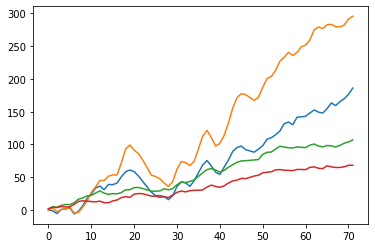

In [728]:
for r in range(4):
    plt.plot(f2[:,r])

In [771]:
np.log2(1)*0.8

0.0

In [777]:
np.e**(0.8)*np.log10(1.5)
10**(1)*np.log10(1.1)
#2**(0.8)*np.log(2.5-1)

0.4139268515822508

In [658]:
for i in range(2013,2019,1):
    for j in range(1,13):
        start_date=datetime(i,j,1) #first day of testing set
        print(start_date)

2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00
2013-09-01 00:00:00
2013-10-01 00:00:00
2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-01 00:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00


In [641]:
#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores

[8.539091745410117,
 11.124346816409377,
 11.167192226760092,
 9.244380849096924,
 3.9397954705730074,
 10.595257070399821,
 4.134617001377054,
 5.886442409455777,
 1.2478180820867404]

In [651]:
#res[1][:]
#res[1,:][:]
f1 = np.zeros((len(res),4))
f2 = np.zeros((len(res),4))
for i in range(4):
    f1[:,i] = np.array([row[i+1][1] for row in res])
    f2[:,i] = f1[:,i].cumsum()
#f1 = np.array([row[4][1] for row in res])
#f1.cumsum()
f2

array([[  3.8 ,  26.92,   1.68,  -0.58],
       [ 20.42,  60.43,  13.06,   3.87],
       [ 28.89,  71.91,  13.99,   0.45],
       [ 39.53,  94.97,  14.52,   5.37],
       [ 44.45, 109.36,  14.32,   8.81],
       [ 46.66, 102.07,   9.06,   9.54],
       [ 45.9 , 126.29,   0.28,   3.27],
       [ 62.61, 137.07,  12.24,   8.62],
       [ 81.72, 141.85,  24.78,  22.11],
       [ 93.17, 151.79,  33.74,  34.25],
       [101.12, 164.91,  34.06,  36.59],
       [110.47, 175.18,  40.84,  37.6 ],
       [135.47, 209.83,  50.99,  46.97],
       [150.18, 222.79,  51.21,  46.95],
       [170.61, 244.54,  63.77,  56.09],
       [174.93, 262.06,  65.92,  54.49],
       [169.97, 254.54,  65.75,  50.03],
       [166.89, 248.04,  77.14,  59.51]])

In [98]:
pred_test= model1.predict(xgb.DMatrix(xtest,label=None)) 

In [636]:
odds = eval_odds[test_indices]
odds_test_winner = []
data_check_ind =[]
for i in test_indices:
    if i % 2 == 0:
        #odds_test_winner.append(odds[i])
        odds_test_winner.append(eval_odds[i])
        data_check_ind.append(int(i/2))
odds_test_winner

[0.22999999999999998,
 1.44,
 0.22999999999999998,
 1.8599999999999999,
 0.49,
 0.48,
 1.2000000000000002,
 1.0699999999999998,
 0.3600000000000001,
 0.3400000000000001,
 0.3600000000000001,
 0.81,
 0.54,
 0.94,
 1.73,
 0.4099999999999999,
 0.6699999999999999,
 0.69,
 3.0599999999999996,
 0.020000000000000018,
 0.78,
 1.33,
 0.22999999999999998,
 2.3,
 0.030000000000000027,
 2.09,
 1.29,
 1.19,
 0.9299999999999999,
 0.0,
 1.33,
 0.26,
 1.7999999999999998,
 1.23,
 0.3799999999999999,
 0.47,
 1.27,
 1.2000000000000002,
 0.20999999999999996,
 0.3700000000000001,
 1.52,
 1.15,
 0.3500000000000001,
 0.6000000000000001,
 2.5,
 0.74,
 0.42999999999999994,
 0.74,
 0.95,
 0.71,
 0.3899999999999999,
 0.8999999999999999,
 0.75,
 0.24,
 0.3799999999999999,
 0.040000000000000036,
 1.0699999999999998,
 2.24,
 0.21999999999999997,
 0.18999999999999995,
 3.87,
 0.47,
 1.0899999999999999,
 0.6399999999999999,
 1.1800000000000002,
 0.27,
 0.6799999999999999,
 0.56,
 0.9099999999999999,
 1.63,
 0.49,
 0.

In [638]:
data.PSW.iloc[data_check_ind]

29138    1.23
29139    2.44
29140    1.23
29141    2.86
29142    1.49
29143    1.48
29144    2.20
29145    2.07
29146    1.36
29147    1.34
29148    1.36
29149    1.81
29150    1.54
29151    1.94
29152    2.73
29153    1.41
29154    1.67
29155    1.69
29156    4.06
29157    1.02
29158    1.78
29159    2.33
29160    1.23
29161    3.30
29162    1.03
29163    3.09
29164    2.29
29165    2.19
29166    1.93
29167     NaN
         ... 
29608    1.48
29609    1.84
29610    1.52
29611    1.65
29612    1.30
29613    1.52
29614    1.35
29615    1.98
29616    1.68
29617    1.61
29618    1.70
29619    1.74
29620    1.13
29621    2.59
29622    2.86
29623    1.90
29624    1.40
29625    2.33
29626    1.53
29627    2.86
29628    2.12
29629    1.37
29630    2.65
29631    1.52
29632    2.14
29633    2.62
29634    1.60
29635    2.13
29636    3.45
29637    1.71
Name: PSW, Length: 500, dtype: float64

In [58]:
ytest=pd.Series([1,0]*int(len(test_indices)/2))

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

In [586]:

#clf_list = [model1, model2, model3]
eval_scores = [evalscore1, evalscore2, evalscore3, evalscore4, evalscore5, evalscore6, evalscore7, evalscore8, evalscore9]
eval_scores
print(evalerror(model4.predict(xgb.DMatrix(xtest,label=None)),0))

('test_gain_error', 45.48315697031096)


In [708]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5, conf_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":
                preds_in = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                
                preds_dec = np.zeros(len(preds_in))
        
                for k in range(0,len(preds_in)-1,2):
                    if preds_in[k]>preds_in[k+1]:
                        preds_dec[k] = preds_in[k]
                        preds_dec[k+1] = 0
                    else:
                        preds_dec[k] = 0
                        preds_dec[k+1] = preds_in[k+1]
                
                #Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
                Y[:, i] = preds_dec
            else:
                # not further implemented. The Idea was to check if 
                # XGBClassifier gives other / better results
                # the call of it differs to XGB as many others too.
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        
        # log_odd voting
        odds = xtest_0.odds.fillna(1) 
        conf = np.log10(odds)
        Y_log = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_log[:, i] = 10**(Y[:, i]) * conf
            
        # log_odd mean voting    
        
        
        
        # odd confidence voting
        odds = xtest_0.odds.fillna(1)        
        conf = 1/odds        
        Y_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i in range(len(self.estimators)):
            Y_conf[:, i] = Y[:, i] * conf
            
        # odd conf mean proba voting
        y_mean_conf = np.zeros(X.shape[0])
        y_mean_pr_conf = np.mean(Y_conf, axis=1)
        y_mean_conf = [1 if i >=conf_thr else 0 for i in y_mean_pr_conf]      

        # majority conf voting
        y_voting_conf = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting_conf = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            #K = np.array([1 if i >=conf_thr else 0 for i in Y[:,i]])
            Y_voting_conf[:,i] = [1 if i >=conf_thr else 0 for i in Y_conf[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting_conf[i,:].sum()/len(self.estimators)
            y_voting_conf[i] = 1 if deci >= vote_thr else 0
            #y_mer[]        

        # mean proba voting
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean = [1 if i >=thr else 0 for i in y_mean_pr]
        
        # majority voting
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        #return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf
        return  y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf
        #return y, Y, K, KT

In [605]:
clf_list = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
classif = VotingClassifier(clf_list)
xtest_0=features.iloc[test_indices,:].reset_index(drop=True)
#Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci, y_mean_pr_conf, y_mean_conf= classif.predict(xtest, 0.7, vote_thr = (7/9))
y_mean,  y_voting, y_mean_pr_conf, y_mean_conf, y_voting_conf = classif.predict(xtest, 0.6, vote_thr = (7/9), conf_thr = 0.6)


print(evalerror(y_voting, dtrain))
print(evalerror(y_mean, dtrain))
print(evalerror(y_mean_conf, dtrain))
print(evalerror(y_voting_conf, dtrain))

('test_gain_error', 20.18)
('test_gain_error', 22.65)
('test_gain_error', 8.07)
('test_gain_error', 6.260000000000001)


In [774]:
10**(1.01)

10.232929922807541

In [490]:
y_mean_pr_conf

array([0.38350666, 0.16743562, 0.30840665, ..., 0.46068716, 0.6384262 ,
       0.04607432], dtype=float32)

In [249]:
from sklearn.metrics import confusion_matrix

In [466]:
cnf_matrix = confusion_matrix(ytest, y_voting)
cnf_matrix

array([[1840,  160],
       [1318,  682]])

In [351]:
evalerror(y_voting, dtrain)

('test_gain_error', -5.280000000000001)

In [ ]:
class VotingClassifier(object):
    """ Implements a voting classifier for pre-trained classifiers"""

    def __init__(self, estimators):
        self.estimators = estimators

    def predict(self, X, thr = 0.5 ,vote_thr = 0.5):
        # get values
        Y = np.zeros([X.shape[0], len(self.estimators)], dtype='float32')
        for i, clf in enumerate(self.estimators):
            if str(type(clf)) == "<class 'xgboost.core.Booster'>":              
                Y[:, i] = np.array(clf.predict(xgb.DMatrix(X,label=None)))
            else:
                print('Hallo')
                Y[:, i] = clf.predict_proba(X)
        # apply voting 
        
        # mean proba voting
        
        y_mean = np.zeros(X.shape[0])
        y_mean_pr = np.mean(Y, axis=1)
        y_mean = [1 if i >=thr else 0 for i in y_mean_pr]
        
        
        y_voting = np.zeros(X.shape[0])
        y_mer = np.zeros(X.shape[0])
        Y_voting = np.zeros([X.shape[0], len(self.estimators)], dtype='int')
        for i in range(len(self.estimators)):  
            K = np.array([1 if i >=thr else 0 for i in Y[:,i]])
            Y_voting[:,i] = [1 if i >=thr else 0 for i in Y[:,i]]
            
        for i in range(X.shape[0]):
            deci = Y_voting[i,:].sum()/len(self.estimators)
            y_voting[i] = 1 if deci >= vote_thr else 0
            #y_mer[]
         
        return Y, K, KT, y_mean_pr, y_mean, Y_voting, y_voting, deci
        #return y, Y, K, KT

In [732]:
def evalerror(preds, dtrain):
#thr = 0.5
    #labels = dtrain.get_label()
    global eval_odds
    global train_indices
    global val_indices
    global test_indices
    
    #print(preds[0:10])


    if len(preds) == len(train_indices):
        odds = eval_odds[train_indices]
        gain = odds * preds       
        return 'train_gain_error', -gain.sum()
    elif len(preds) == len(val_indices):
        odds = eval_odds[val_indices]
        gain = odds * preds 
        return 'val_gain_error', -gain.sum()
    elif len(preds) == len(test_indices):
        odds = eval_odds[test_indices]
        gain = odds * preds 
        #return 'test_o_gain_error', -gain.sum(), odds
        return 'test_o_gain_error', -gain.sum()
    else:
        return 'function_error', 0

In [540]:
features.columns

Index(['odds', 'odds_opp', 'cat_feature_0', 'cat_feature_1', 'cat_feature_2',
       'cat_feature_3', 'cat_feature_4', 'cat_feature_5', 'cat_feature_6',
       'cat_feature_7',
       ...
       'recentft_150_1_opp', 'recentft_150_2_opp', 'recentft_150_3_opp',
       'recentft_150_4_opp', 'recentft_150_5_opp', 'recentft_150_6_opp',
       'recentft_150_7_opp', 'recentft_150_8_opp', 'recentft_150_9_opp',
       'recentft_150_10_opp'],
      dtype='object', length=246)